In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import ot
from scipy.spatial.distance import cdist

from scipy.stats import multivariate_normal as mvn
from matplotlib import cm

In [2]:
# from sklearn.datasets import fetch_openml

# # Load MNIST dataset using scikit-learn
# mnist = fetch_openml('mnist_784')

# # Extract features and labels
# images, labels = mnist.data, mnist.target

# np.save("PATH//mnist_data.npy", np.array(images.values))
# np.save("PATH//mnist_labels.npy", np.array(labels.values))

In [3]:
data_folder = 'D:\\MNIST-digits\\'

images = np.load(data_folder+"mnist_data.npy")
labels = np.load(data_folder+"mnist_labels.npy", allow_pickle=True)

image_list = [image.reshape(28,28) for i, image in enumerate(images) if labels[i] =='5']

In [4]:
class measure():
    
    def __init__(self, weights, locations):        
        self.weights = np.array(weights)
        self.locations = np.array(locations)
        
        #check that sizes are consistent
        assert self.weights.shape[0] == self.locations.shape[0]

        
        
        
    # Plotting #################################################################

    def plot_density(self):
        est = np.zeros((28,28))

        for i in range(28):
            for j in range(28):
                #Estimate measure on grid using Gaussian Kernels
                est[i,j] = np.sum(mvn.pdf(self.locations, mean=[i,j],cov=np.eye(2))*self.weights)

        plt.imshow(est, cmap=cm.hot_r)
        plt.xticks([])
        plt.yticks([])

    def plot_locations(self):
        # plt.plot(self.locations[self.weights>0,1], -self.locations[self.weights>0,0],'.',c='black', alpha = self.weights)
        for i, location in enumerate(self.locations):
            plt.plot(location[1], -location[0],'.',c='black', alpha = self.weights[i]/max(self.weights))
            
        plt.xlim(0,28)
        plt.ylim(-28,0)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_aspect('equal', 'box')
        

In [5]:
#get distance matrix and coordinates for MNIST data
D = np.zeros((2,28,28))

for i in range(28):
    for j in range(28):
        
        D[:,i,j] = np.array([i,j])
        
coords = D.reshape(2,28*28).T

M = np.square(cdist(coords,coords))    

In [6]:
measure_list = [measure((image/np.sum(image)).flatten(), coords) for image in image_list if np.sum(image)>0]

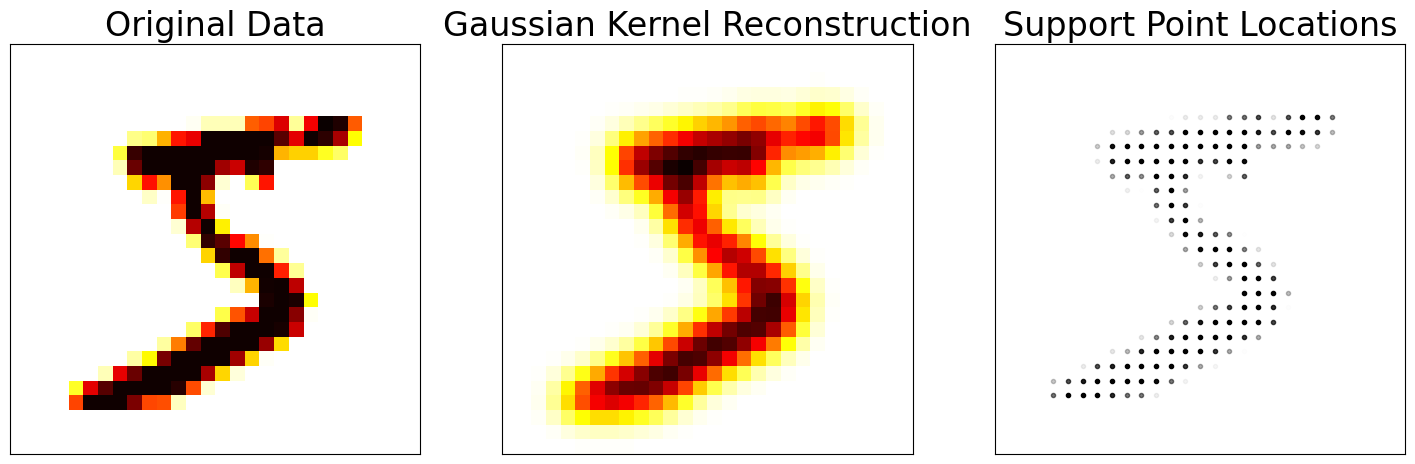

In [7]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(image_list[0], cmap=cm.hot_r)
plt.xticks([])
plt.yticks([])
plt.title("Original Data",fontsize=24)

plt.subplot(1,3,2)
measure_list[0].plot_density()
plt.title("Gaussian Kernel Reconstruction",fontsize=24)

plt.subplot(1,3,3)
measure_list[0].plot_locations()
plt.title("Support Point Locations",fontsize=24)

# plt.show()
plt.savefig("mnist_data.png")

In [8]:
def locations_update(barycenter, measure_list, Pi_list):
        
    return np.mean(np.array([measure_list[i].locations.T@Pi_list[i].T@np.diag(1/barycenter.weights.reshape(-1)) for i in range(len(measure_list))]),0).T


def weights_update(barycenter, alpha_list, lr=0.000075):
    
    #get subgradient
    alpha = np.mean(np.array(alpha_list),0)

    #calculate subgradient update
    a_star = barycenter.weights+(lr*alpha.reshape(1,-1))

    #project a_star into (interior of) probability simplex
    a_star[a_star<0]=0.000001
    a = a_star/np.sum(a_star)
    
    return a.reshape(-1)

    
def free_support_barycenter_update(measure_list, barycenter=None, N=20):
    
    if barycenter==None:
        init_weights = np.ones((N,1))/N
        init_locations = np.zeros(3)+np.random.normal(size=(N,3))
        barycenter = measure(init_weights, init_locations)
            
    else:
        
        M=np.square(cdist(barycenter.locations,measure_list[0].locations))
    
        result_list = [ot.emd(barycenter.weights,measure.weights,M,log=True) for measure in measure_list]
        Pi_list = [result[0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1]['u'],result[1]['v'])[0] for result in result_list]
        
        barycenter.locations = locations_update(barycenter, measure_list, Pi_list)
        barycenter.weights = weights_update(barycenter, alpha_list)
    
    return barycenter


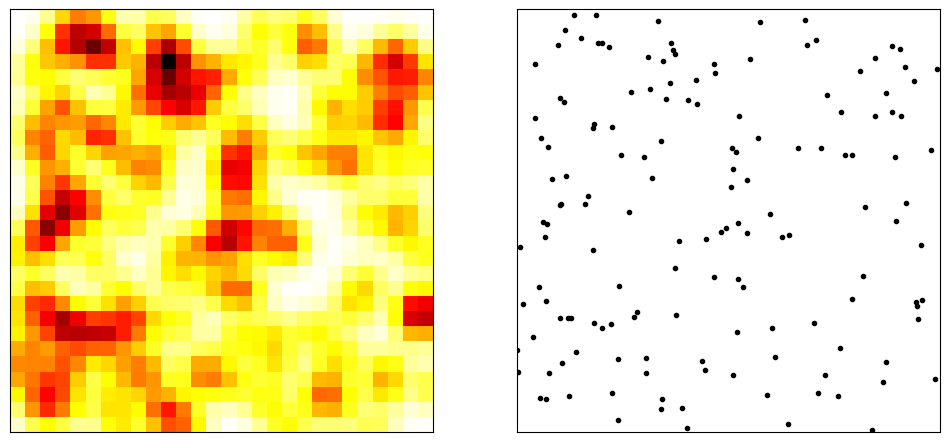

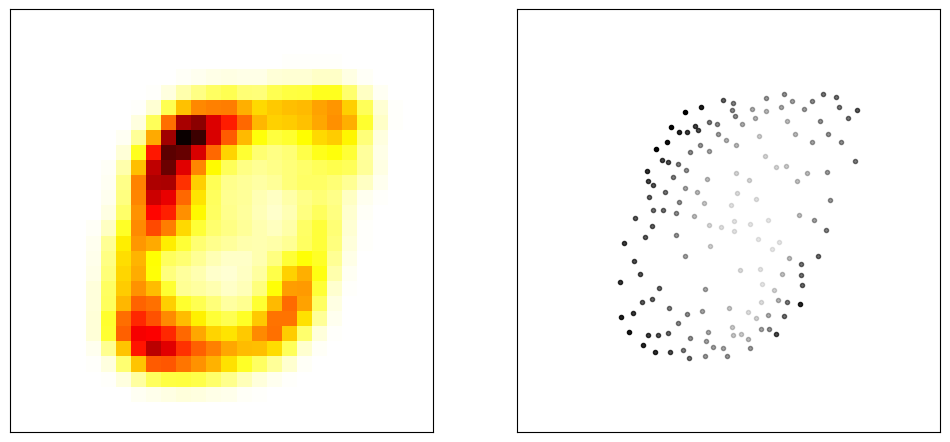

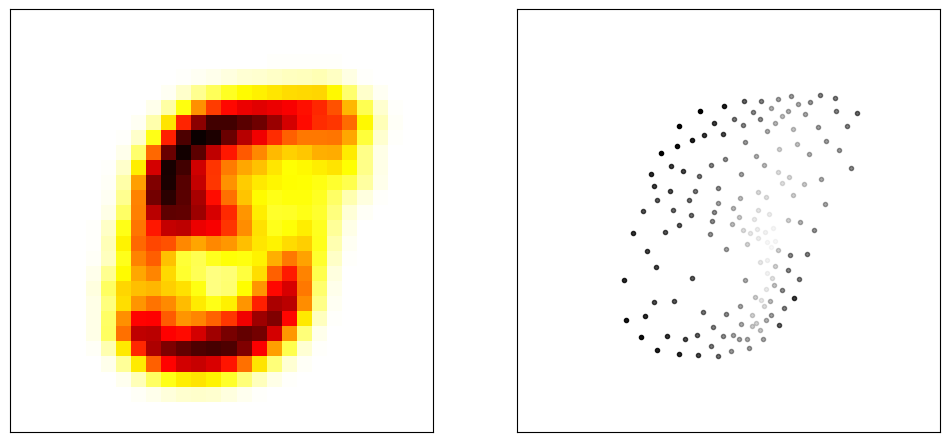

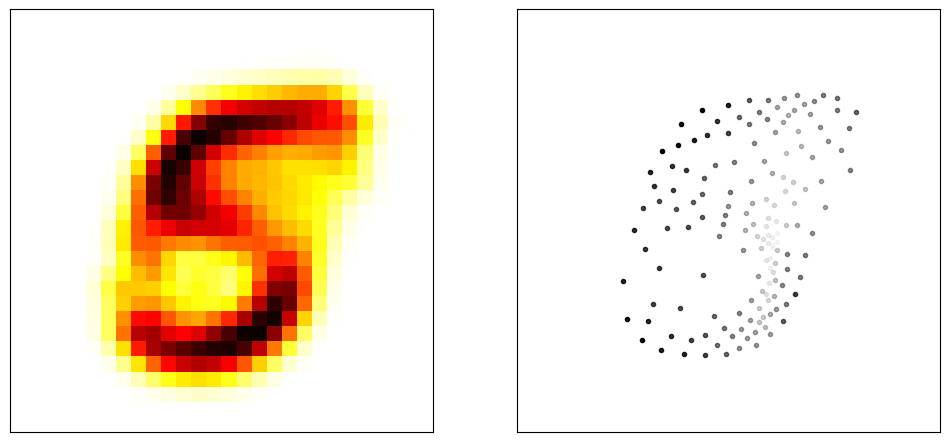

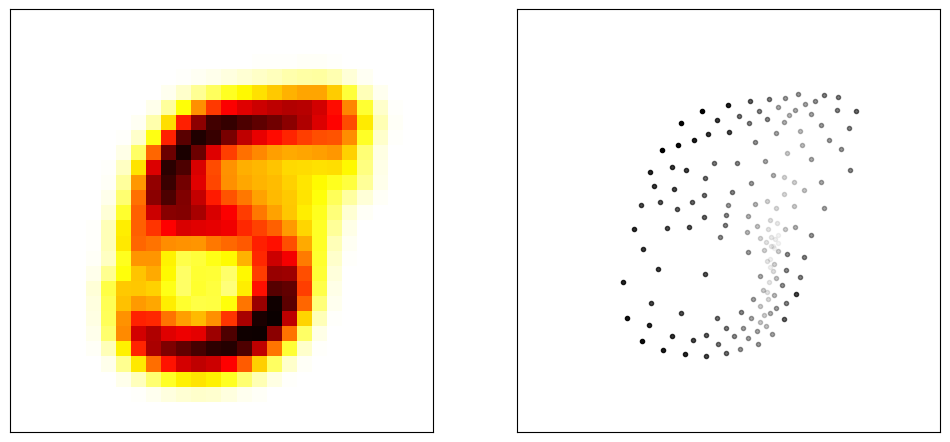

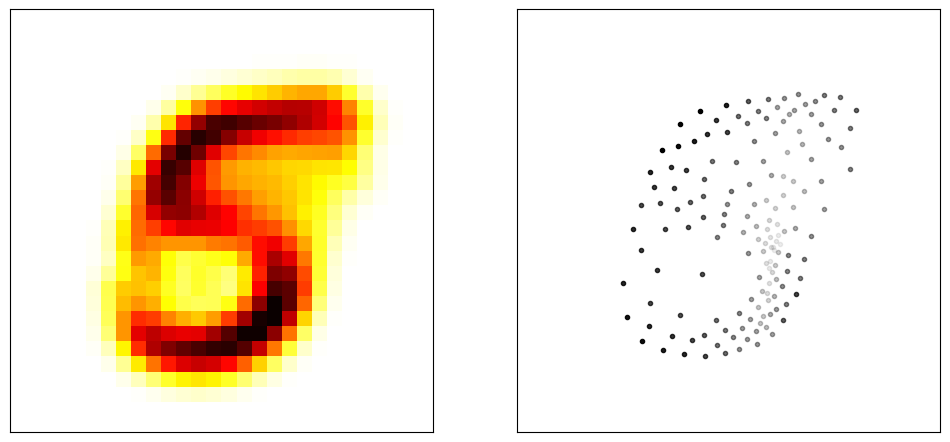

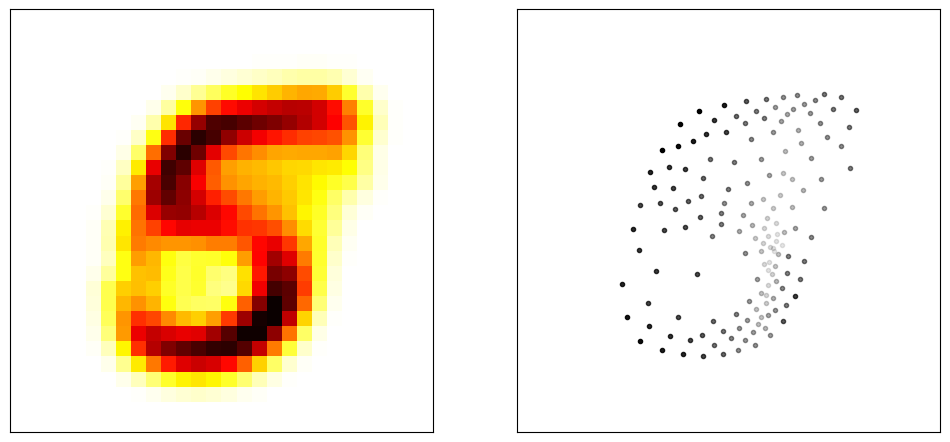

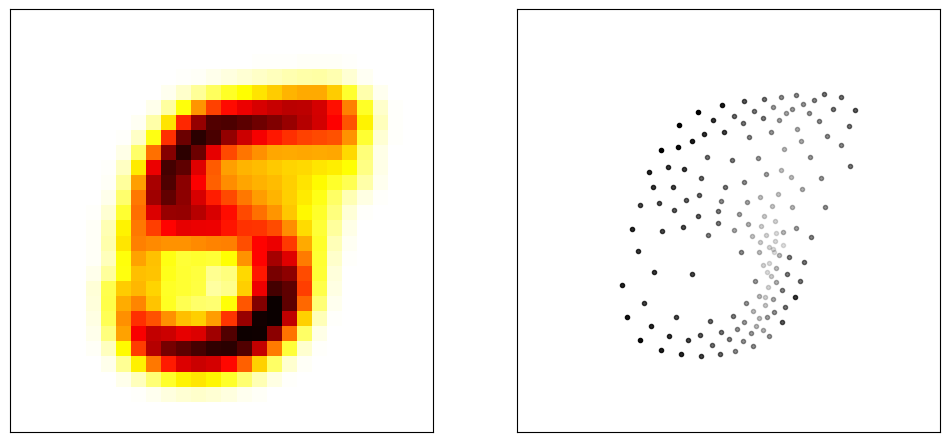

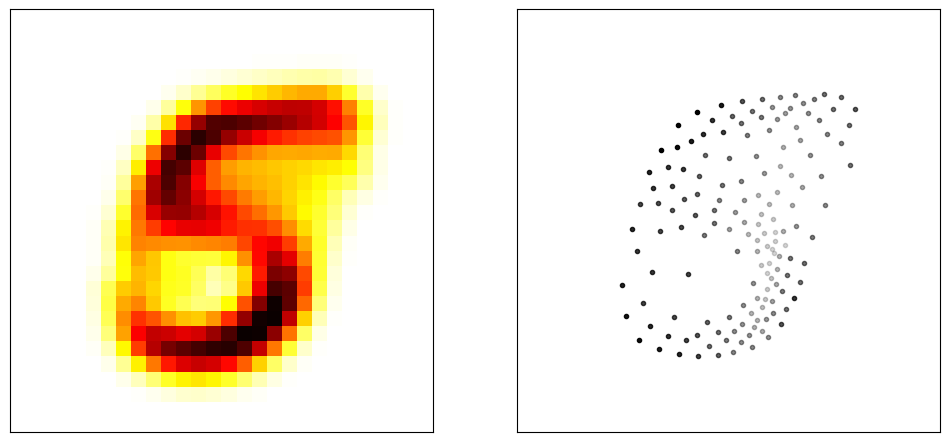

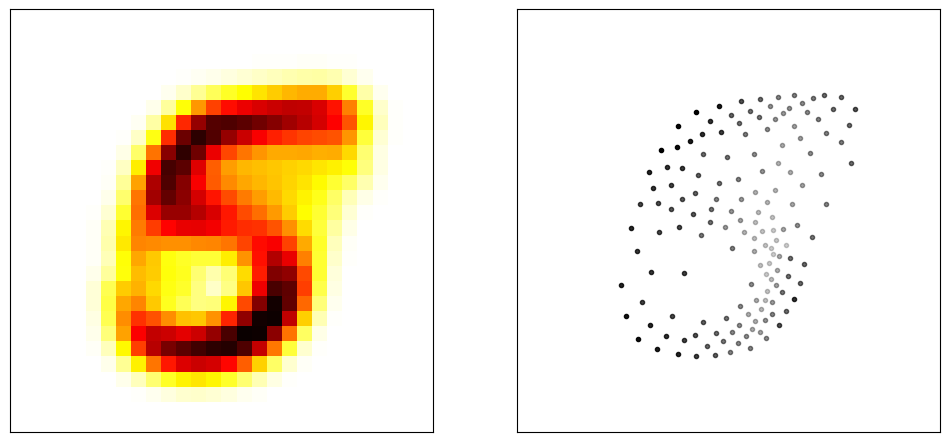

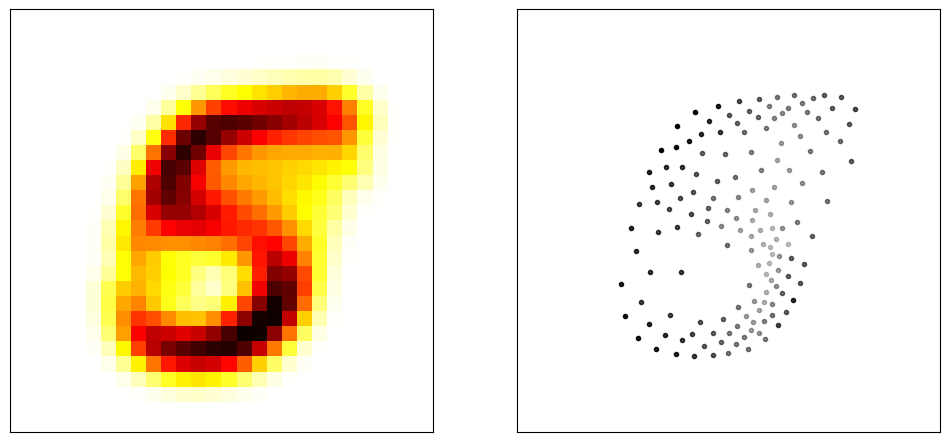

In [9]:
N=150
barycenter_150 = measure(np.ones(N)/N, np.random.rand(N,2)*28)

#Plot initial barycenter
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
barycenter_150.plot_density()

plt.subplot(1,2,2)
barycenter_150.plot_locations()

plt.show()


for i in range(10):
    
    barycenter_150 = free_support_barycenter_update(measure_list, barycenter_150, N=N)
    
    #plot barycenter after each update
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    barycenter_150.plot_density()
    
    plt.subplot(1,2,2)
    barycenter_150.plot_locations()
    
    plt.show()

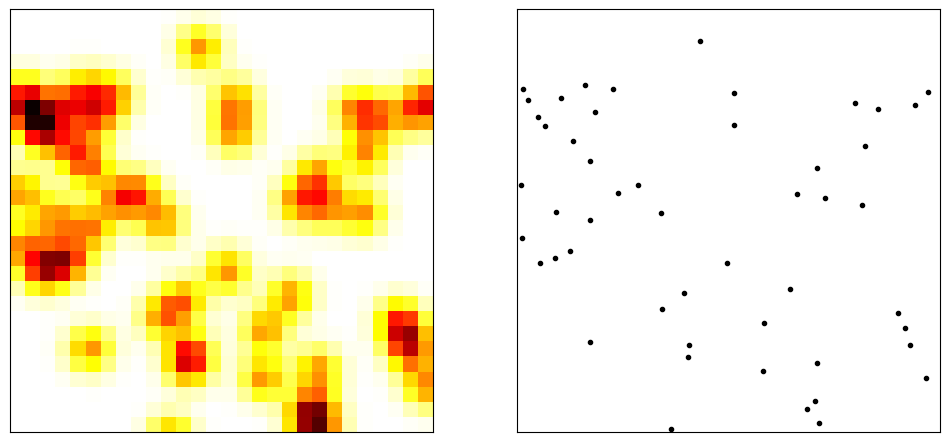

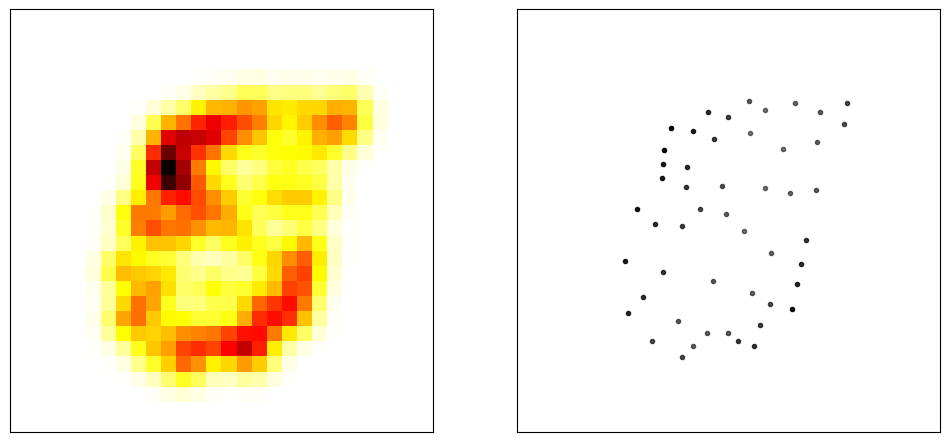

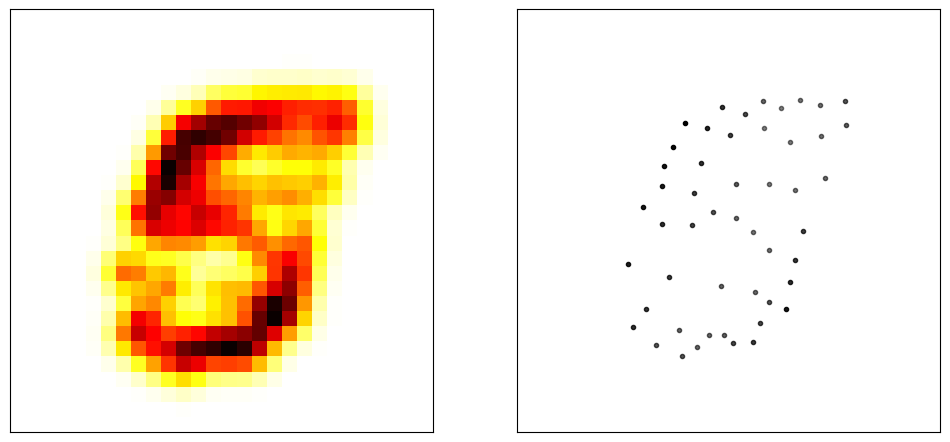

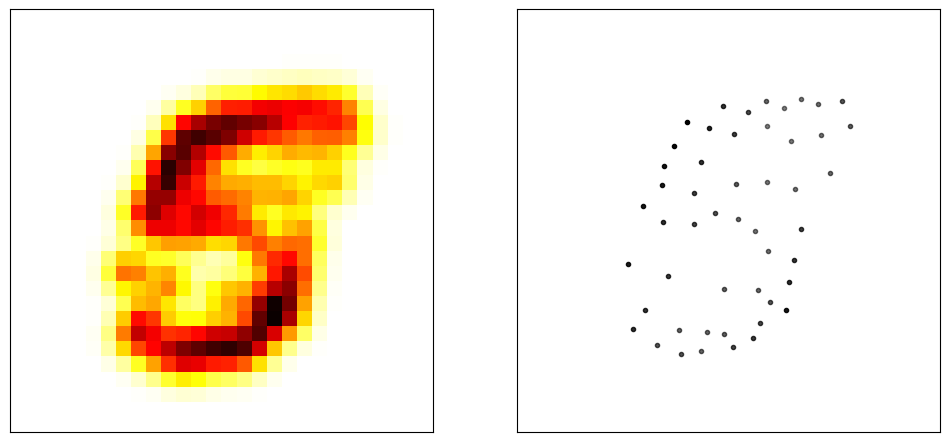

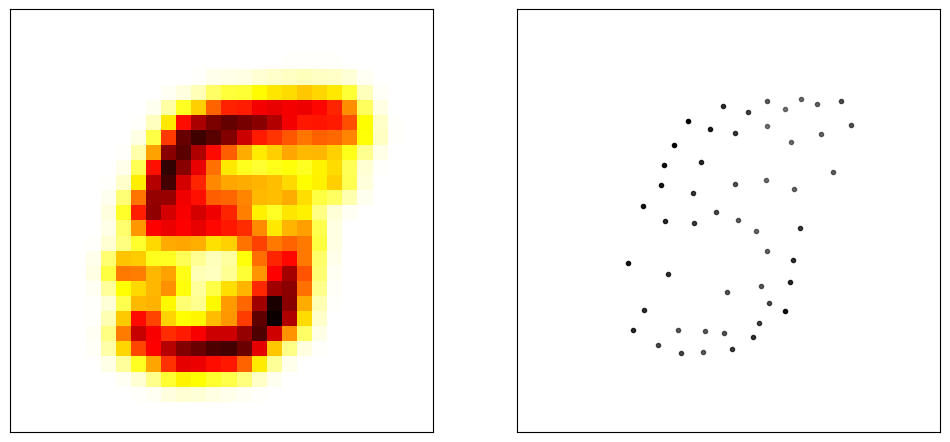

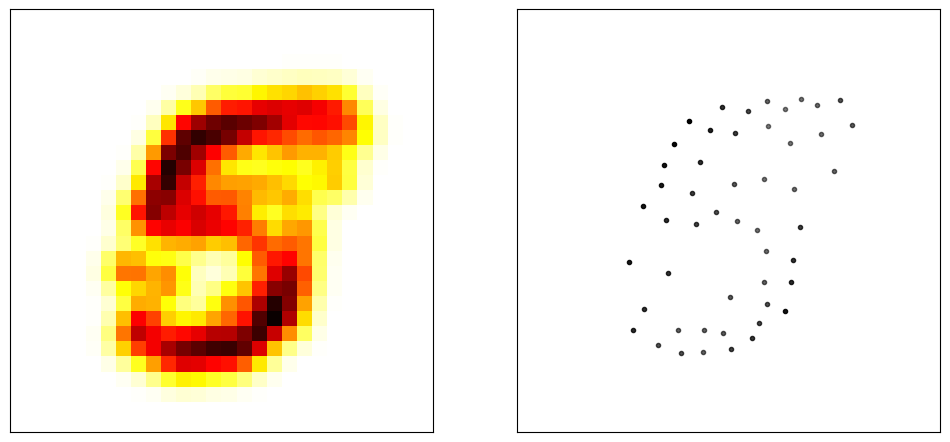

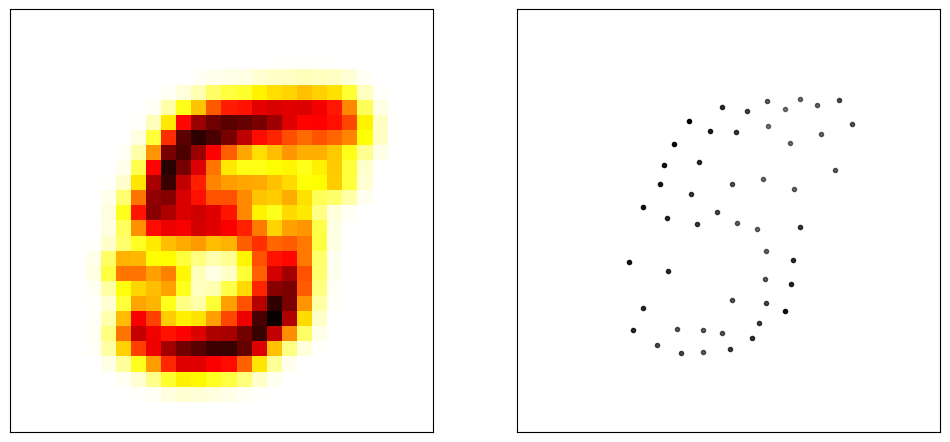

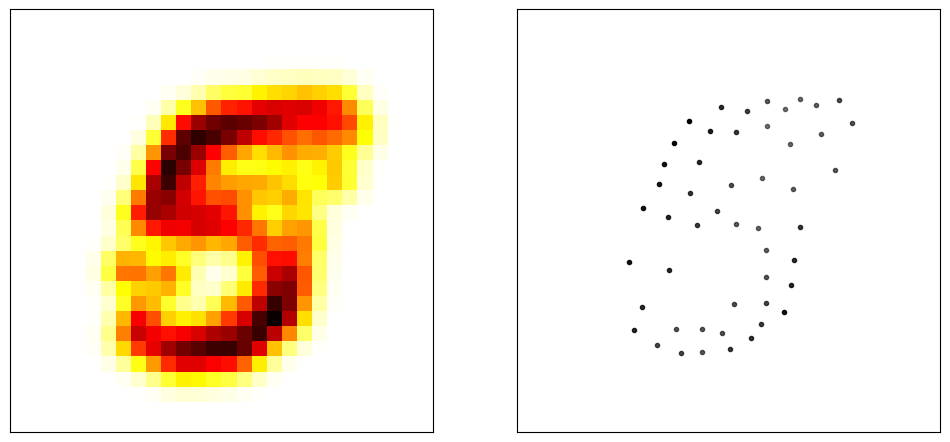

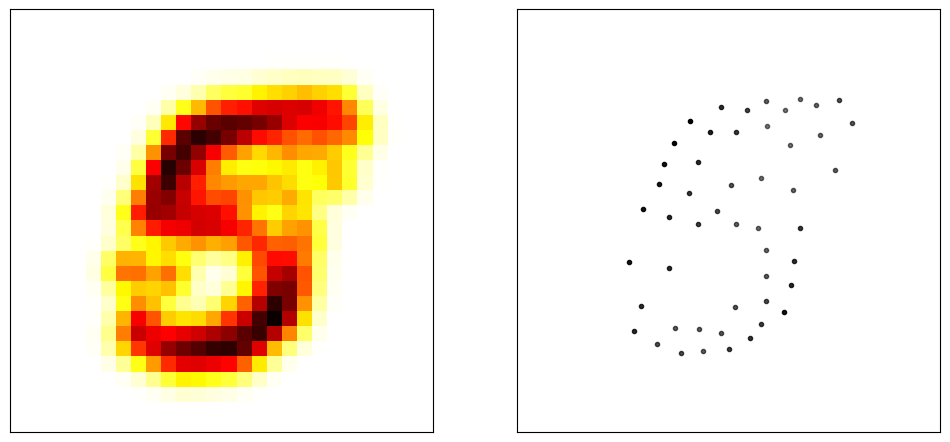

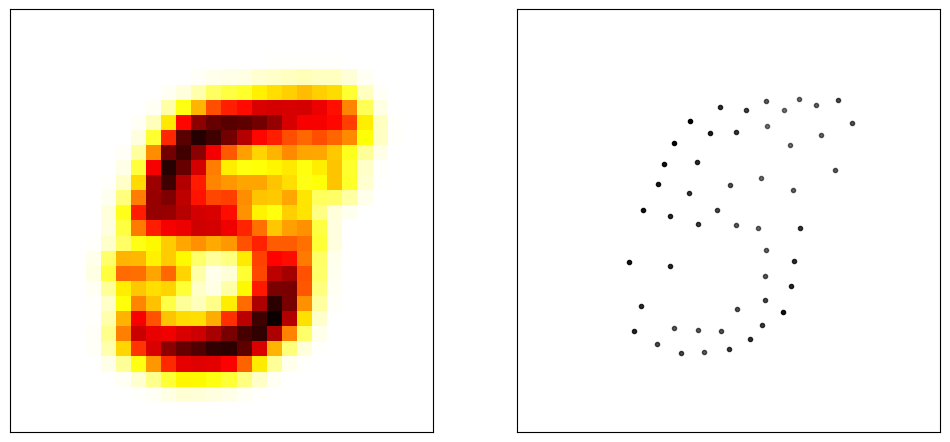

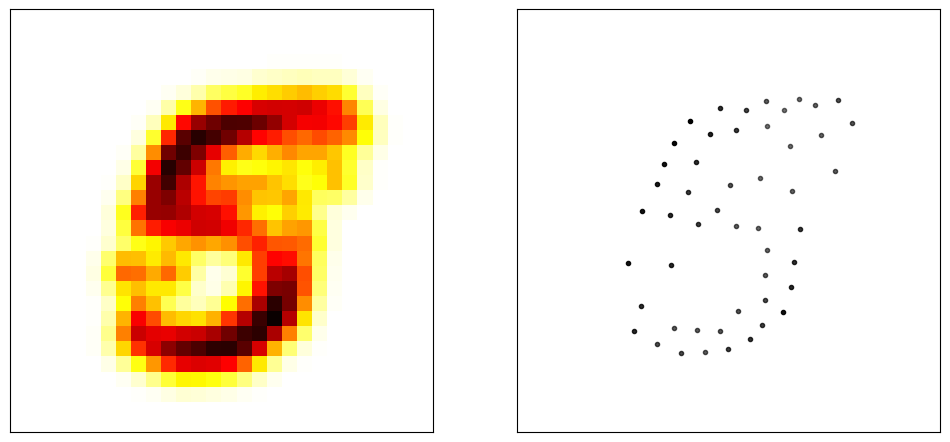

In [10]:
N=50
barycenter_50 = measure(np.ones(N)/N, np.random.rand(N,2)*28)

#Plot initial barycenter
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
barycenter_50.plot_density()

plt.subplot(1,2,2)
barycenter_50.plot_locations()

plt.show()

for i in range(10):
    
    barycenter_50 = free_support_barycenter_update(measure_list, barycenter_50, N=N)
    
    #plot barycenter after each update
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    barycenter_50.plot_density()
    
    plt.subplot(1,2,2)
    barycenter_50.plot_locations()
    
    plt.show()

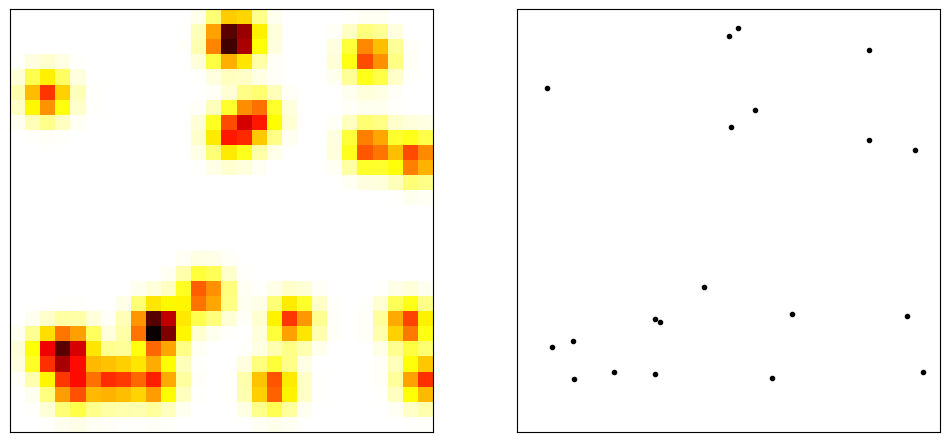

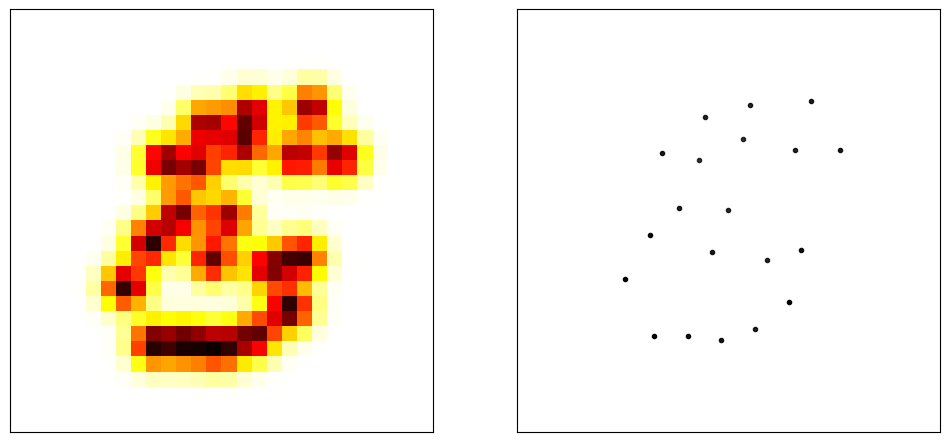

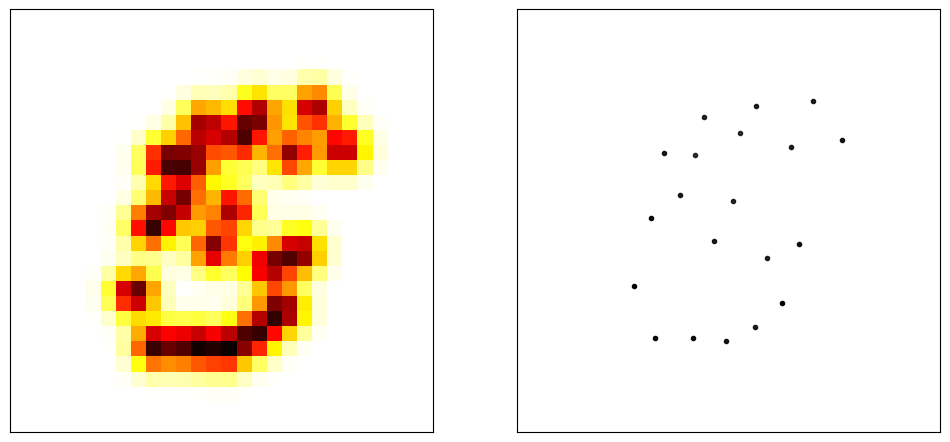

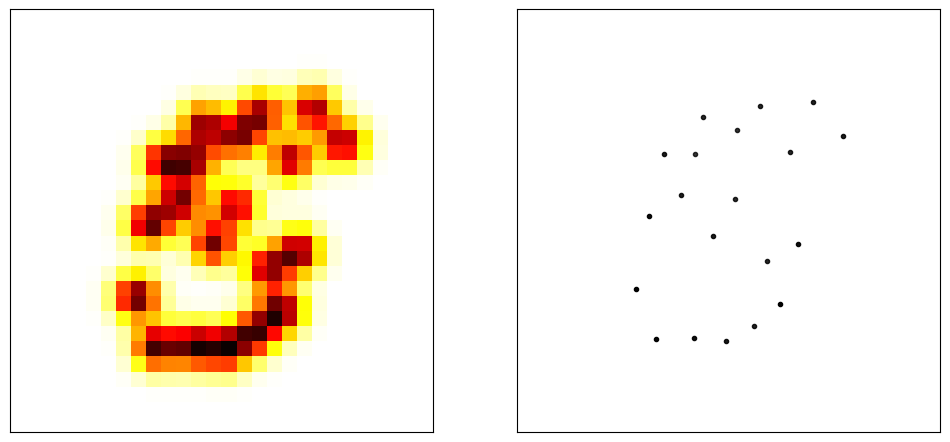

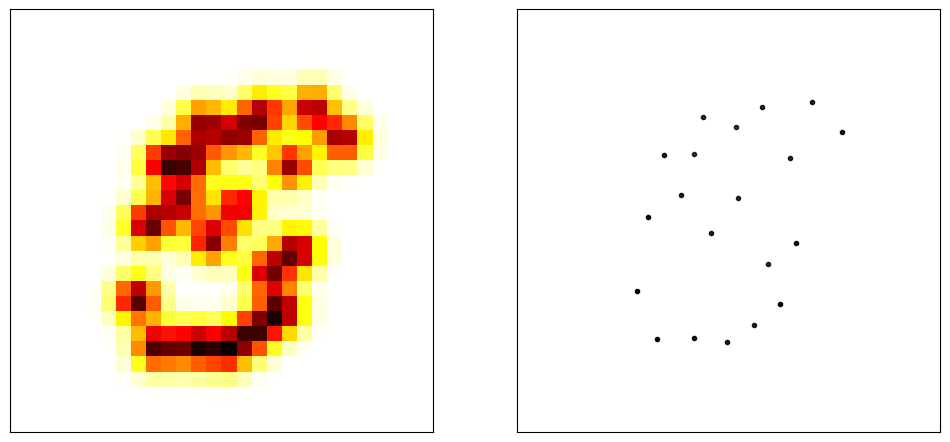

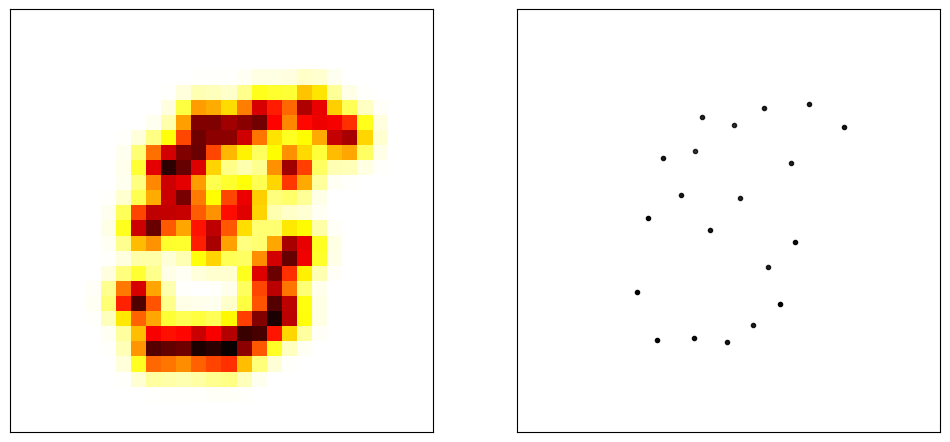

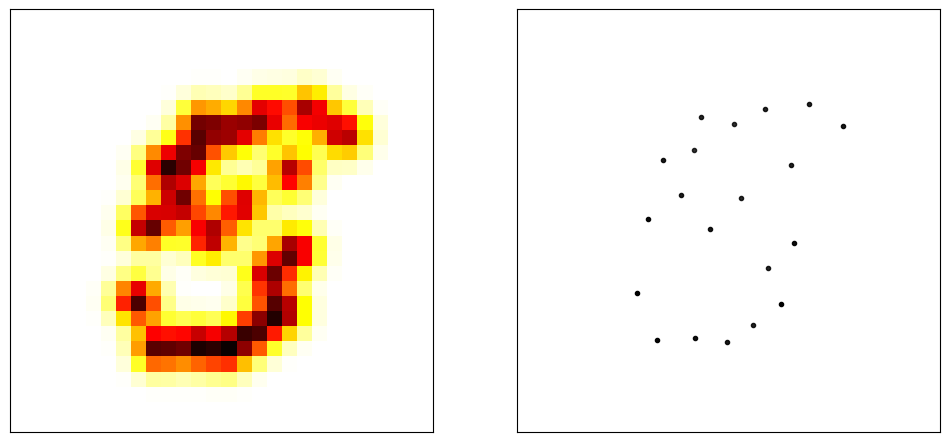

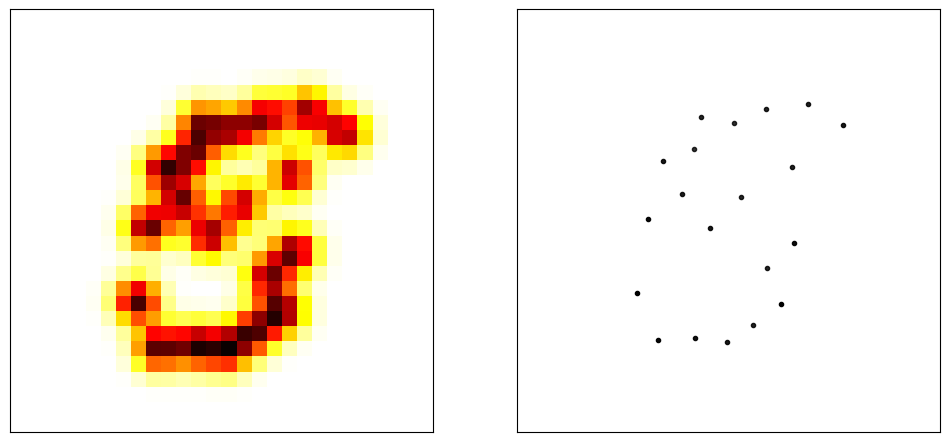

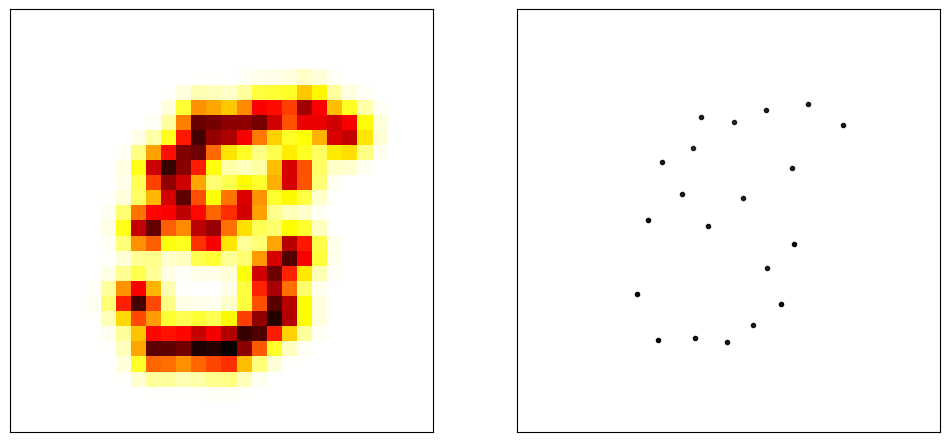

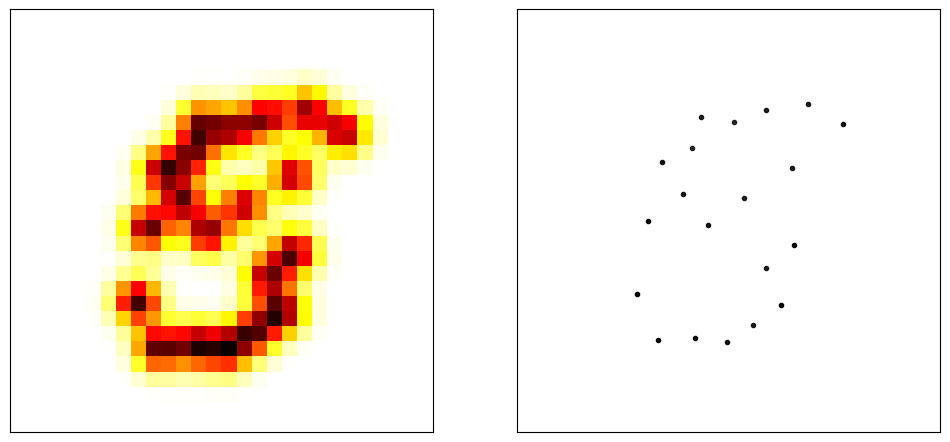

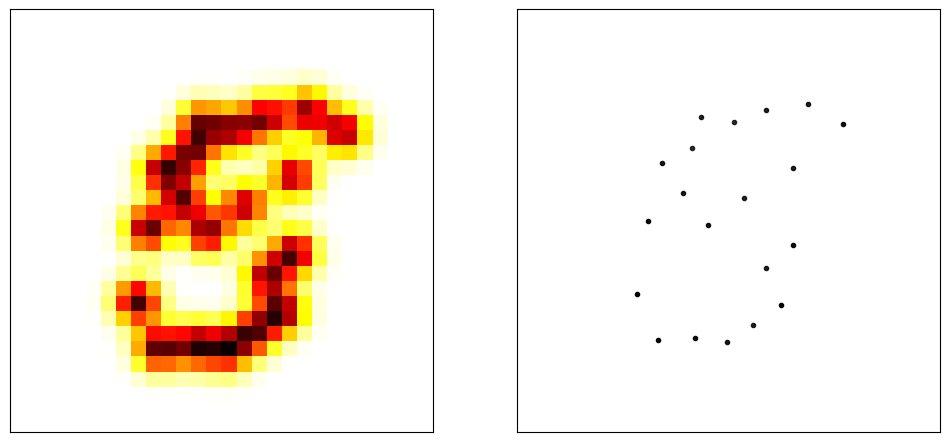

In [11]:
N=20
barycenter_20 = measure(np.ones(N)/N, np.random.rand(N,2)*28)

#Plot initial barycenter
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
barycenter_20.plot_density()

plt.subplot(1,2,2)
barycenter_20.plot_locations()

plt.show()


for i in range(10):
    
    barycenter_20 = free_support_barycenter_update(measure_list, barycenter_20, N=N)
    
    #plot barycenter after each update
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    barycenter_20.plot_density()
    
    plt.subplot(1,2,2)
    barycenter_20.plot_locations()
    
    plt.show()

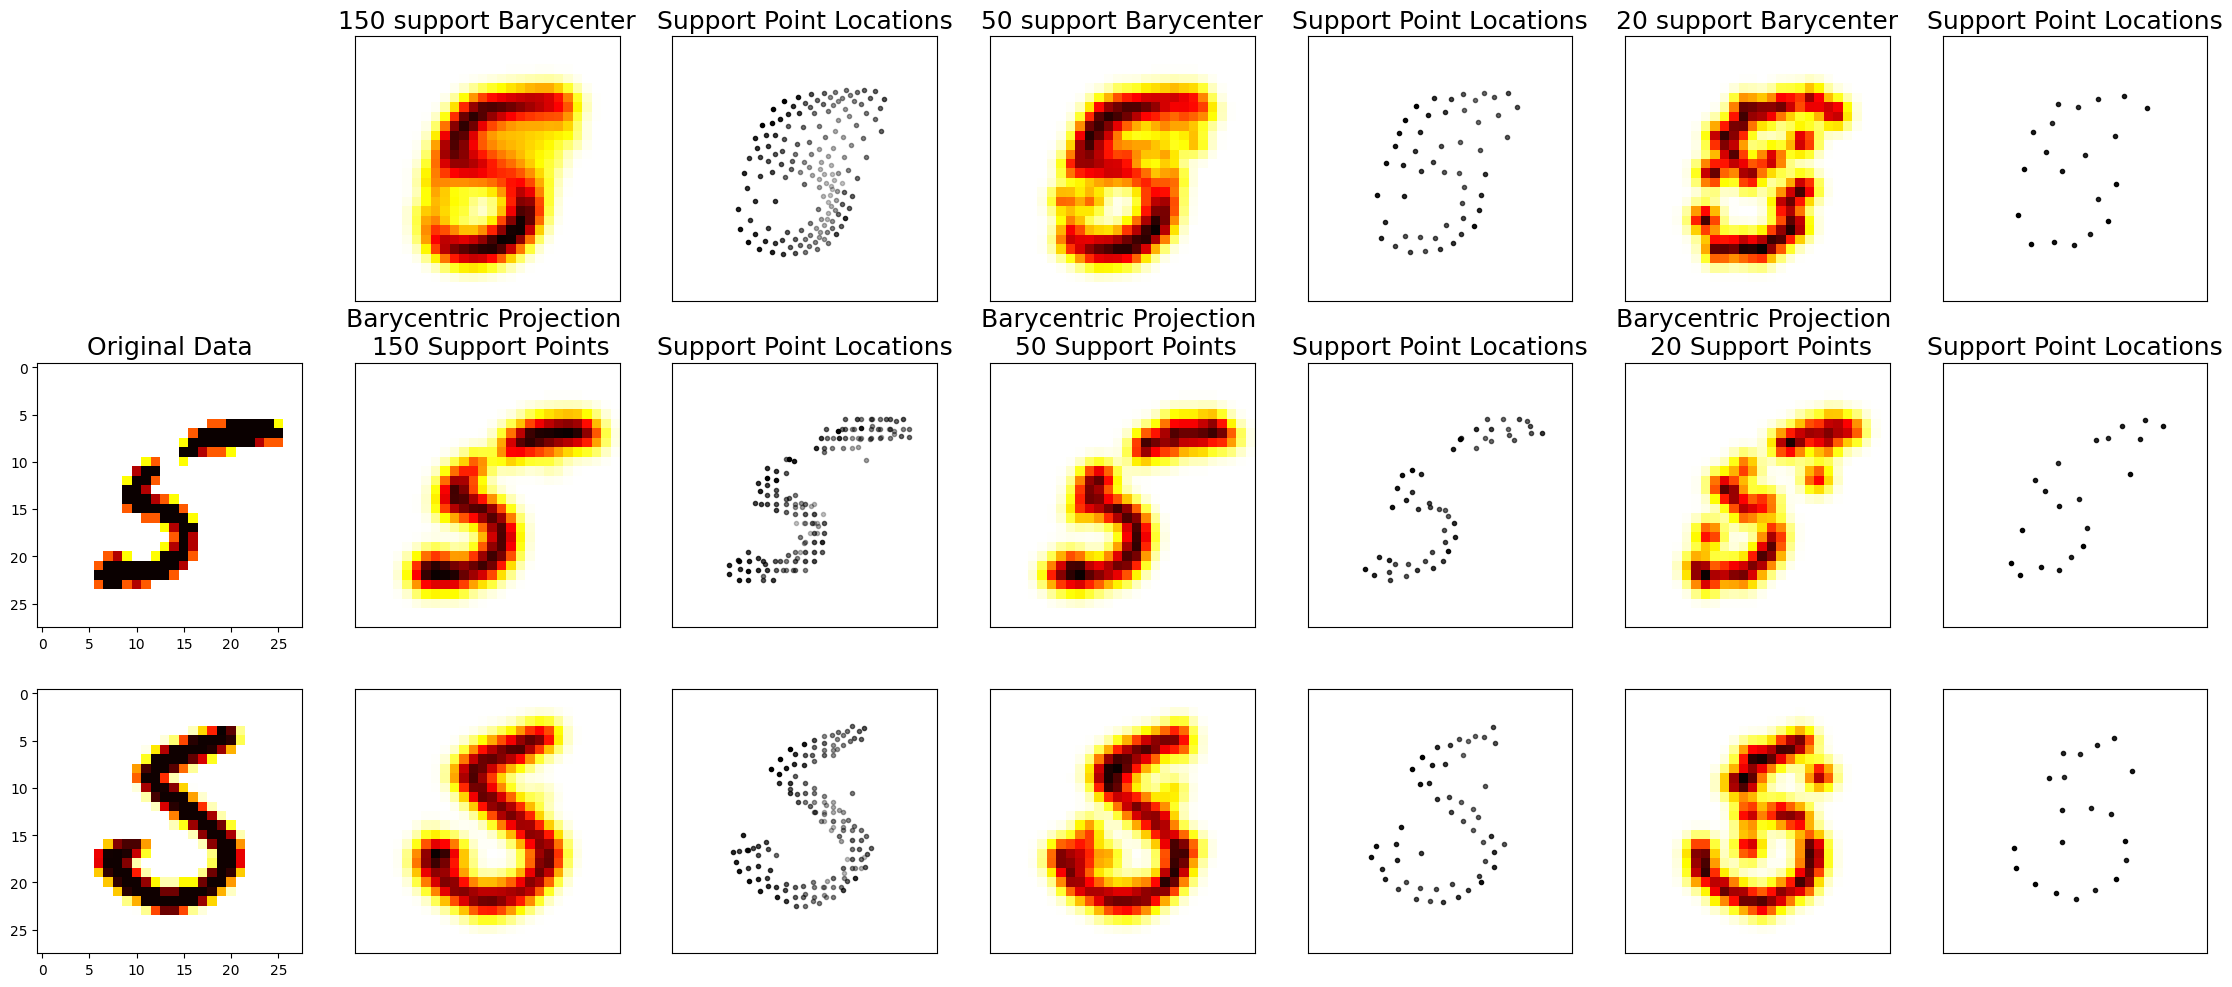

In [12]:
plt.figure(figsize = (28,12))

plt.subplot(3,7,1)
plt.gca().set_axis_off()

plt.subplot(3,7,2)
barycenter_150.plot_density()
plt.title("150 support Barycenter", fontsize=18)

plt.subplot(3,7,3)
barycenter_150.plot_locations()
plt.title("Support Point Locations", fontsize=18)


plt.subplot(3,7,4)
barycenter_50.plot_density()
plt.title("50 support Barycenter", fontsize=18)

plt.subplot(3,7,5)
barycenter_50.plot_locations()
plt.title("Support Point Locations", fontsize=18)


plt.subplot(3,7,6)
barycenter_20.plot_density()
plt.title("20 support Barycenter", fontsize=18)


plt.subplot(3,7,7)
barycenter_20.plot_locations()
plt.title("Support Point Locations", fontsize=18)



i = 3
test0 = measure_list[i]

plt.subplot(3,7,1+7)
plt.imshow(image_list[i], cmap =cm.hot_r)
plt.title("Original Data", fontsize=18)

plt.subplot(3,7,2+7)
test = measure(barycenter_150.weights, np.diag(1/barycenter_150.weights)@ot.emd(barycenter_150.weights, test0.weights, cdist(barycenter_150.locations,test0.locations))@test0.locations)
test.plot_density()
plt.title("Barycentric Projection \n 150 Support Points", fontsize=18)

plt.subplot(3,7,3+7)
test.plot_locations()
plt.title("Support Point Locations", fontsize=18)

plt.subplot(3,7,4+7)
test = measure(barycenter_50.weights, np.diag(1/barycenter_50.weights)@ot.emd(barycenter_50.weights, test0.weights, cdist(barycenter_50.locations,test0.locations))@test0.locations)
test.plot_density()
plt.title("Barycentric Projection \n 50 Support Points", fontsize=18)


plt.subplot(3,7,5+7)
test.plot_locations()
plt.title("Support Point Locations", fontsize=18)

plt.subplot(3,7,6+7)
test = measure(barycenter_20.weights, np.diag(1/barycenter_20.weights)@ot.emd(barycenter_20.weights, test0.weights, cdist(barycenter_20.locations,test0.locations))@test0.locations)
test.plot_density()
plt.title("Barycentric Projection \n 20 Support Points", fontsize=18)

plt.subplot(3,7,7+7)
test.plot_locations()
plt.title("Support Point Locations", fontsize=18)


i = 7
test0 = measure_list[i]

plt.subplot(3,7,1+14)
plt.imshow(image_list[i], cmap =cm.hot_r)

plt.subplot(3,7,2+14)
test = measure(barycenter_150.weights, np.diag(1/barycenter_150.weights)@ot.emd(barycenter_150.weights, test0.weights, cdist(barycenter_150.locations,test0.locations))@test0.locations)
test.plot_density()

plt.subplot(3,7,3+14)
test.plot_locations()

plt.subplot(3,7,4+14)
test = measure(barycenter_50.weights, np.diag(1/barycenter_50.weights)@ot.emd(barycenter_50.weights, test0.weights, cdist(barycenter_50.locations,test0.locations))@test0.locations)
test.plot_density()

plt.subplot(3,7,5+14)
test.plot_locations()

plt.subplot(3,7,6+14)
test = measure(barycenter_20.weights, np.diag(1/barycenter_20.weights)@ot.emd(barycenter_20.weights, test0.weights, cdist(barycenter_20.locations,test0.locations))@test0.locations)
test.plot_density()

plt.subplot(3,7,7+14)
test.plot_locations()


plt.savefig("MNIST_test2.png",bbox_inches='tight')

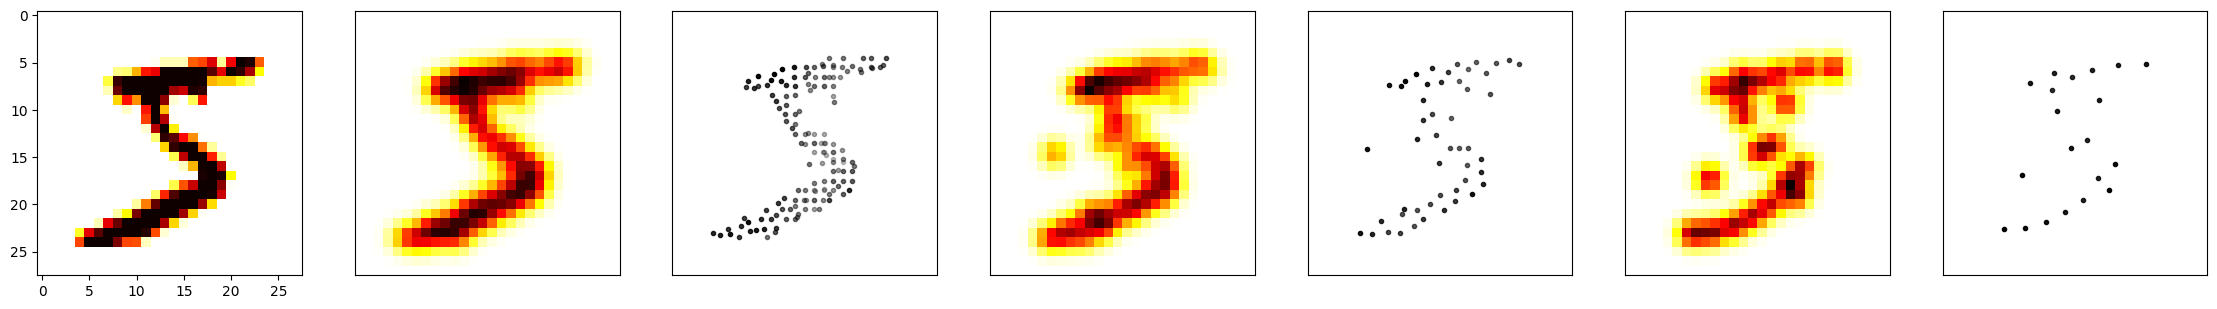

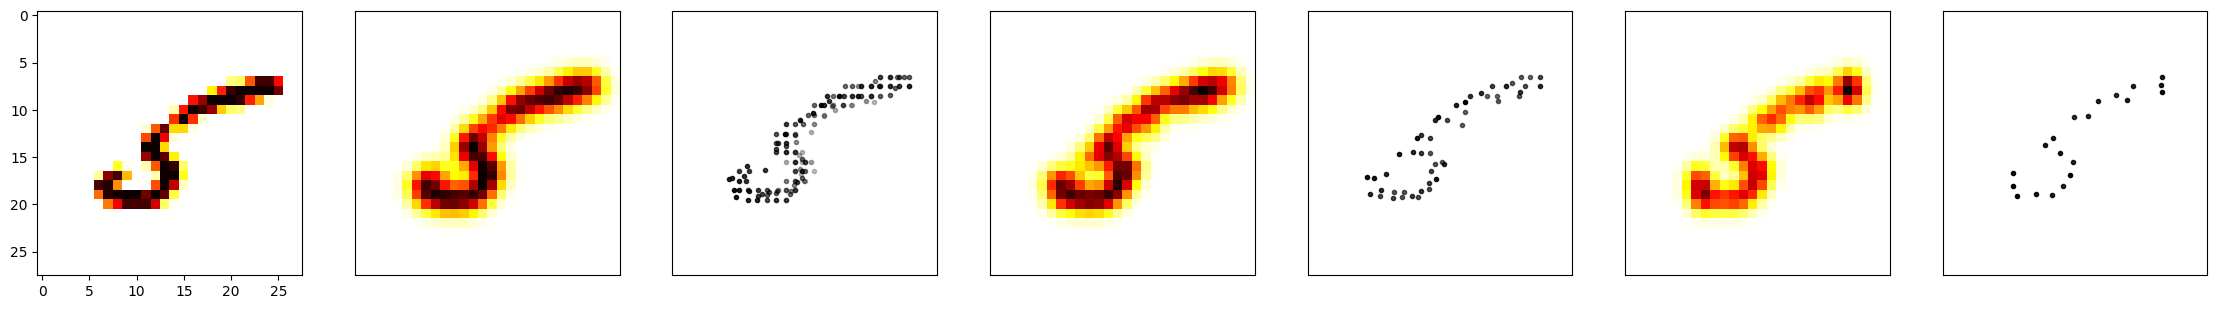

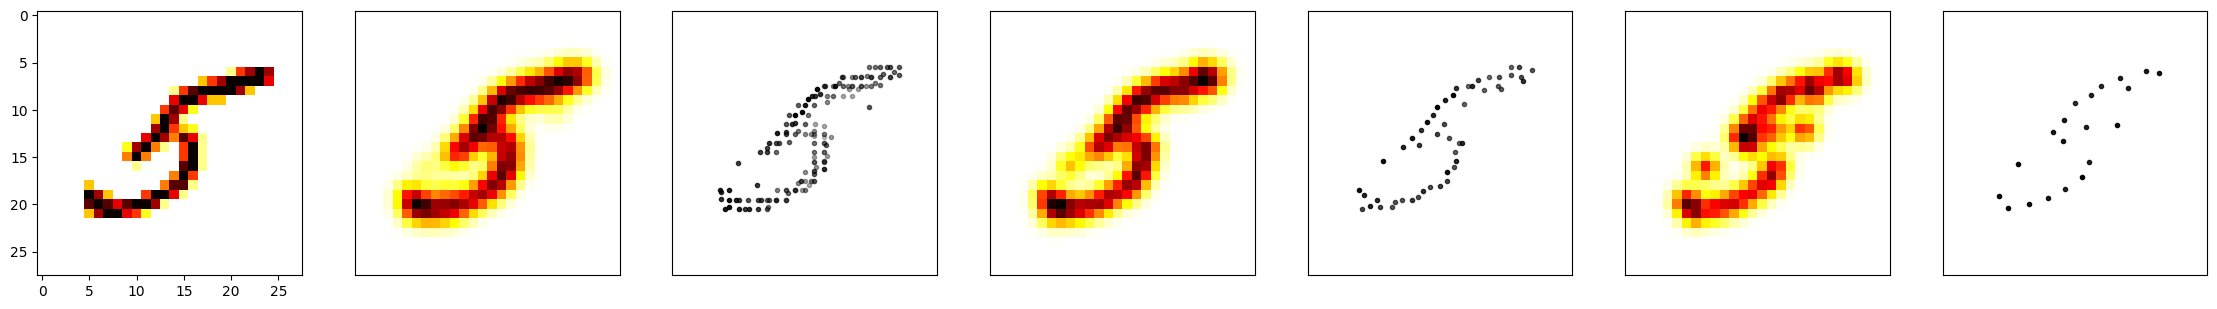

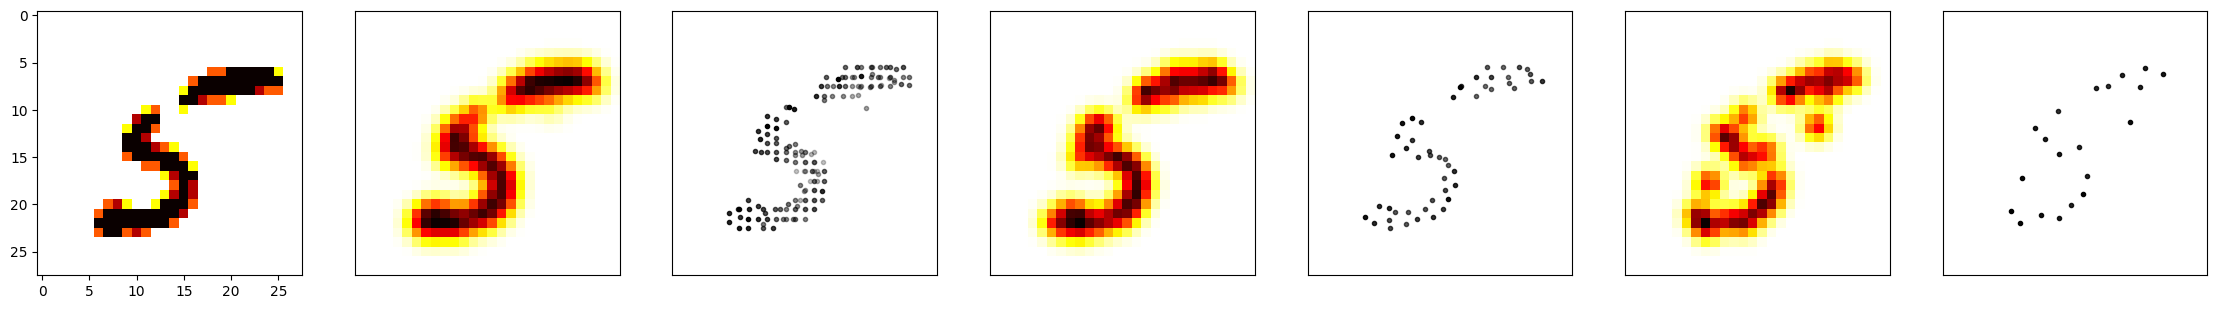

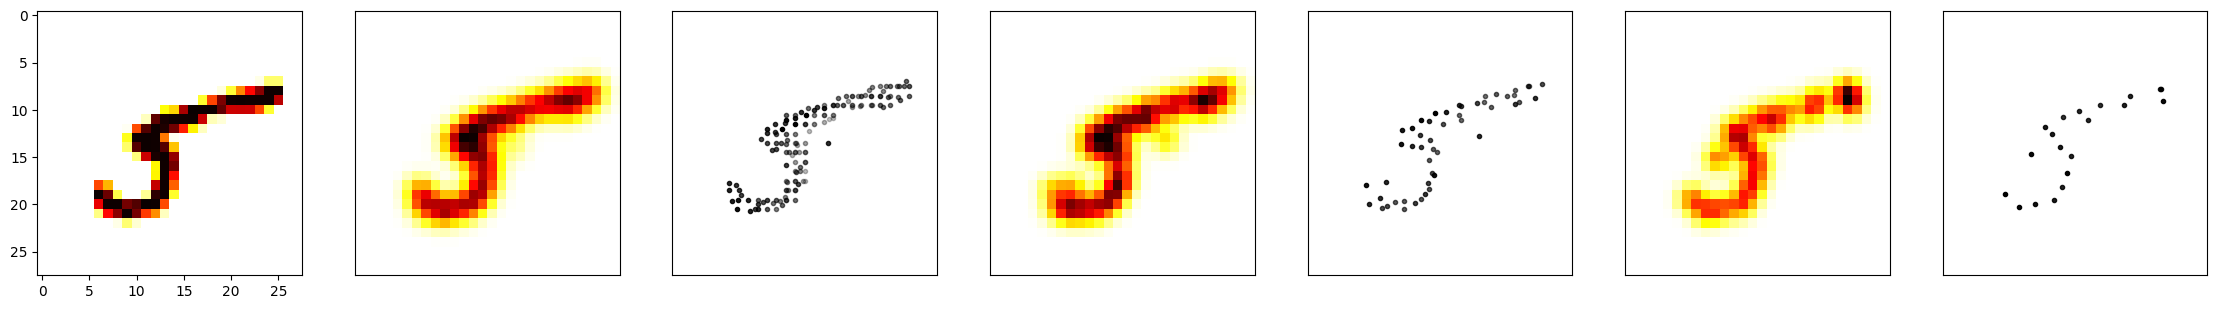

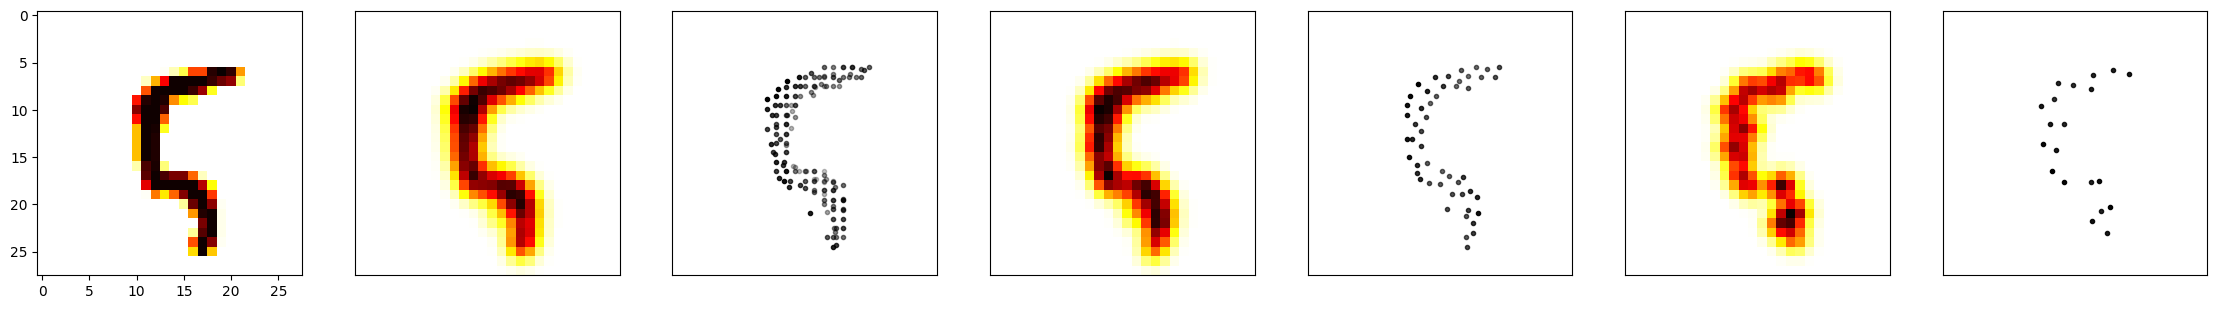

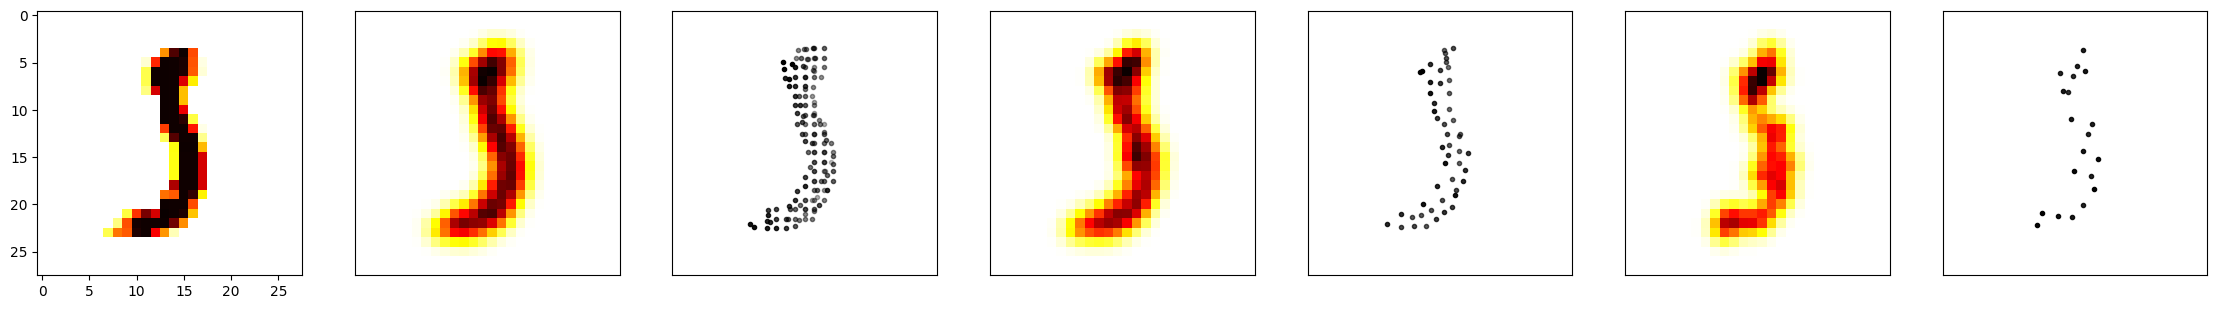

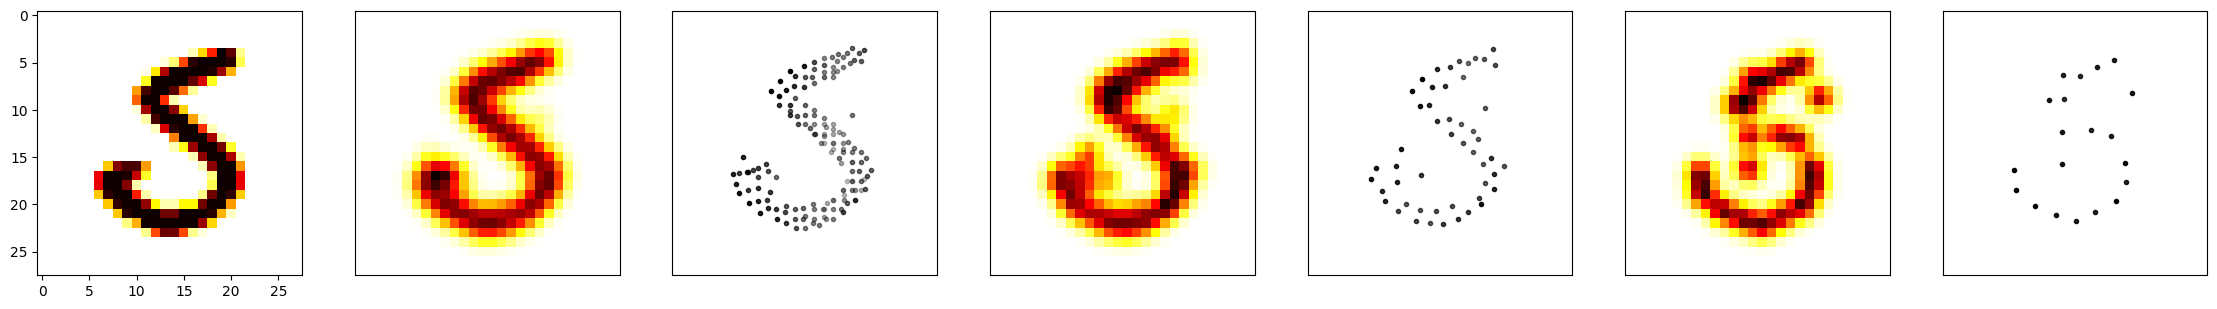

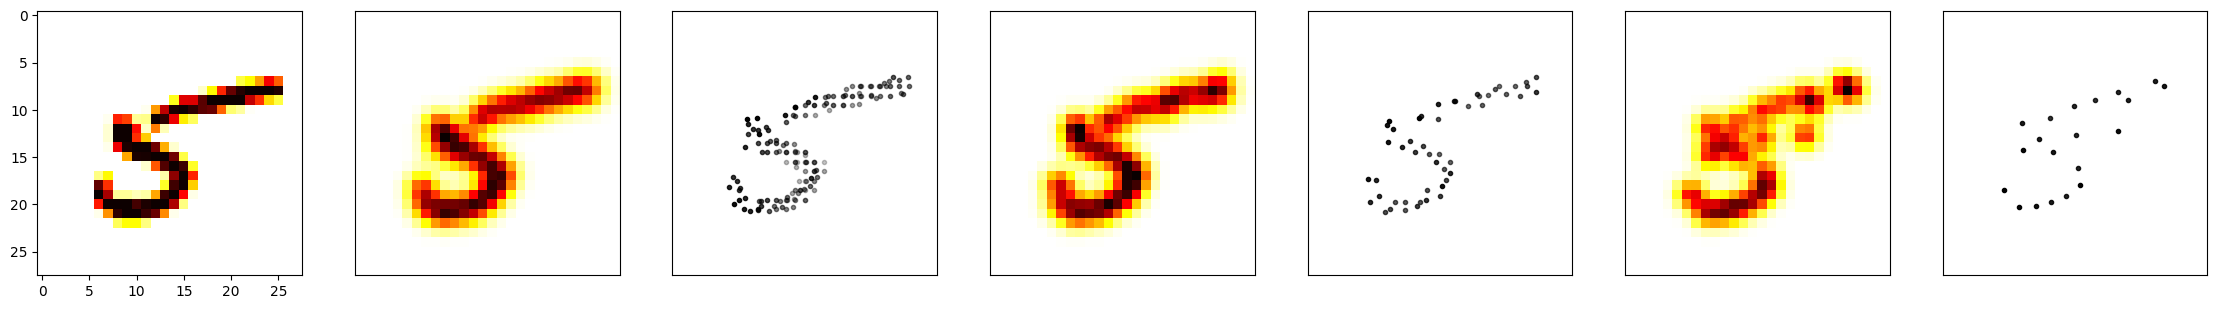

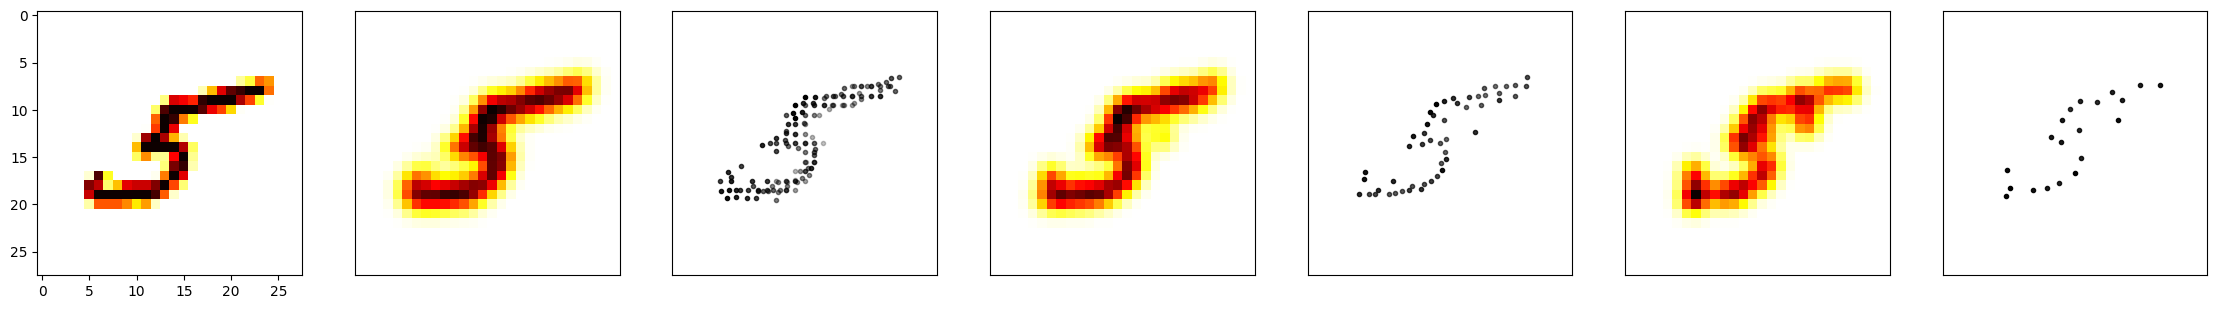

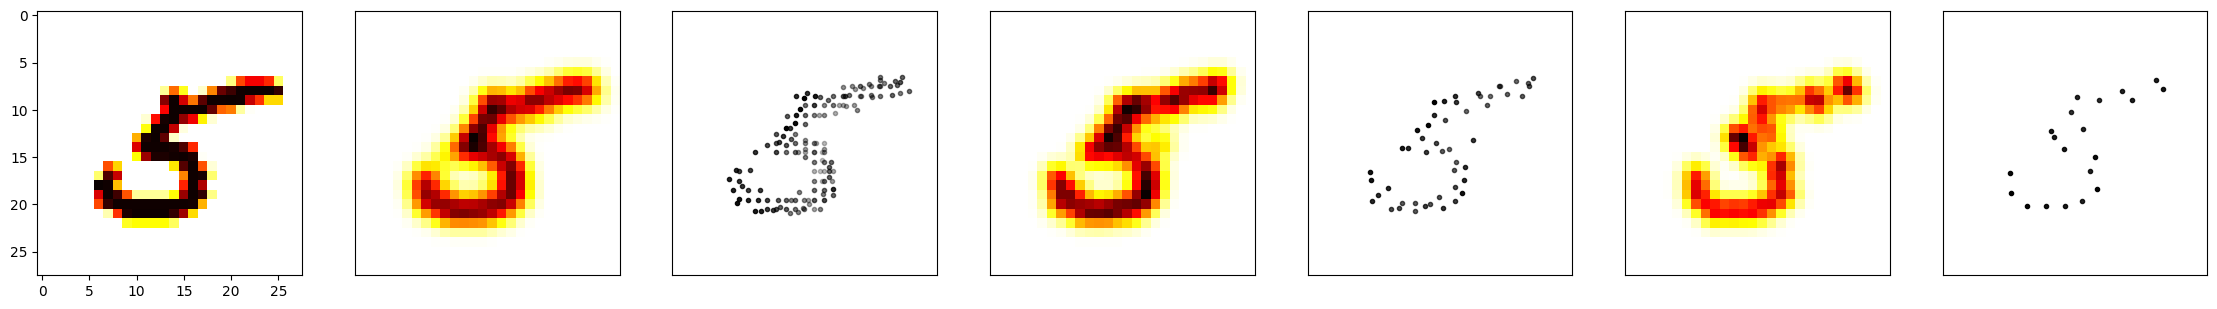

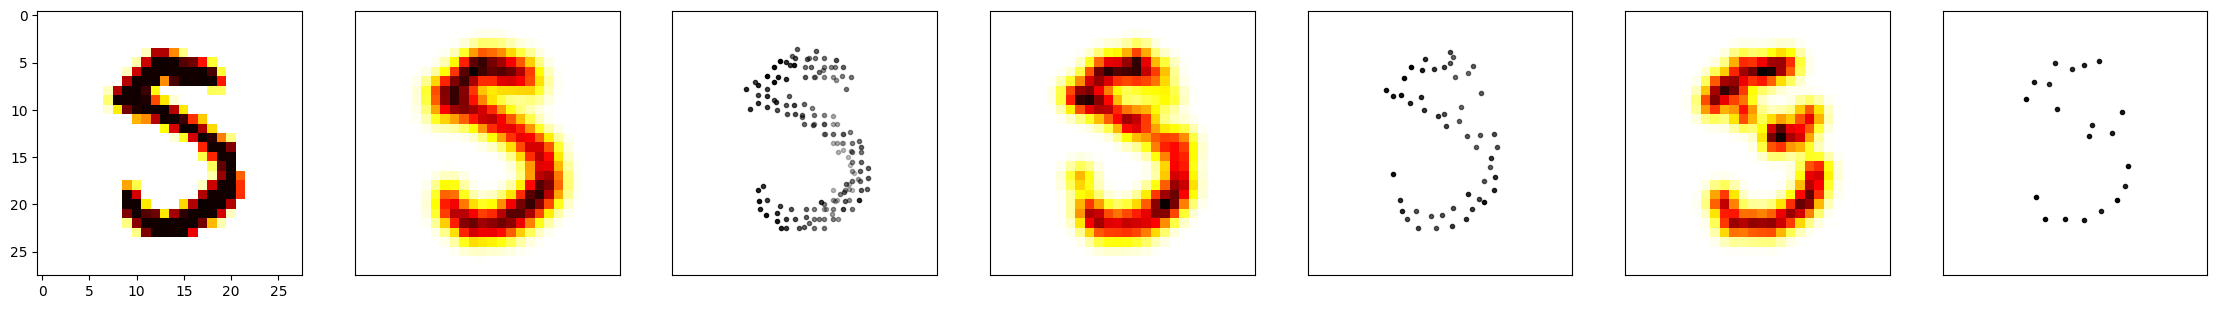

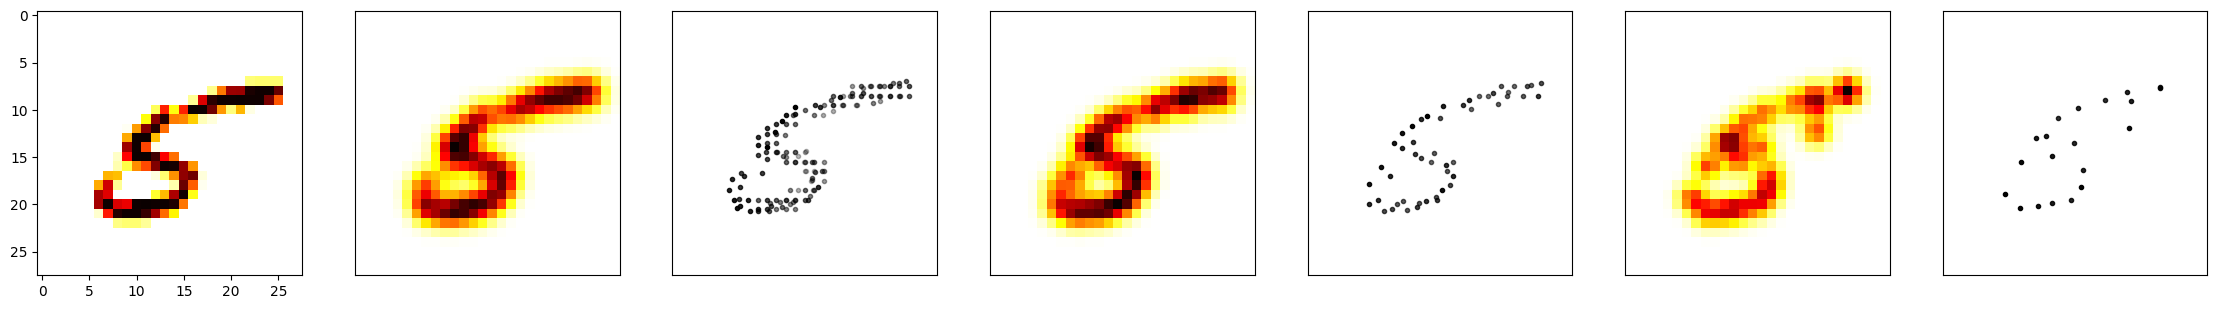

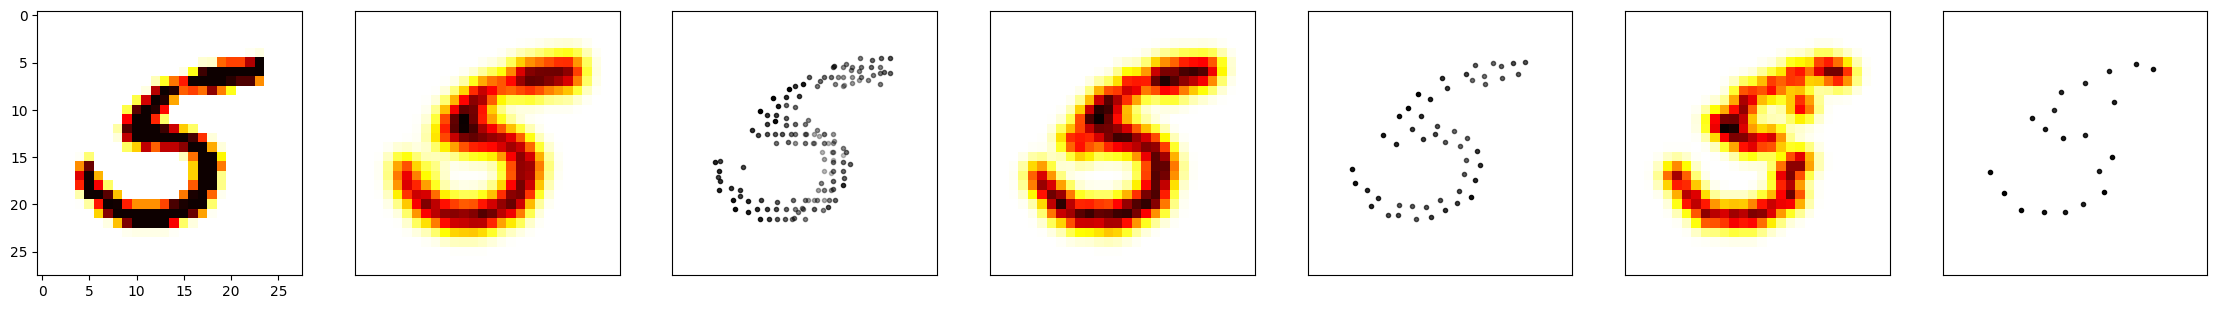

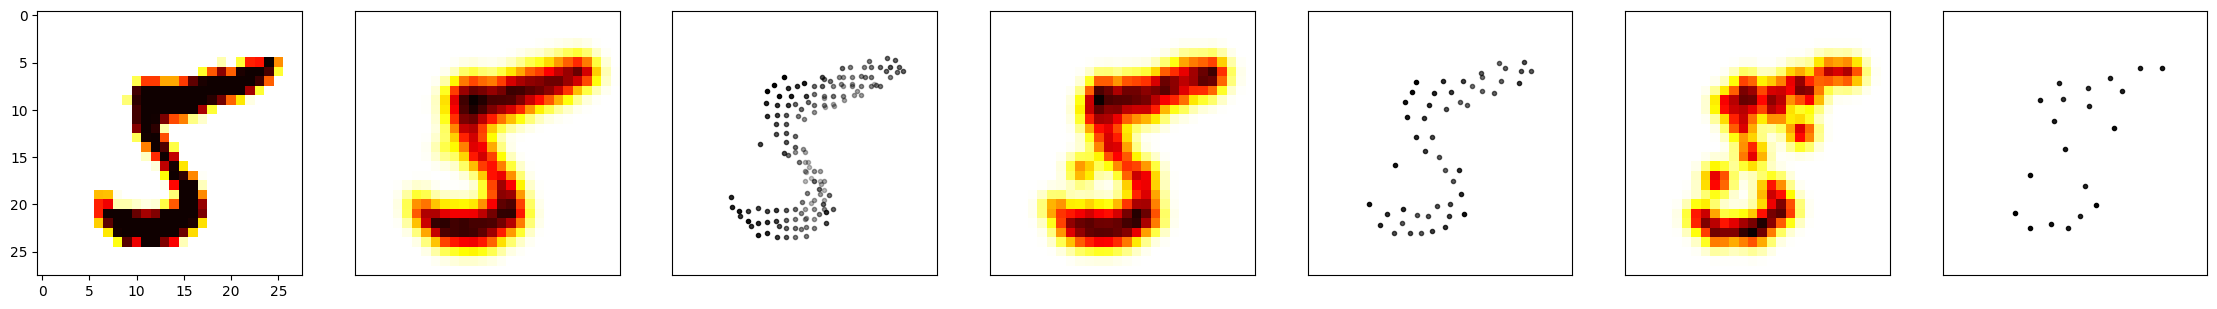

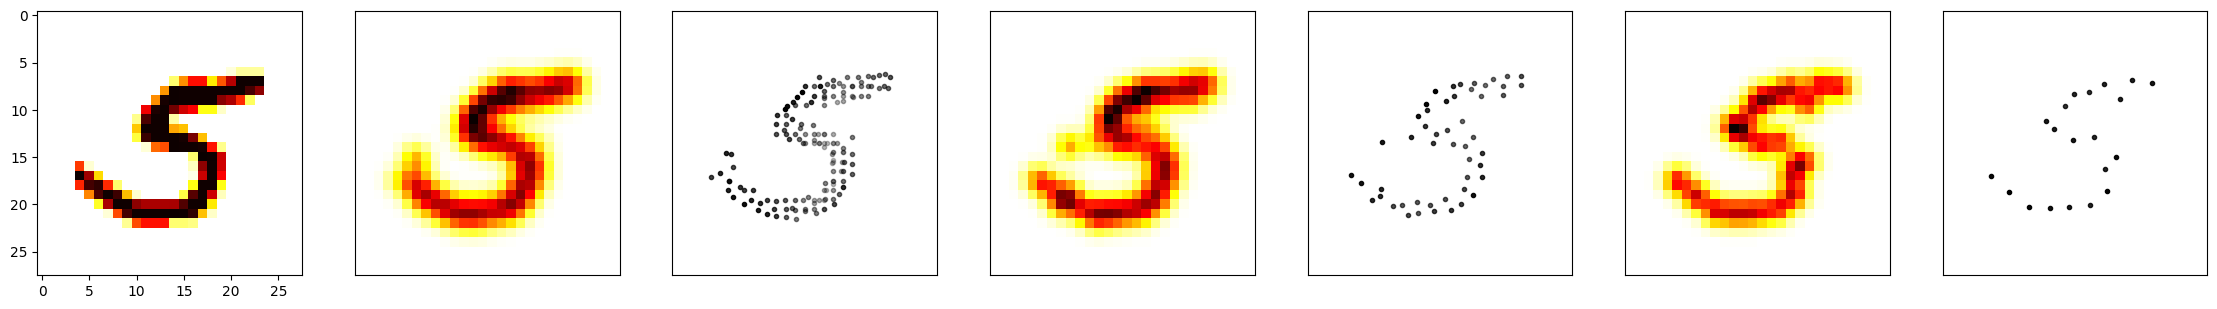

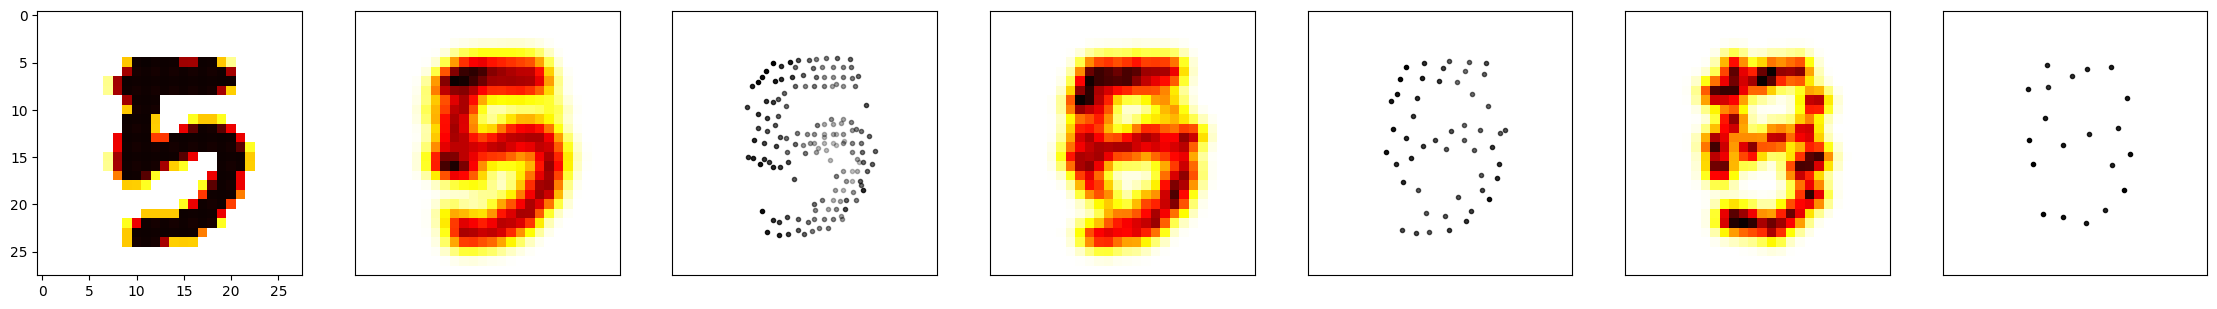

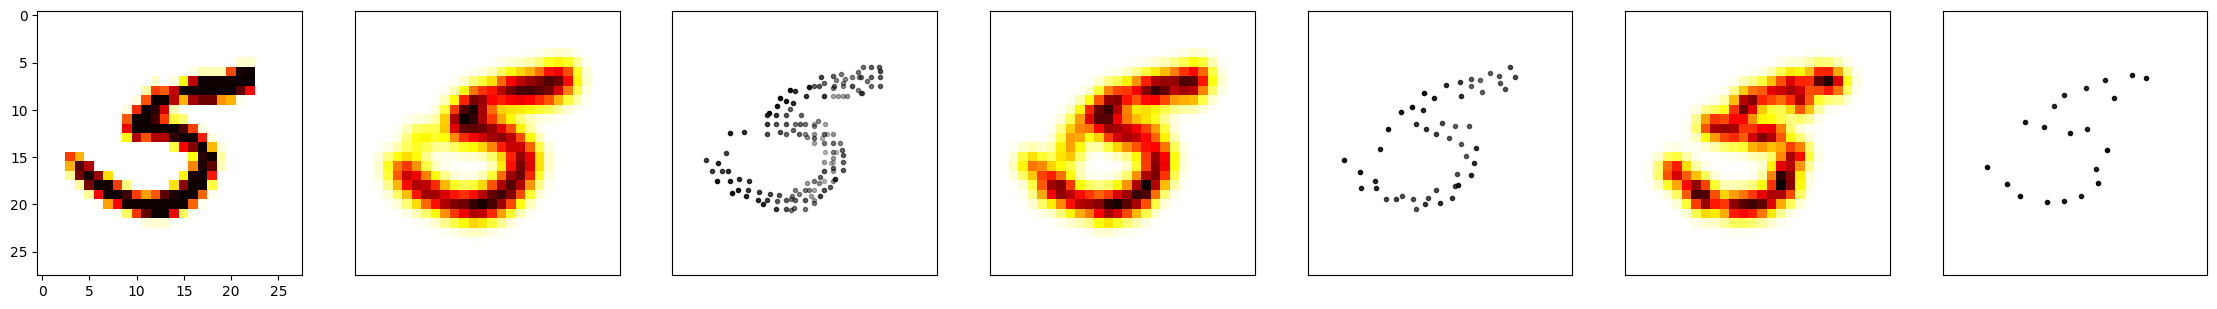

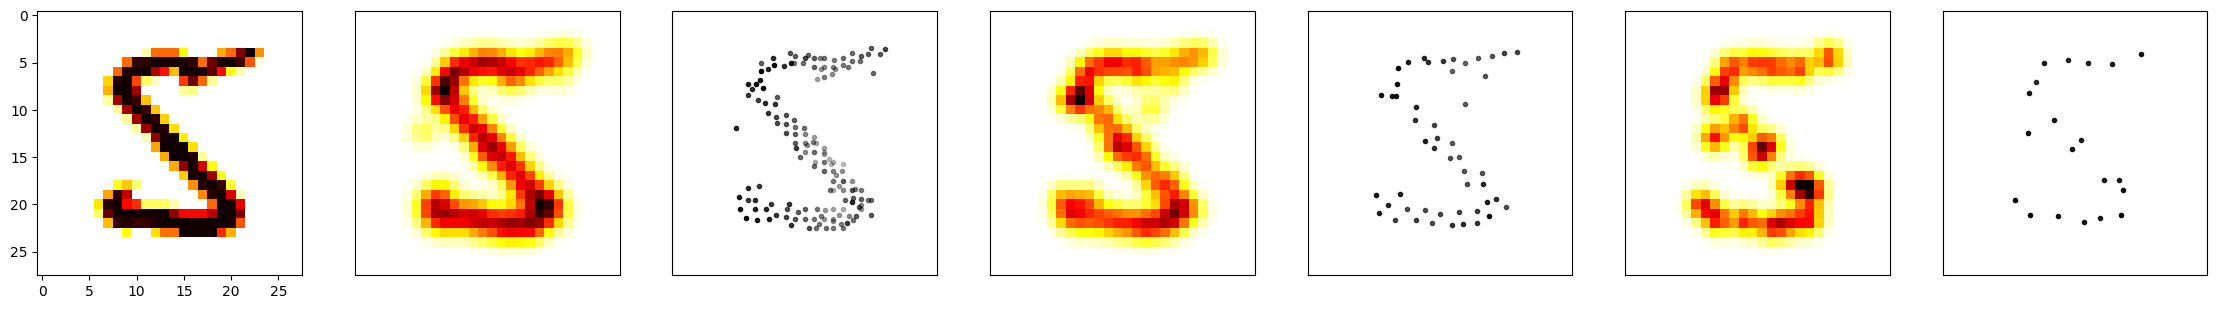

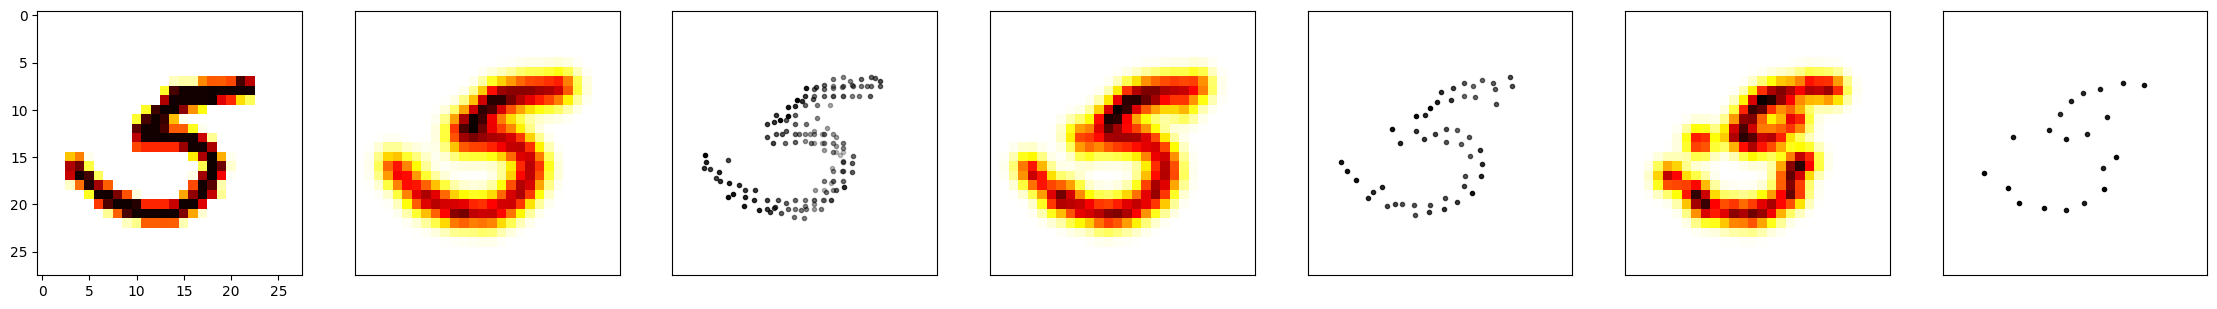

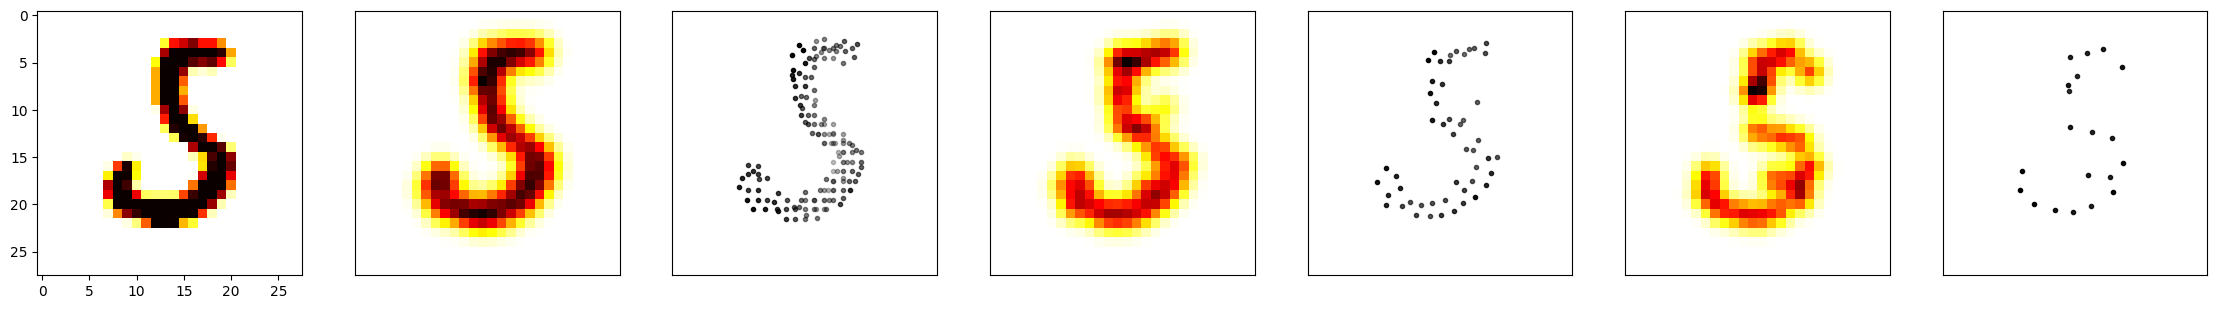

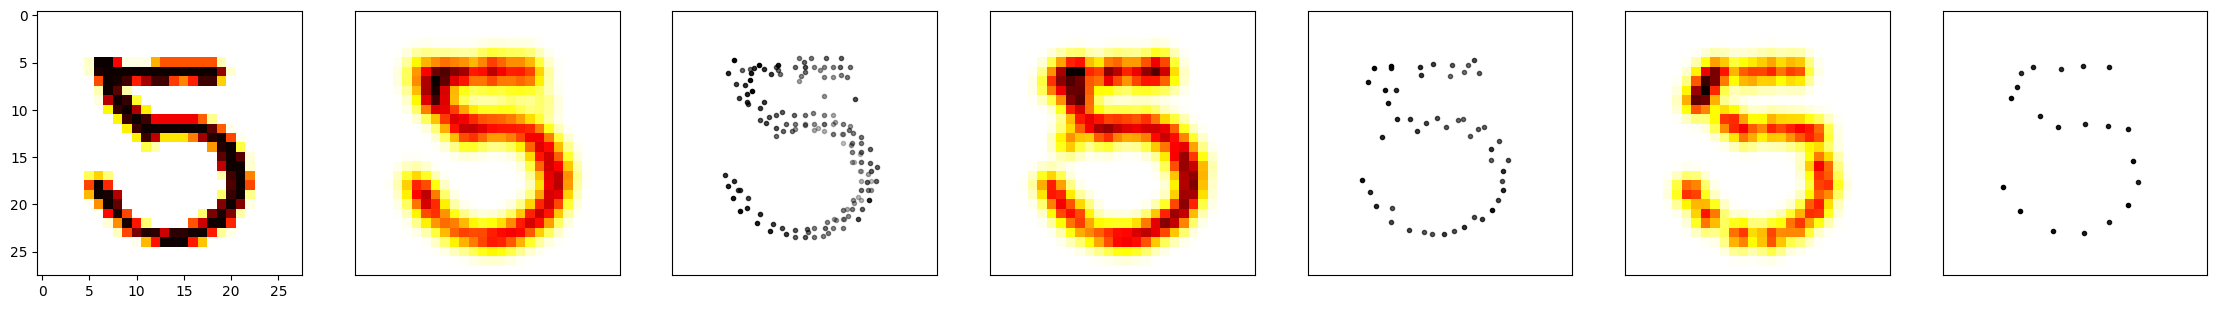

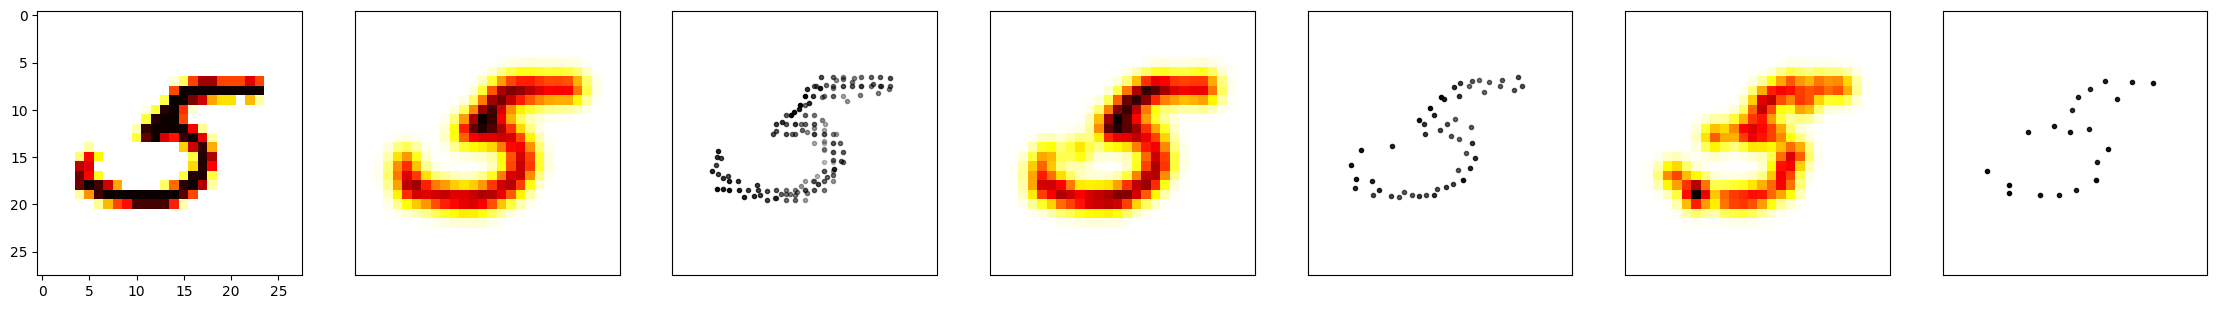

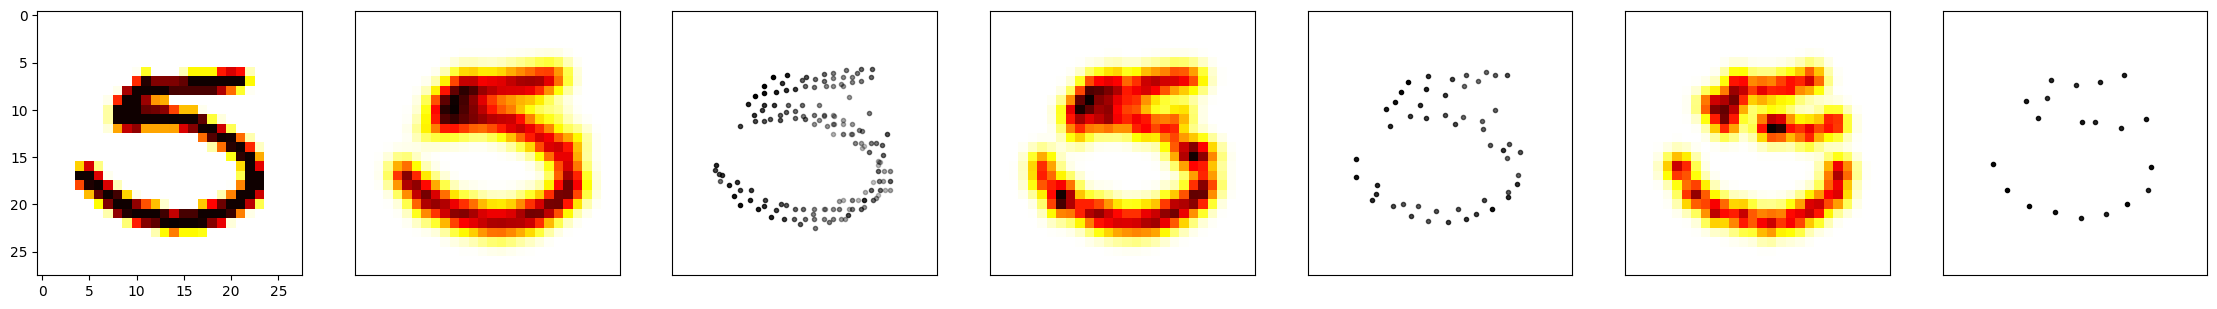

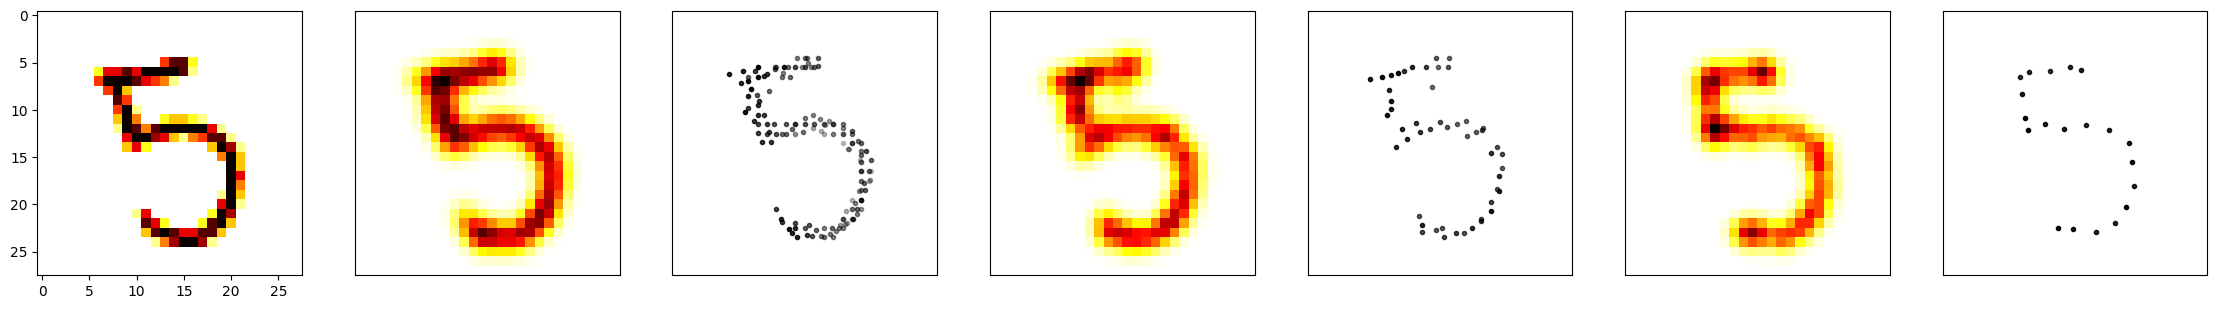

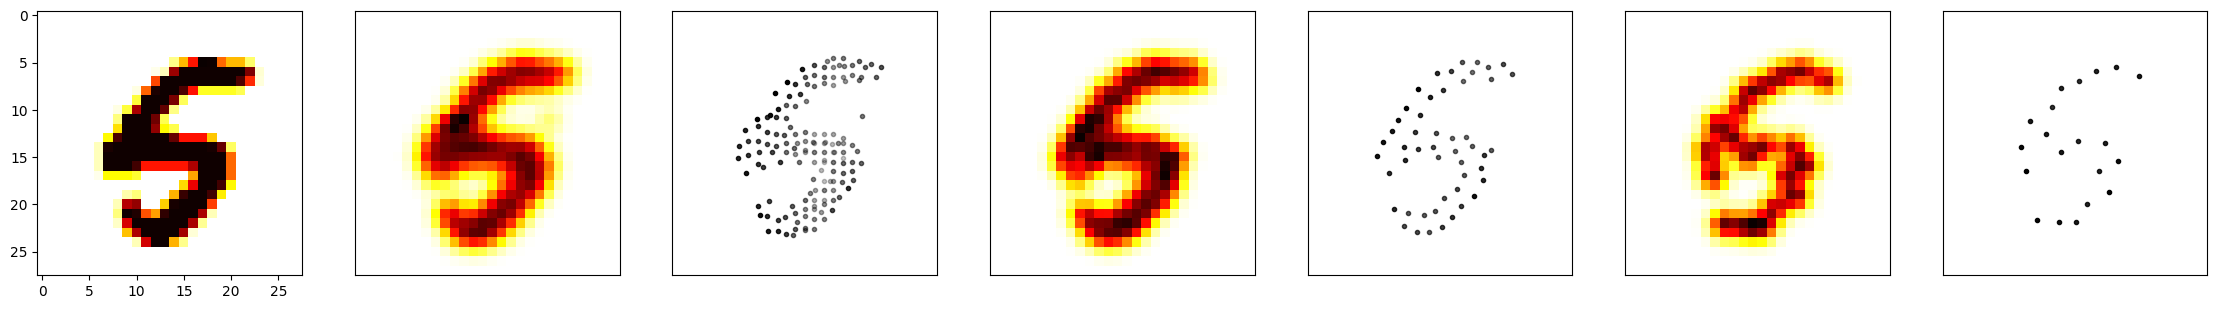

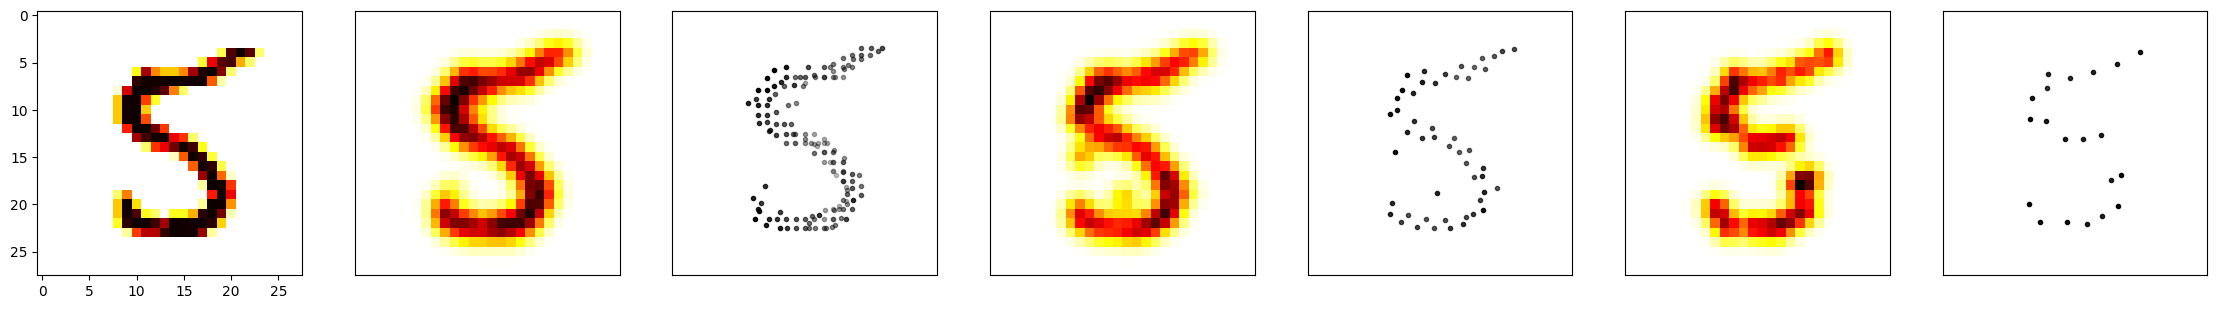

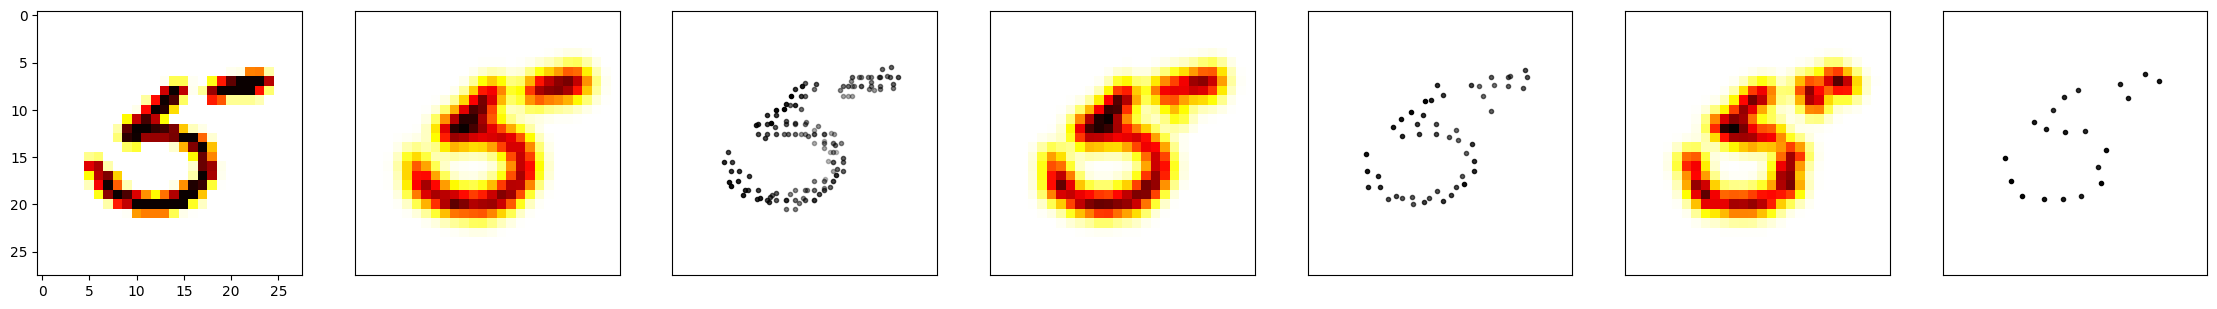

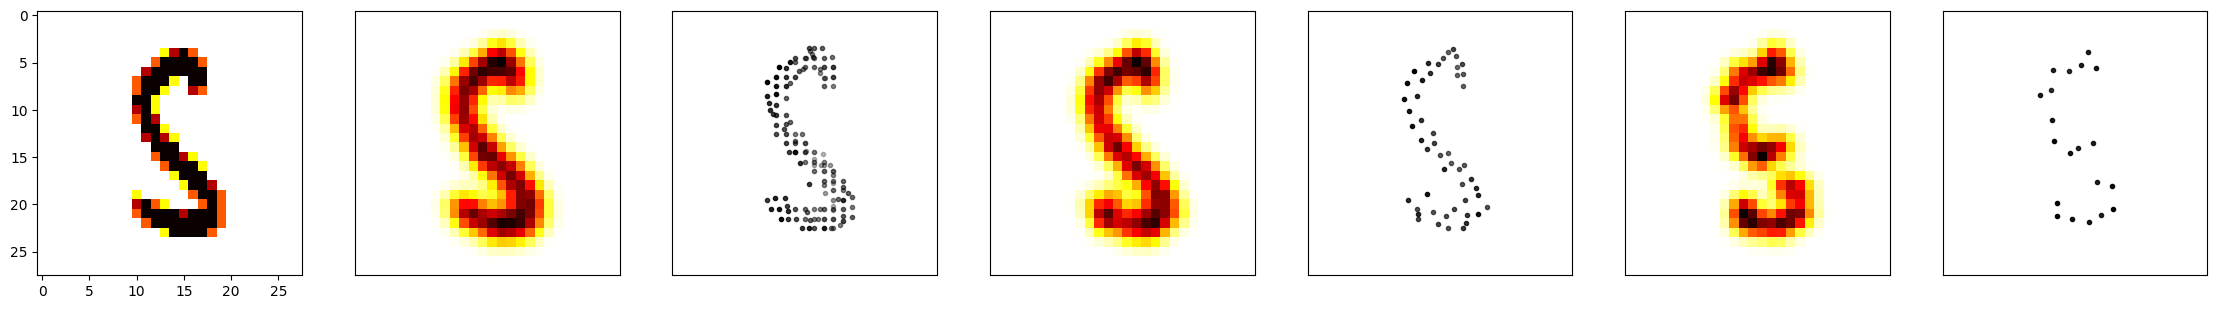

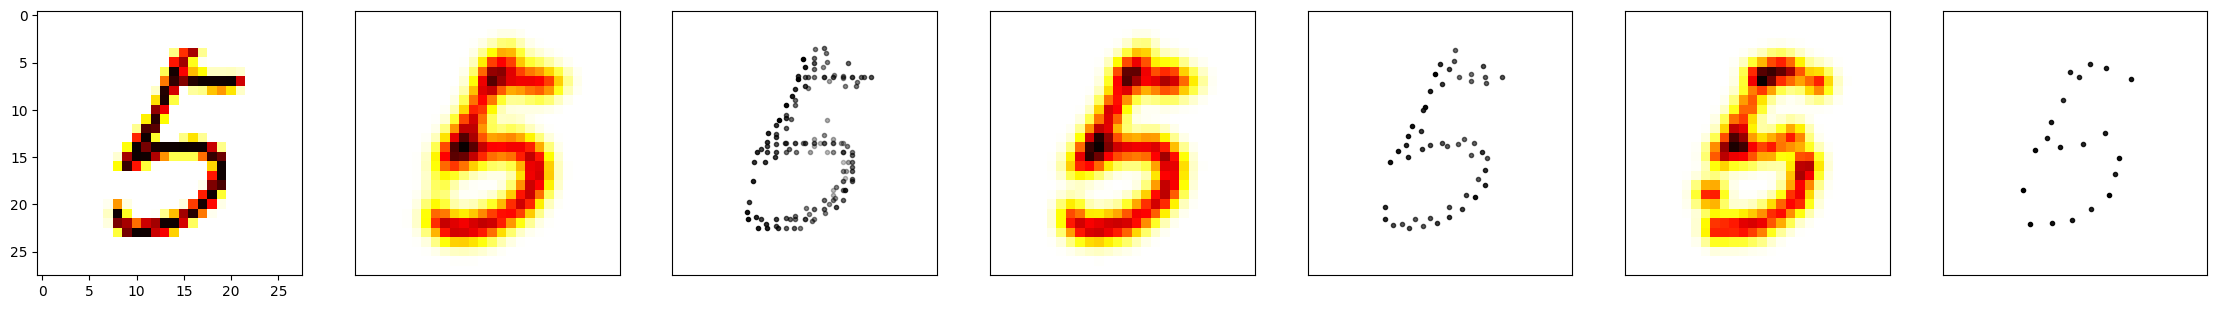

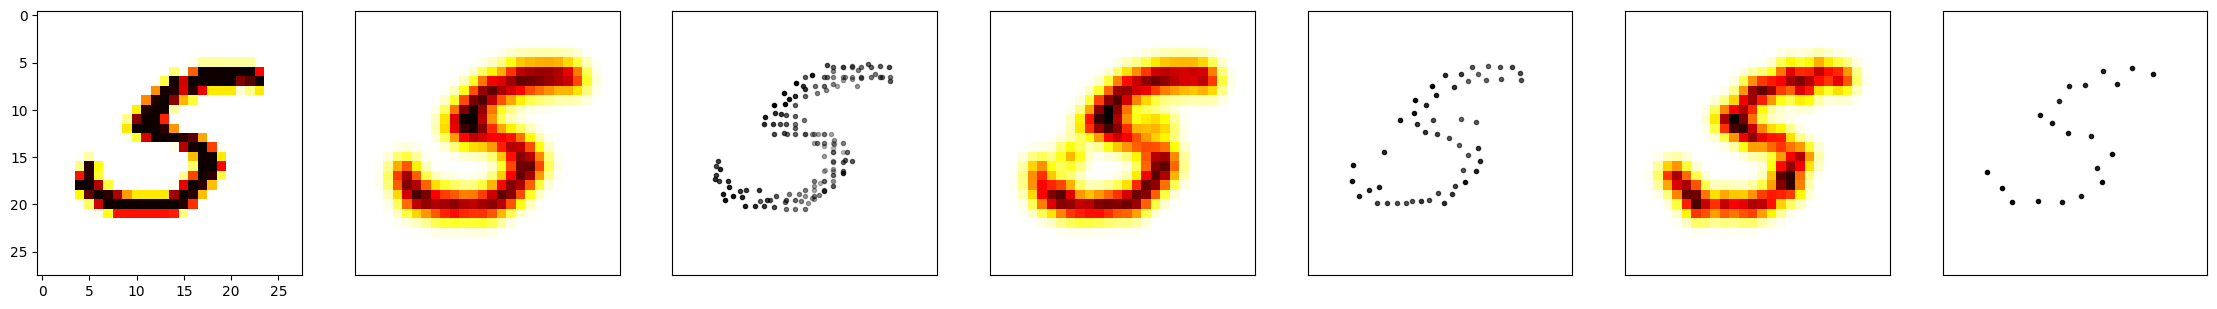

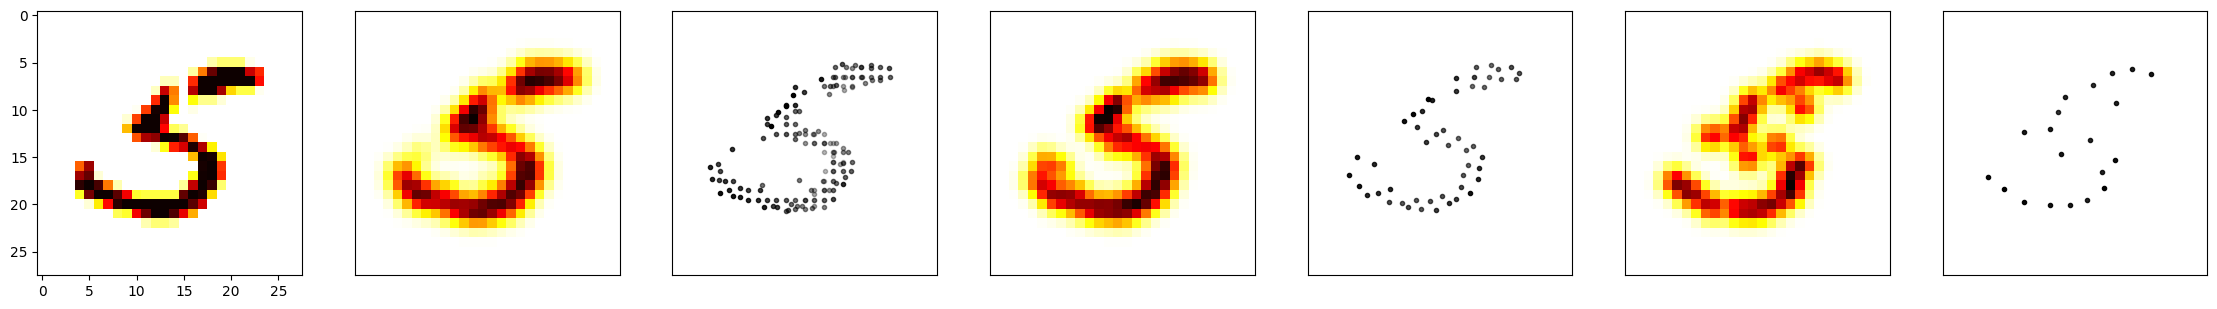

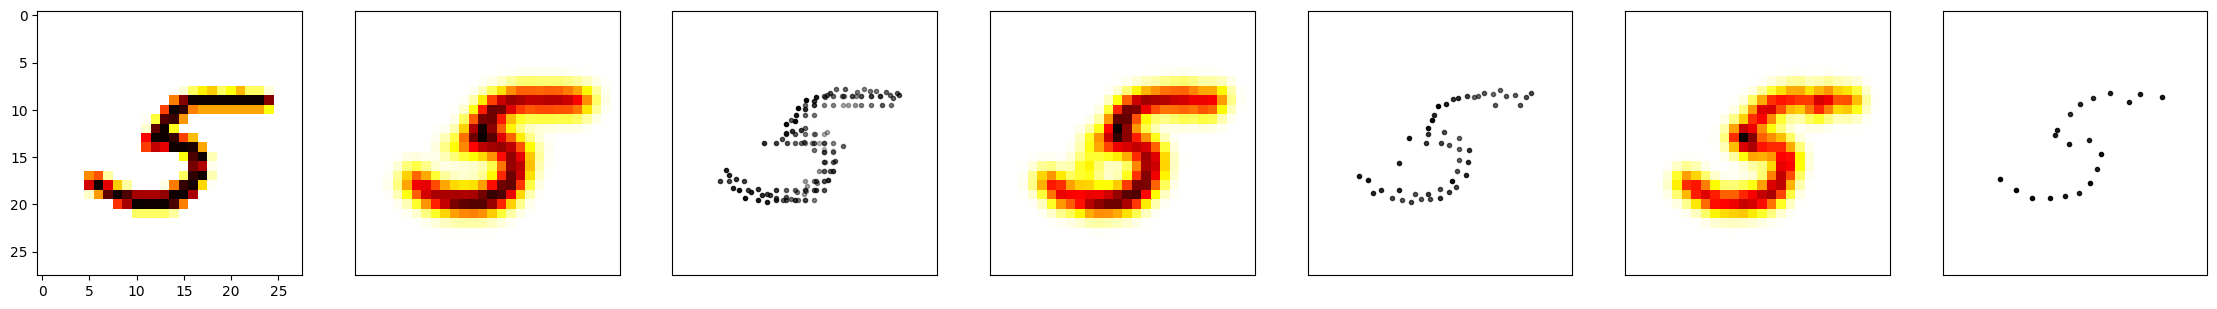

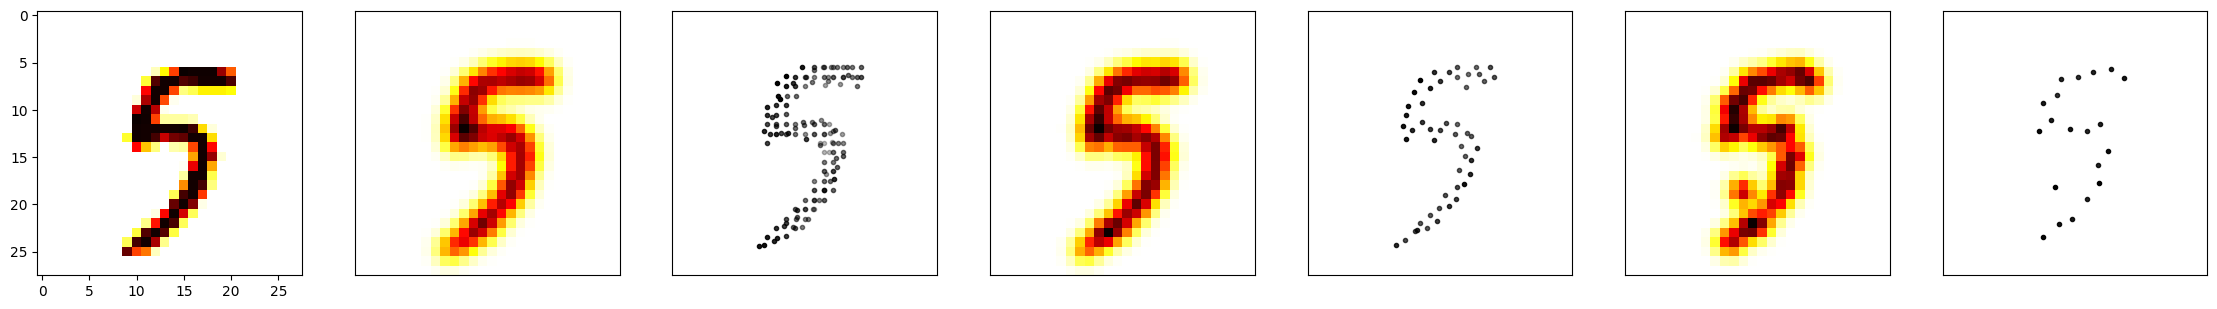

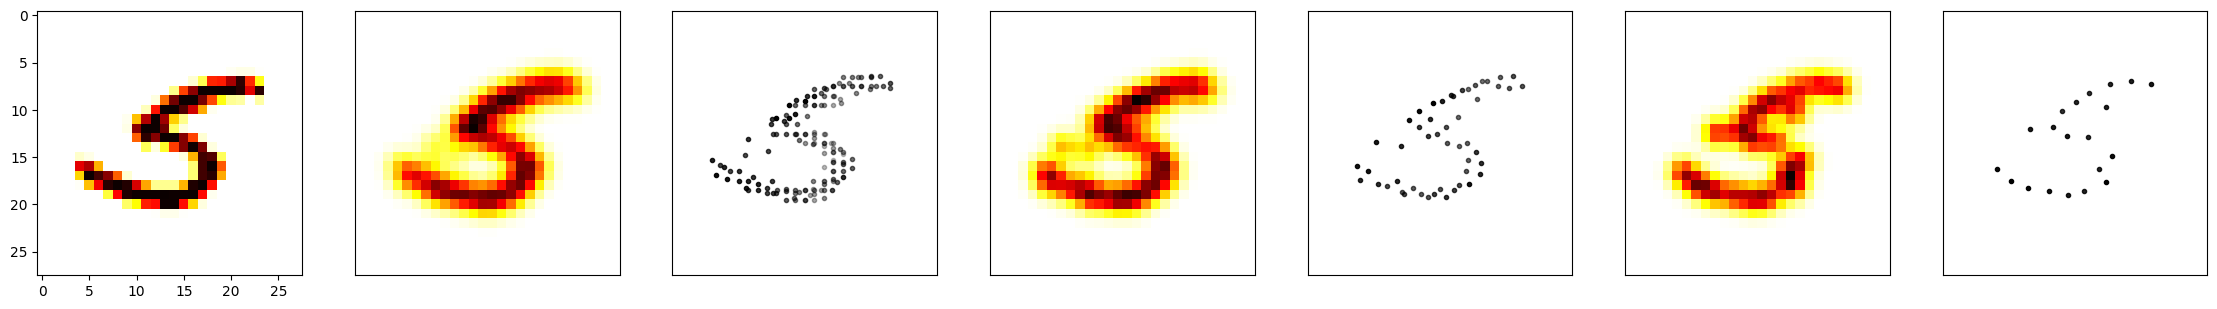

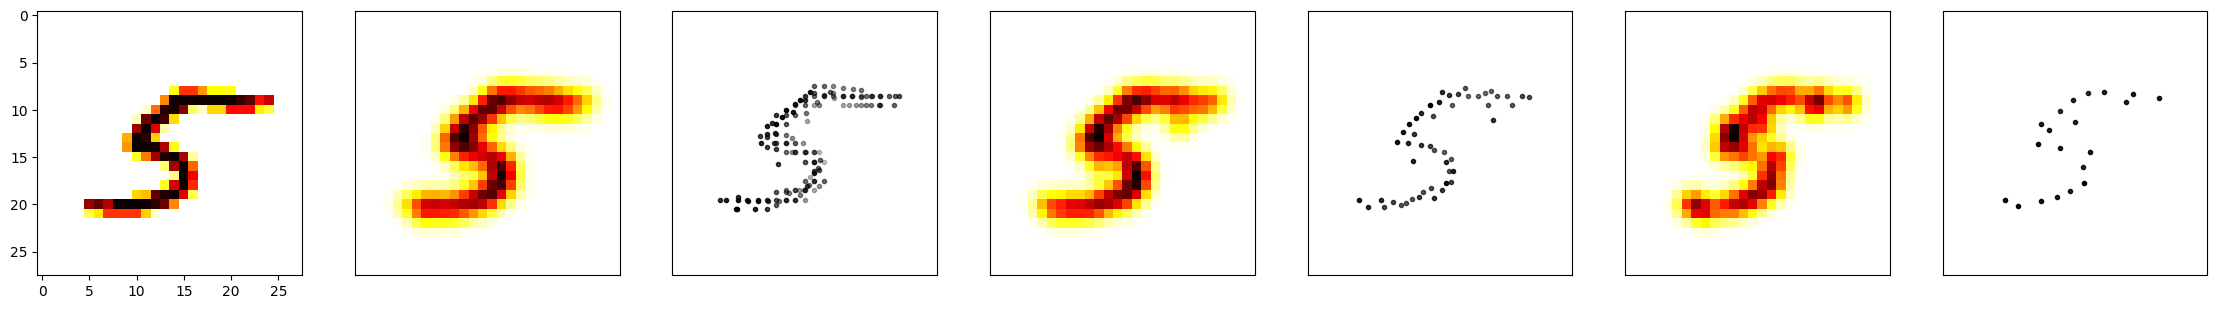

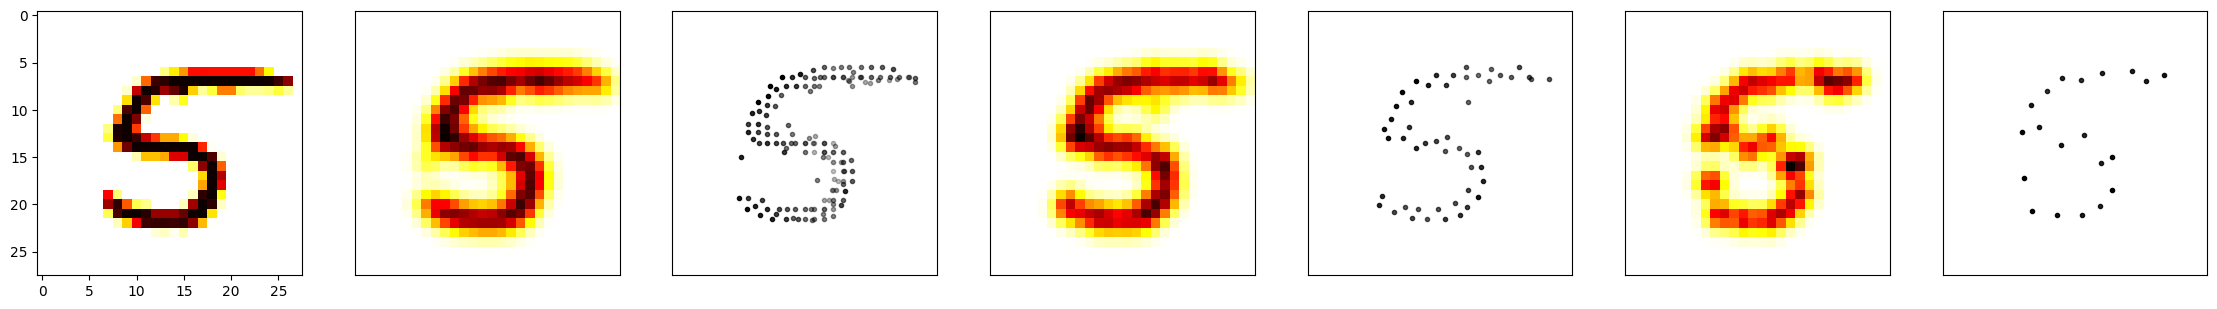

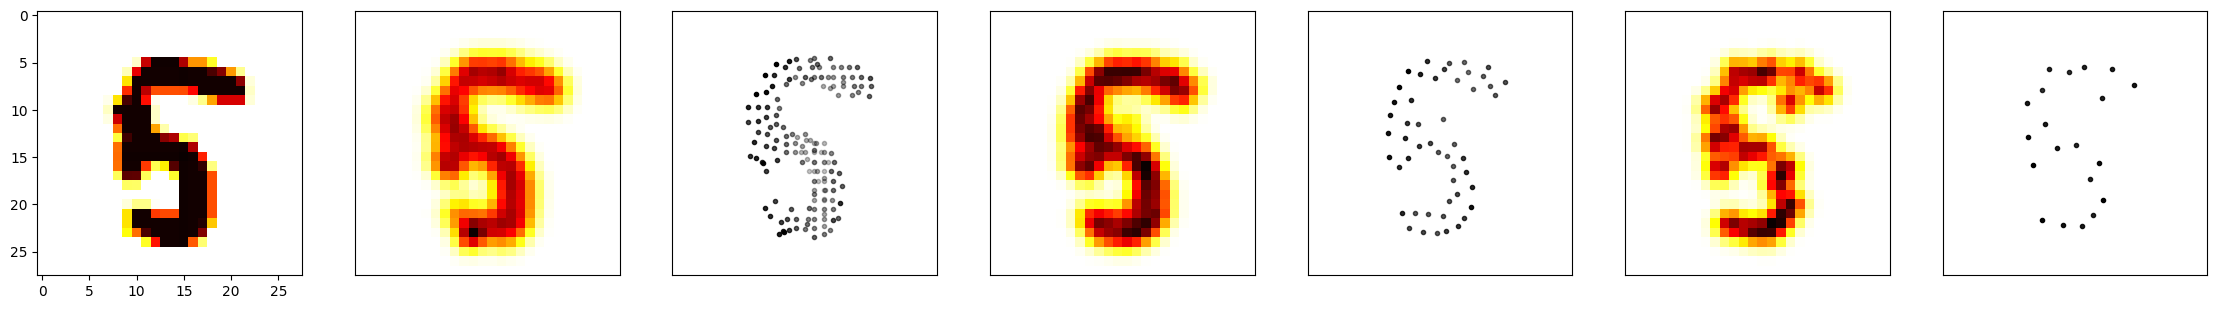

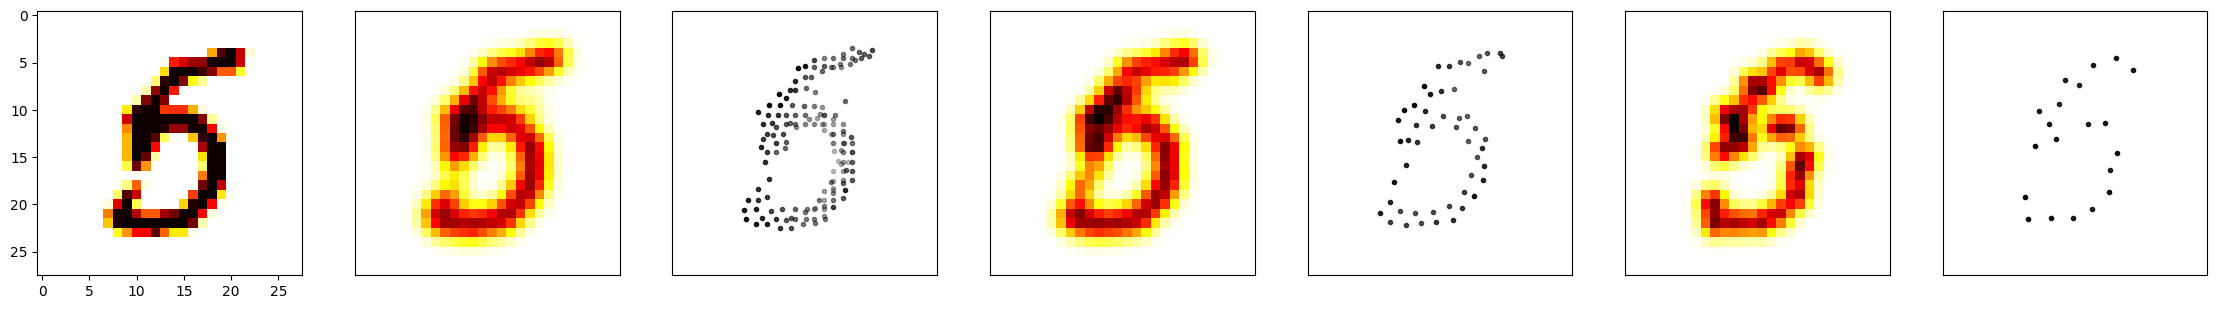

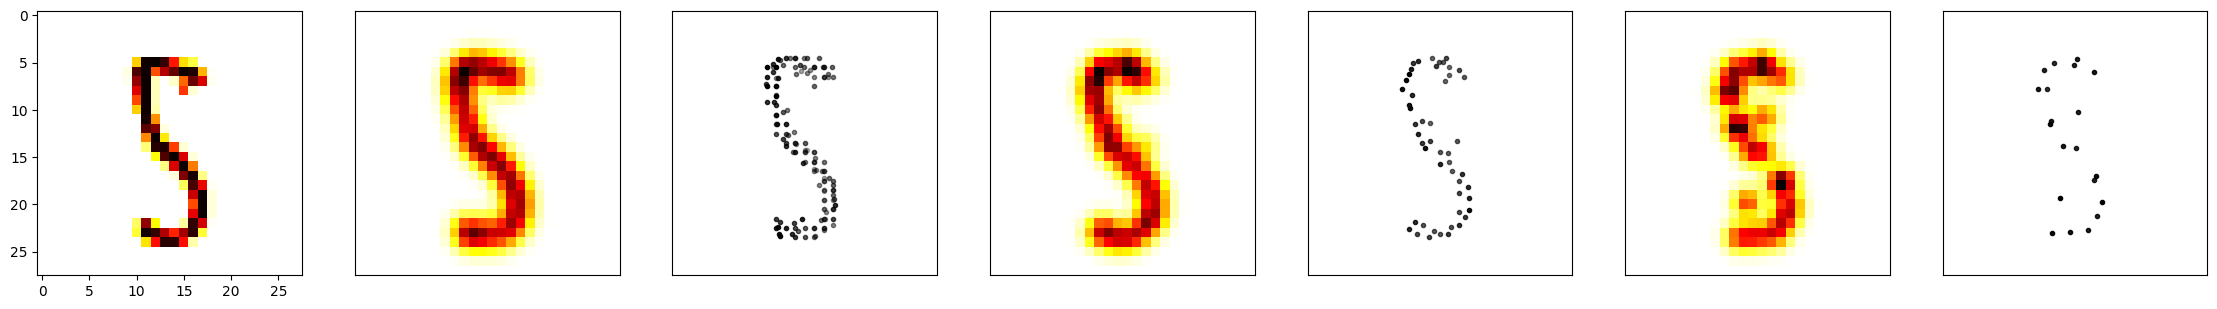

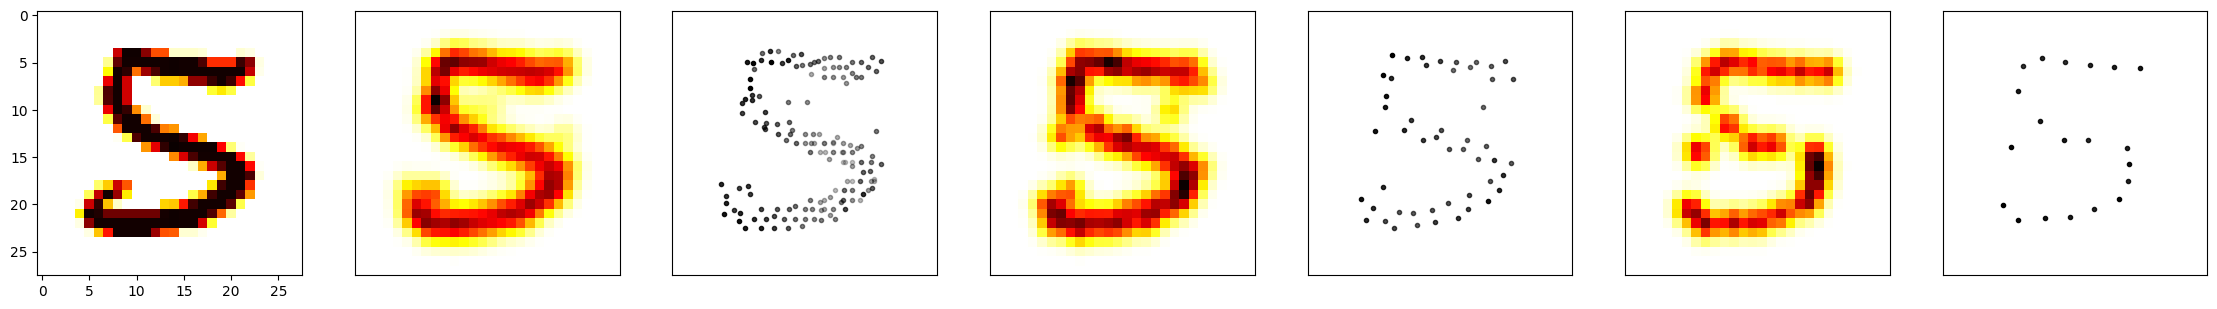

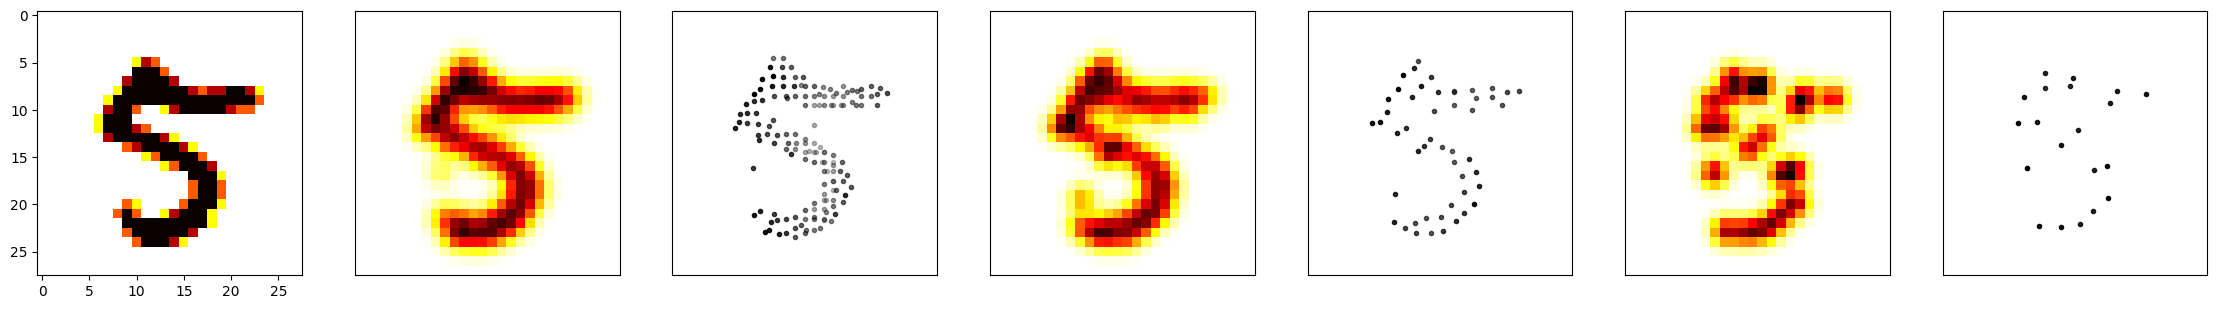

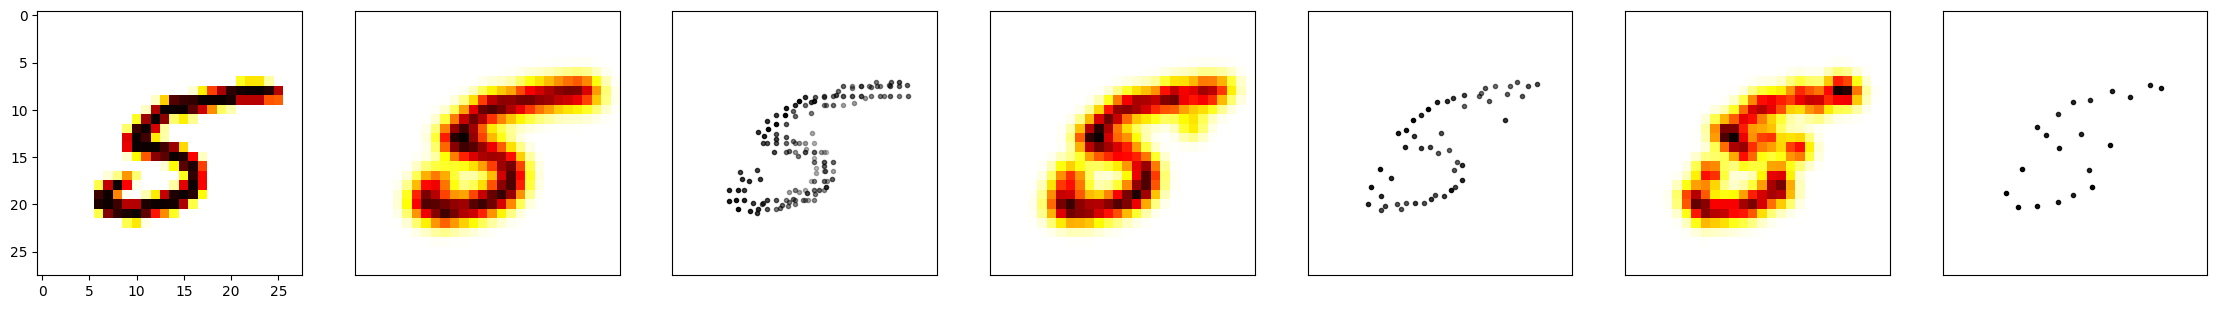

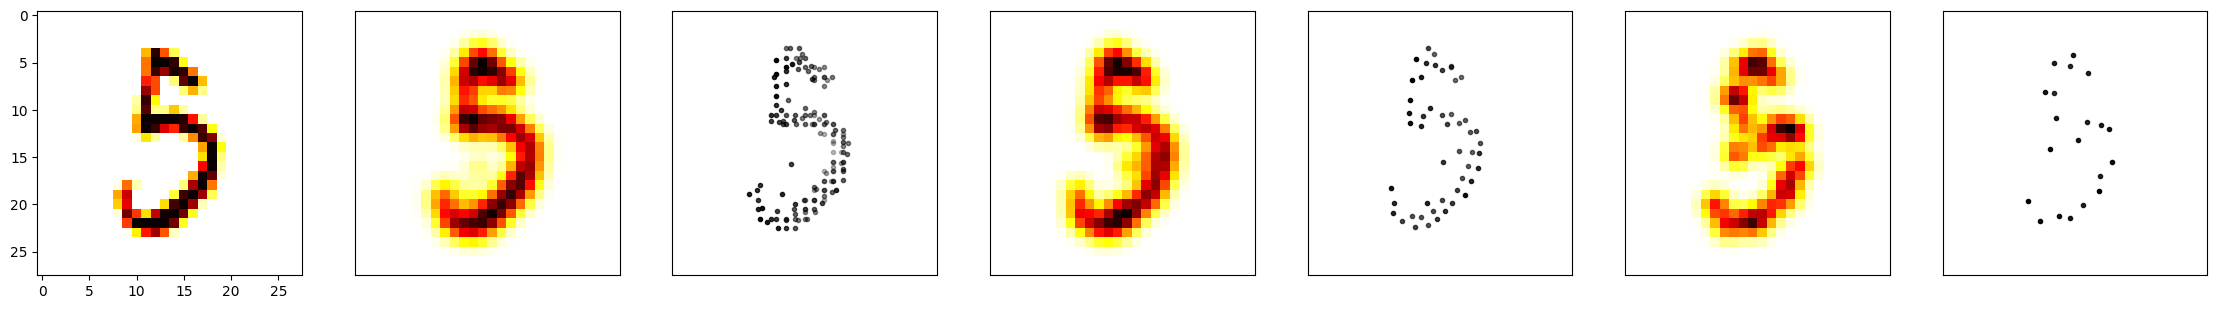

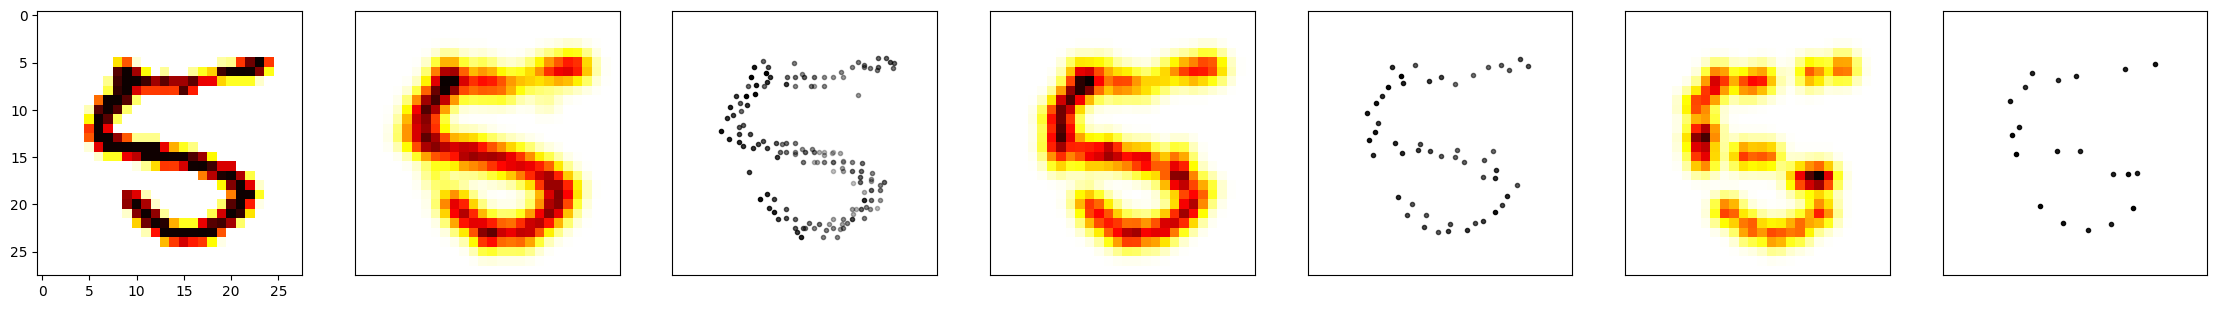

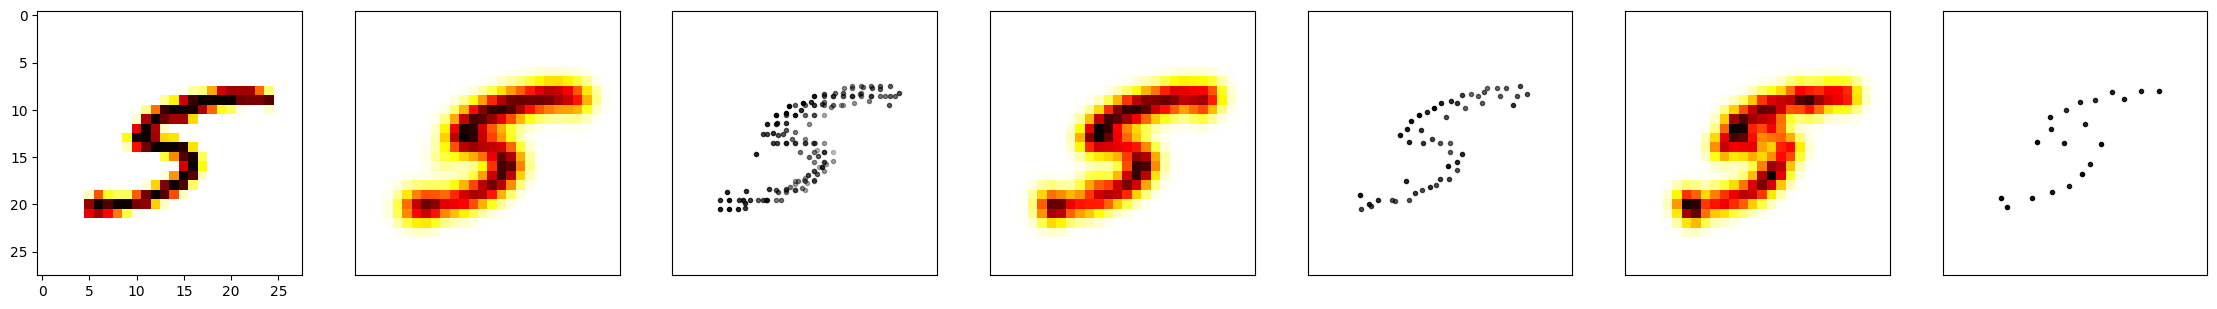

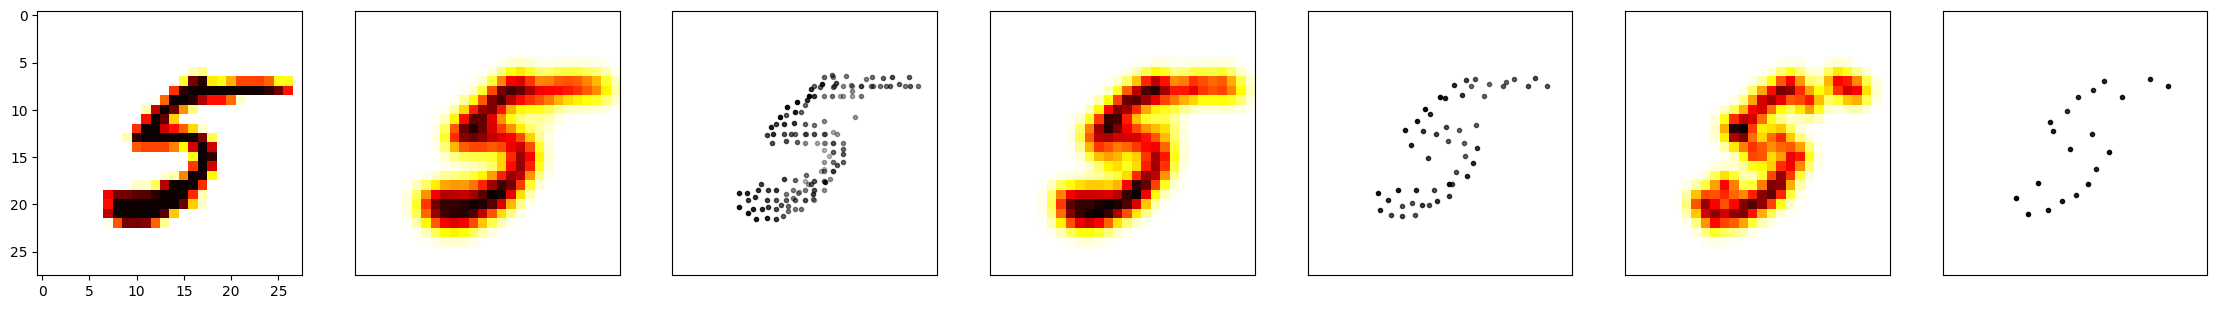

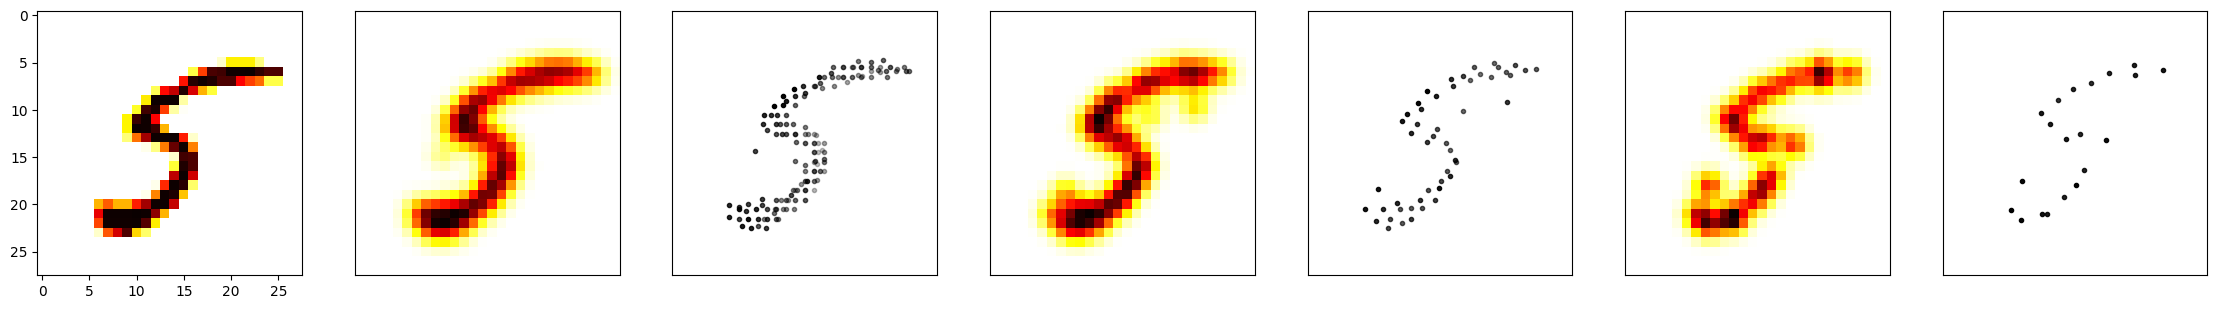

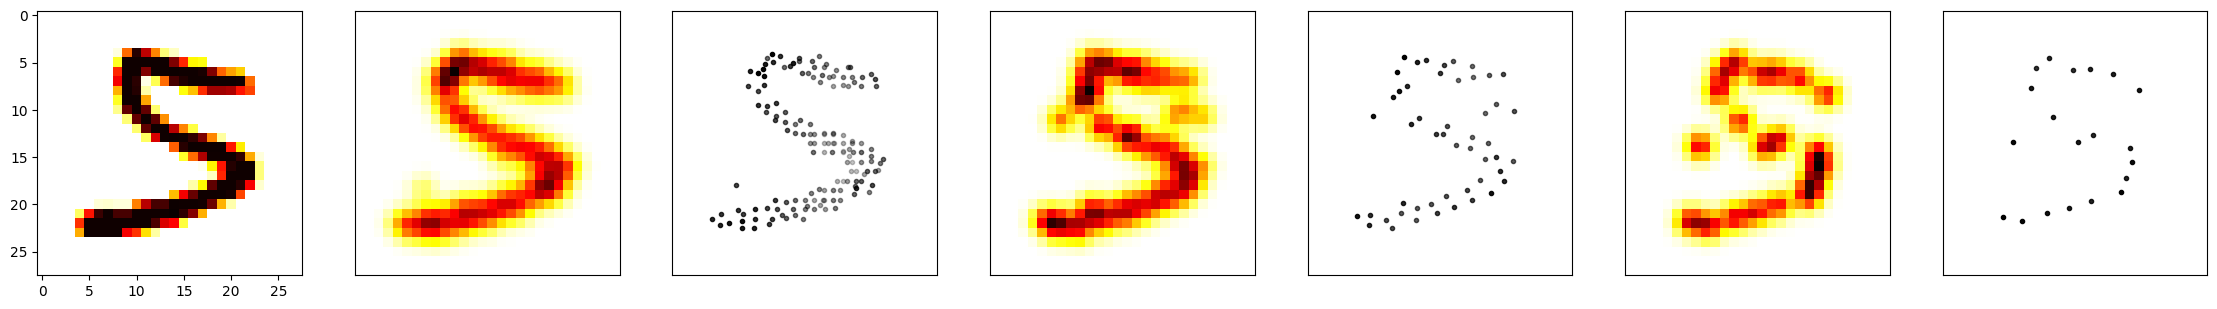

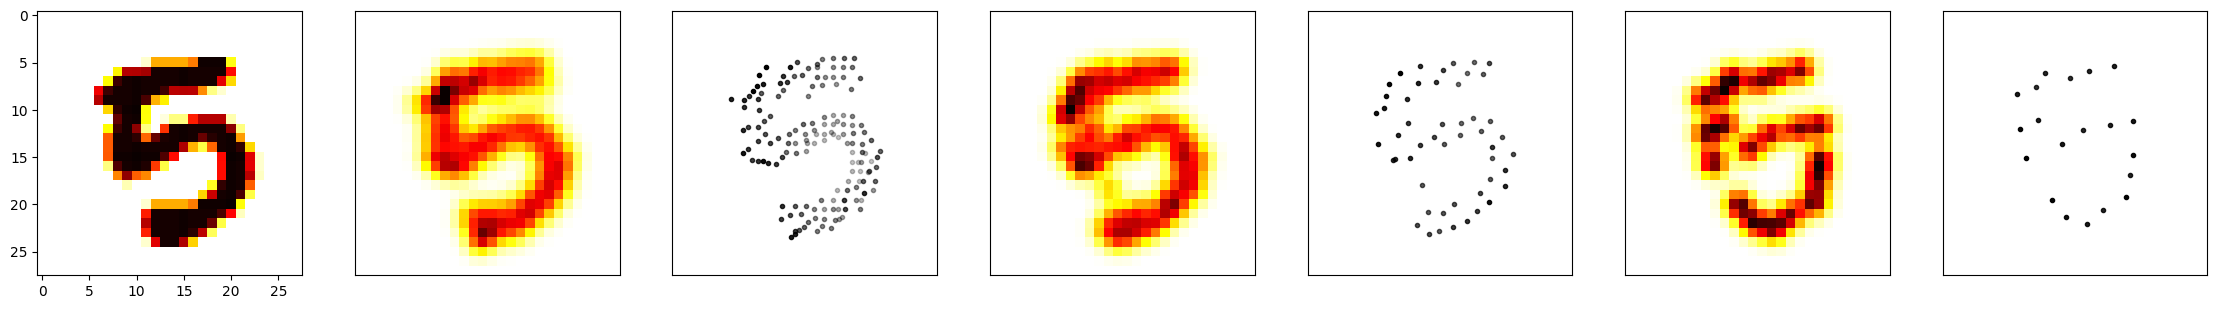

In [13]:
for i in range(50):
    
    plt.figure(figsize=(28,4))

    test0 = measure_list[i]

    plt.subplot(1,7,1)
    plt.imshow(image_list[i], cmap =cm.hot_r)

    plt.subplot(1,7,2)
    test = measure(barycenter_150.weights, np.diag(1/barycenter_150.weights)@ot.emd(barycenter_150.weights, test0.weights, cdist(barycenter_150.locations,test0.locations))@test0.locations)
    test.plot_density()

    plt.subplot(1,7,3)
    test.plot_locations()

    plt.subplot(1,7,4)
    test = measure(barycenter_50.weights, np.diag(1/barycenter_50.weights)@ot.emd(barycenter_50.weights, test0.weights, cdist(barycenter_50.locations,test0.locations))@test0.locations)
    test.plot_density()

    plt.subplot(1,7,5)
    test.plot_locations()

    plt.subplot(1,7,6)
    test = measure(barycenter_20.weights, np.diag(1/barycenter_20.weights)@ot.emd(barycenter_20.weights, test0.weights, cdist(barycenter_20.locations,test0.locations))@test0.locations)
    test.plot_density()

    plt.subplot(1,7,7)
    test.plot_locations()

    plt.show()

In [14]:
test0.locations.shape

(784, 2)

In [15]:
barycenter_150.locations.shape

(150, 2)

In [ ]:
# test0 = measure_list[i]

# Pi = ot.emd(barycenter_150.weights, test0.weights, cdist(barycenter_150.locations,test0.locations))

# for t in np.arange(0,4,.01):
#     test = measure(barycenter_150.weights, ( t*(np.diag(1/barycenter_150.weights)@ot.emd(barycenter_150.weights, test0.weights, cdist(barycenter_150.locations,test0.locations))@test0.locations)+ (1-t)*(barycenter_150.locations) ) )
#     plt.figure(figsize=(12,6))
#     plt.subplot(1,2,1)
#     test.plot_density()
#     plt.subplot(1,2,2)
#     test.plot_locations()
#     # plt.show()
#     plt.savefig("frames//frame"+str(int(100*t))+".png")

In [ ]:
# test0 = measure_list[34]

# Pi = ot.emd(barycenter_20.weights, test0.weights, cdist(barycenter_20.locations,test0.locations))

# for t in np.arange(0,4,.01):
#     test = measure(barycenter_20.weights, ( t*(np.diag(1/barycenter_20.weights)@ot.emd(barycenter_20.weights, test0.weights, cdist(barycenter_20.locations,test0.locations))@test0.locations)+ (1-t)*(barycenter_20.locations) ) )
#     plt.figure(figsize=(12,6))
#     plt.subplot(1,2,1)
#     test.plot_density()
#     plt.subplot(1,2,2)
#     test.plot_locations()
#     # plt.show()
#     plt.savefig("frames2//frame"+str(int(100*t))+".png")

C:\Users\micha\AppData\Local\Temp\ipykernel_1812\3946240295.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,6))


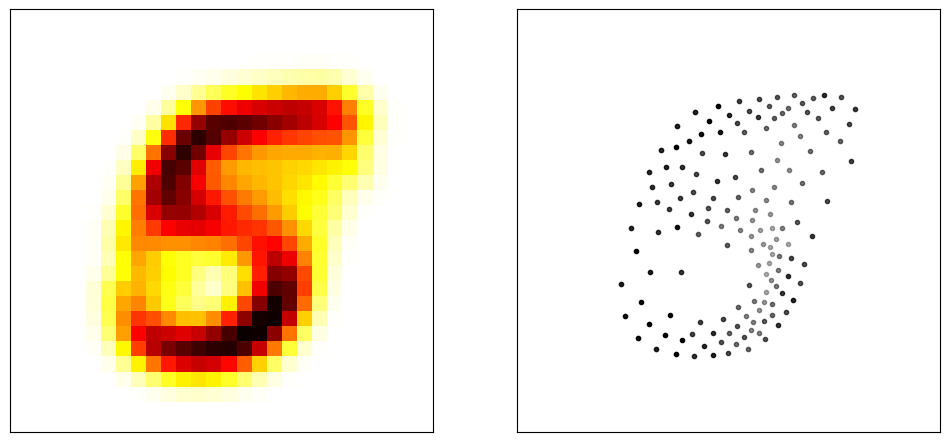

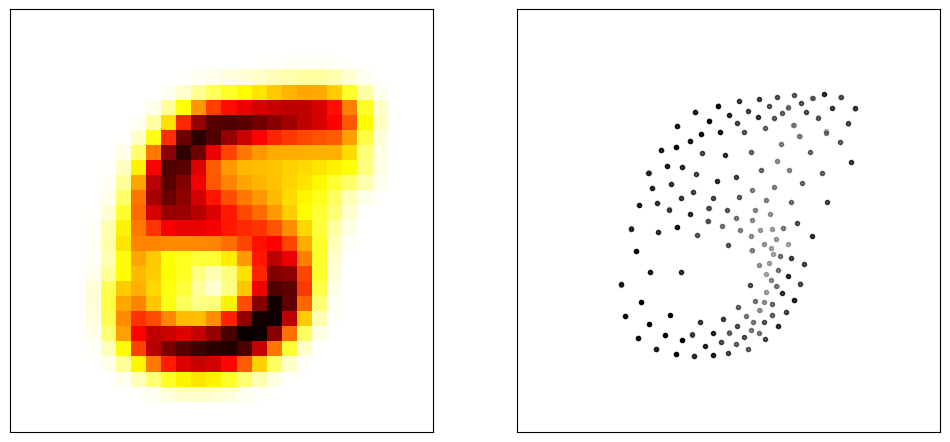

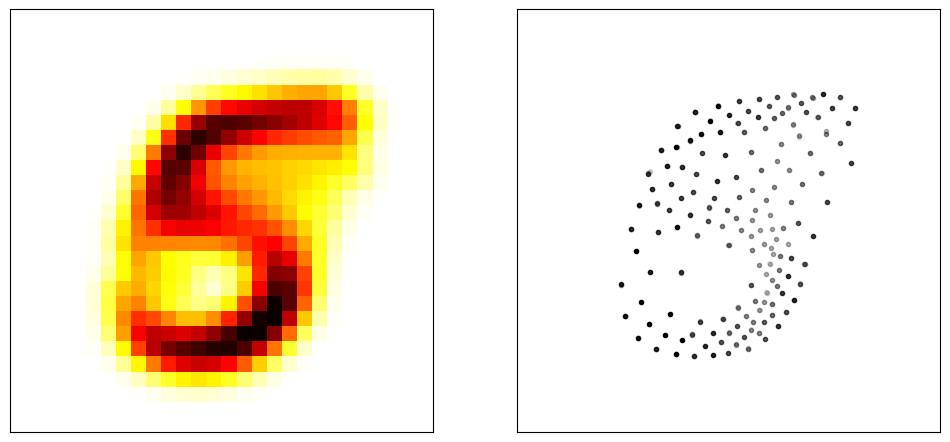

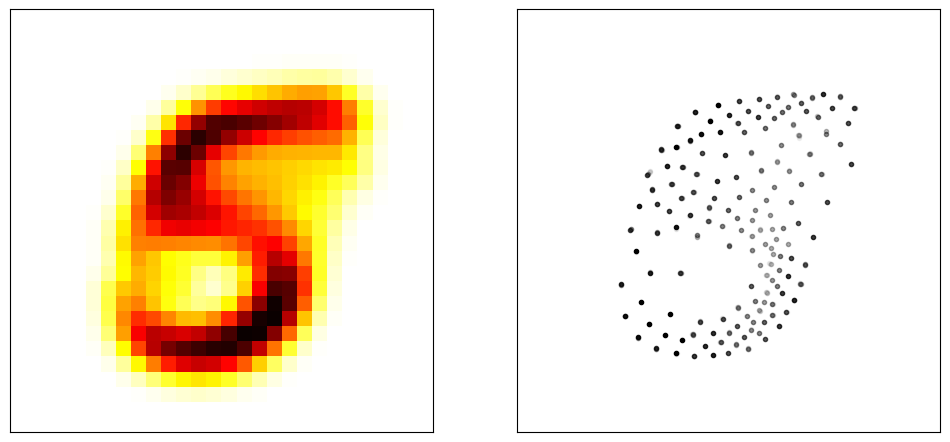

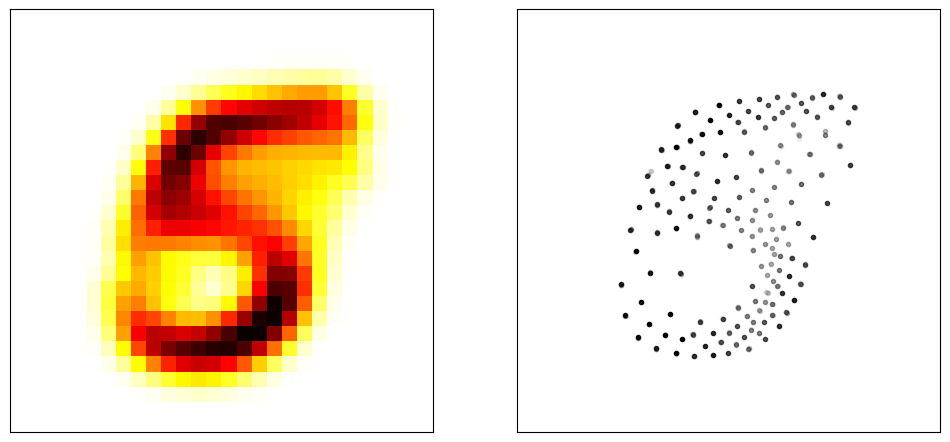

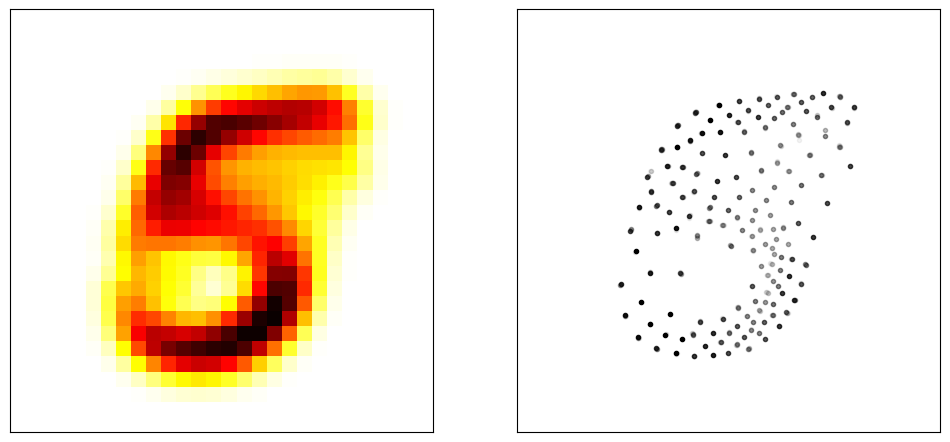

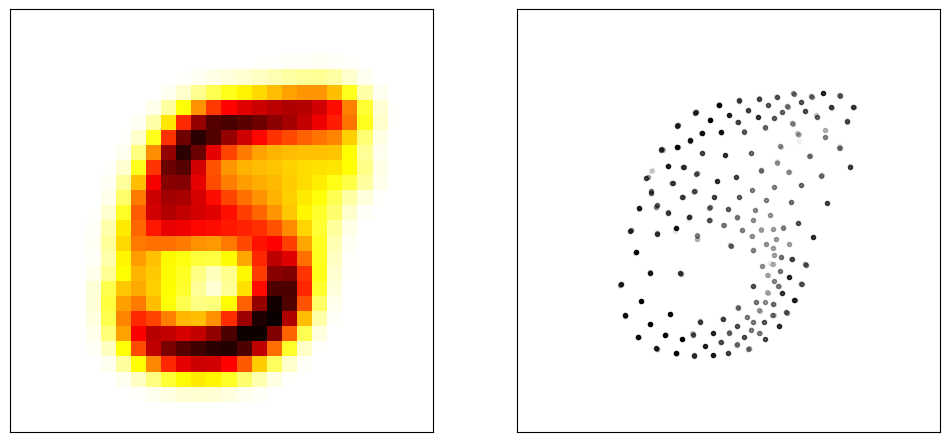

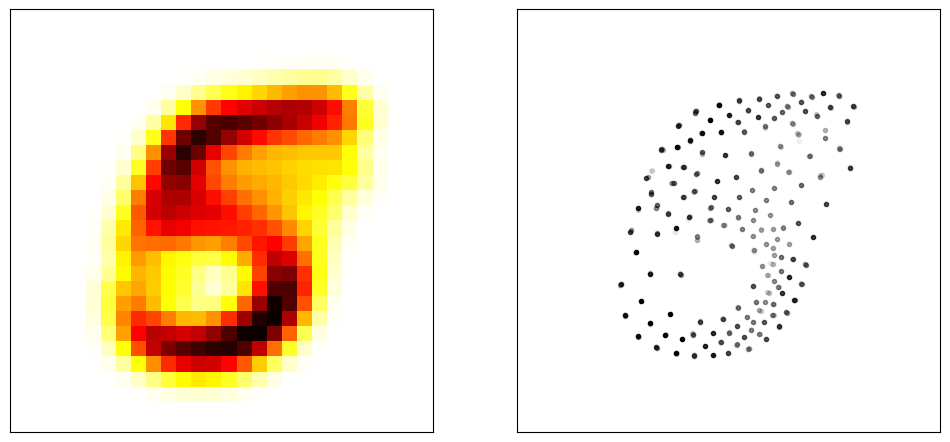

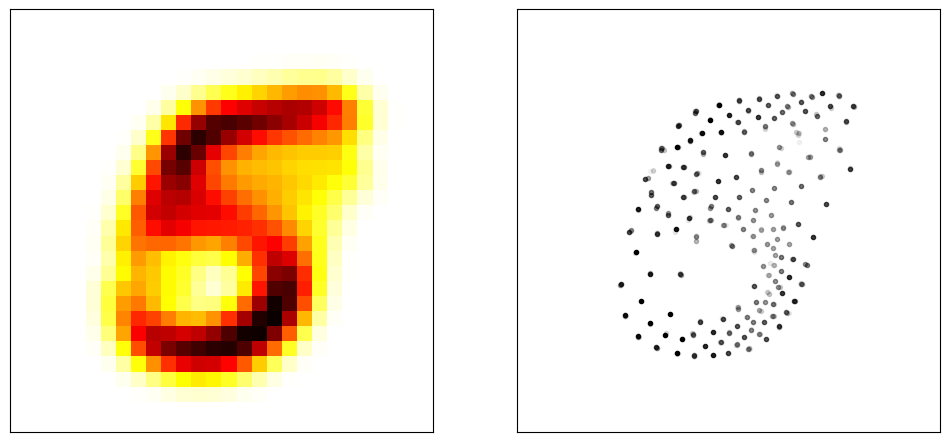

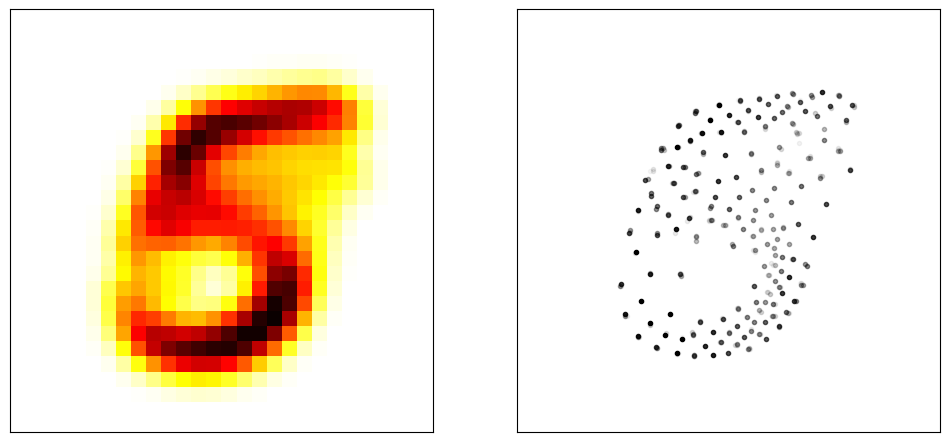

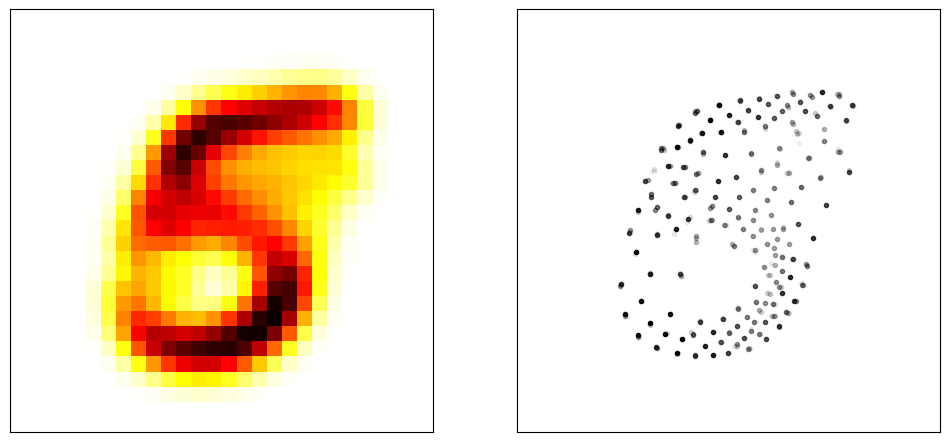

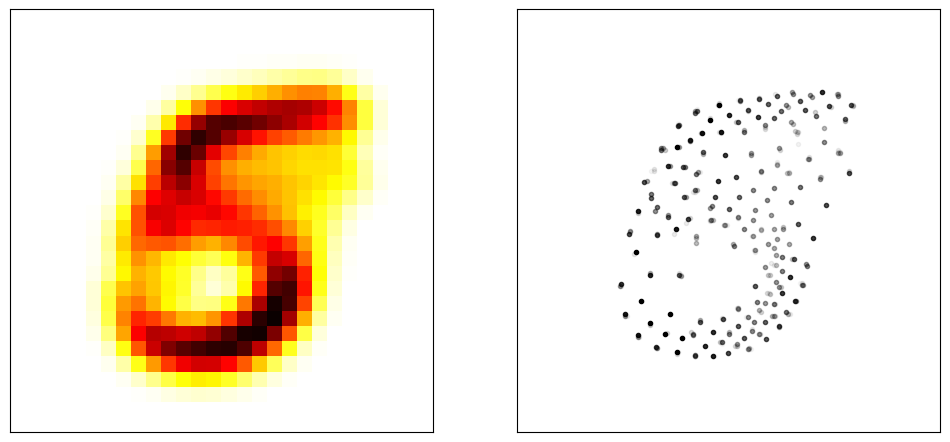

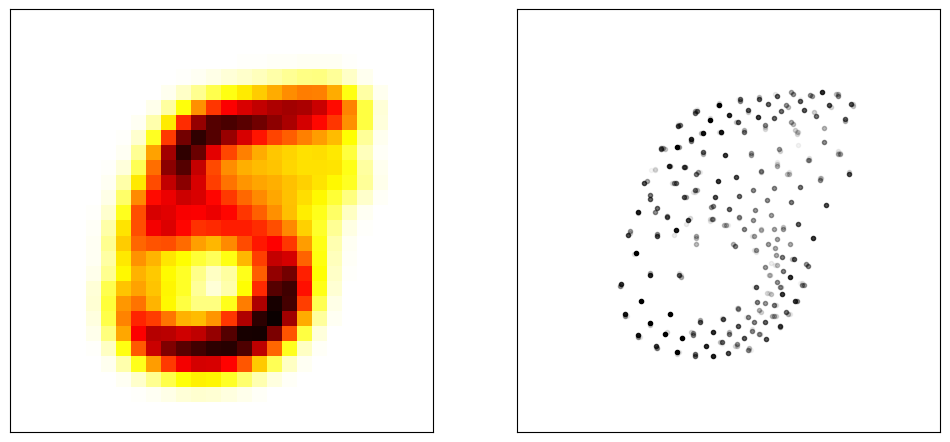

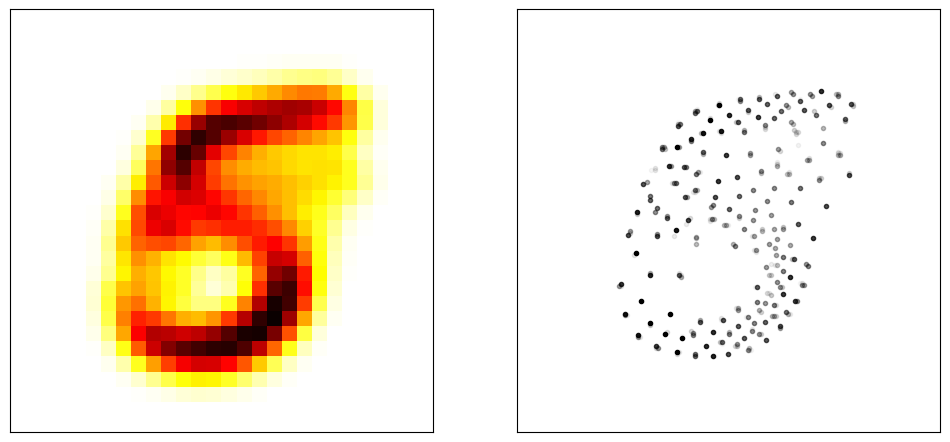

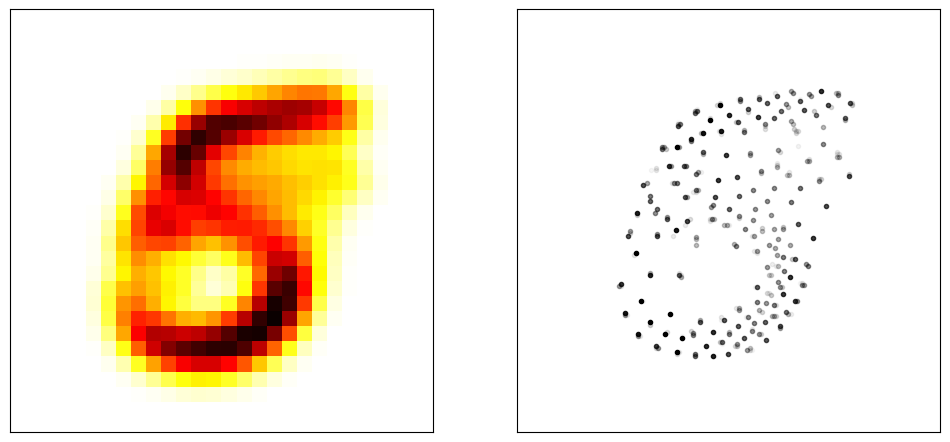

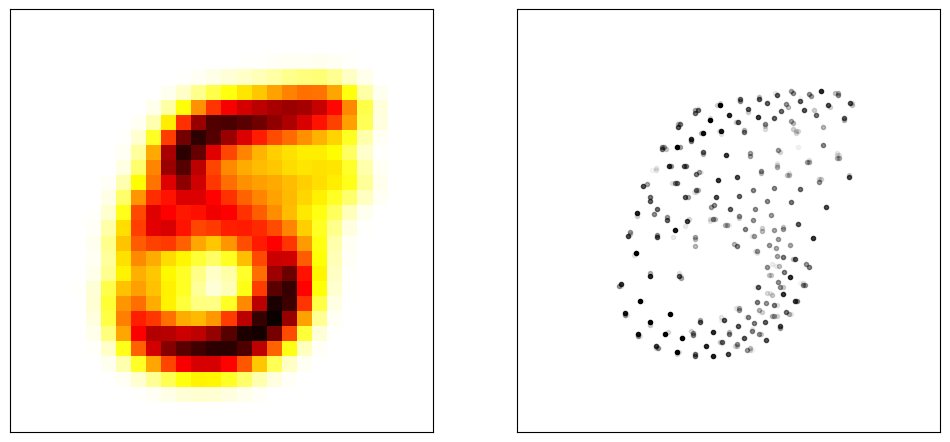

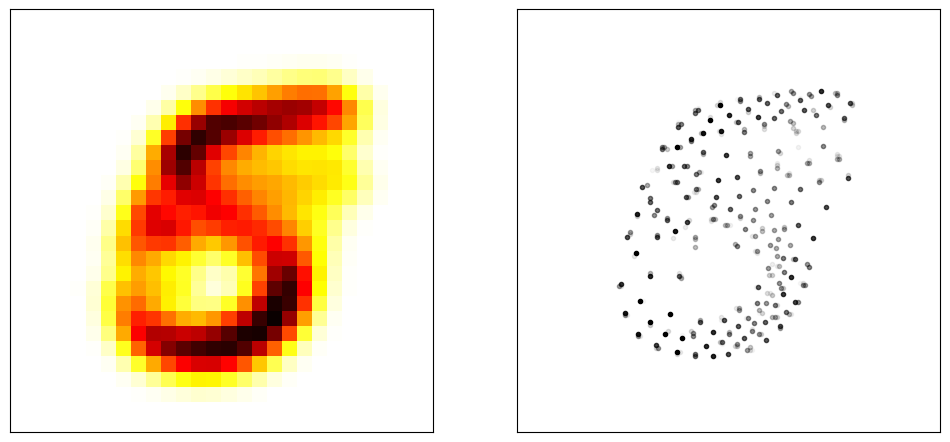

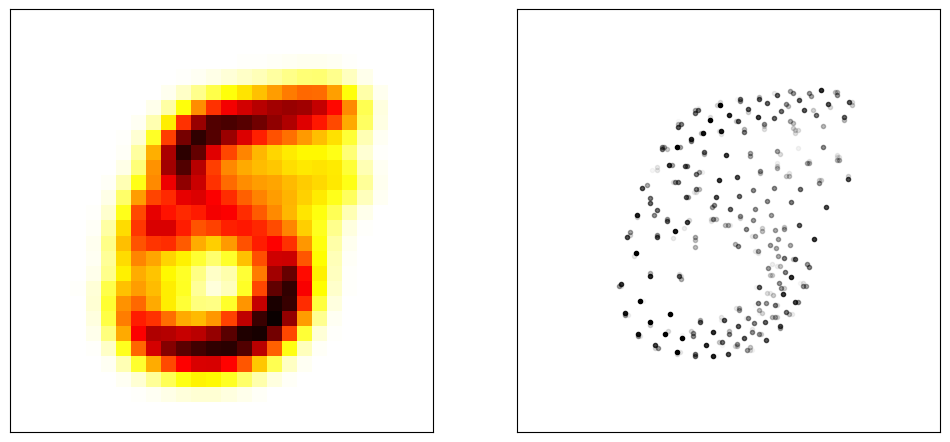

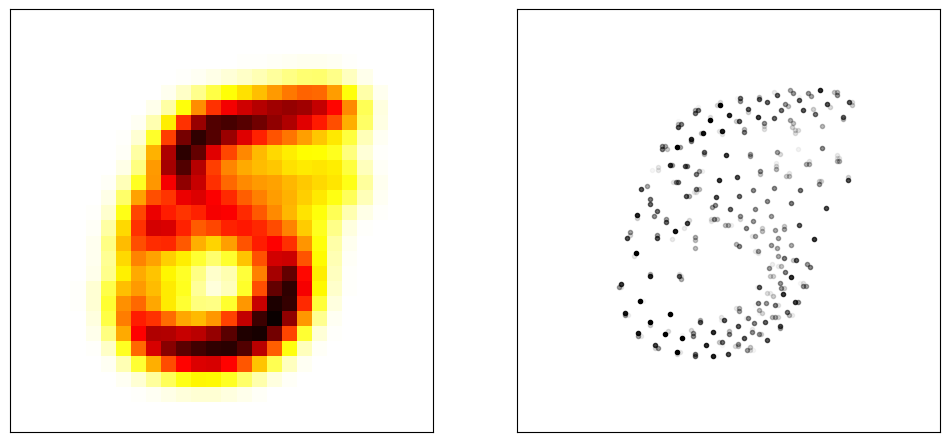

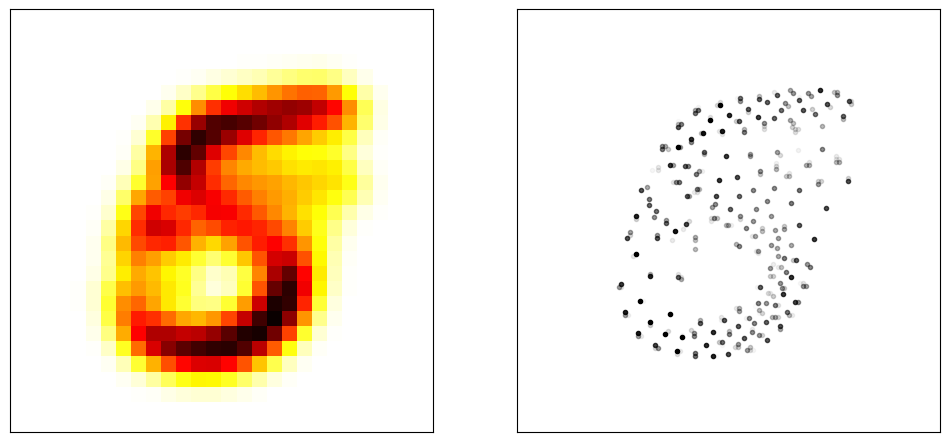

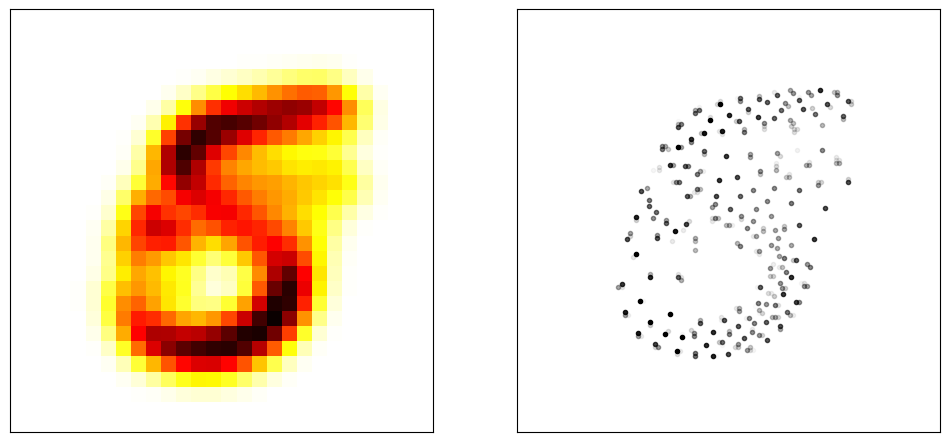

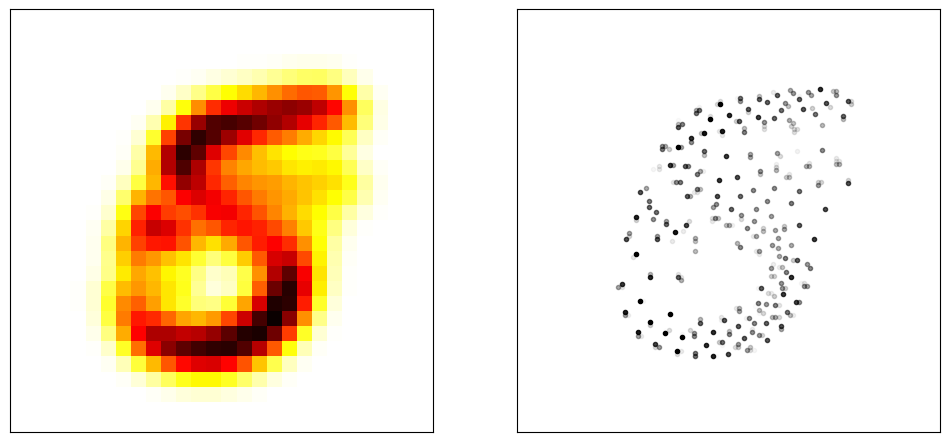

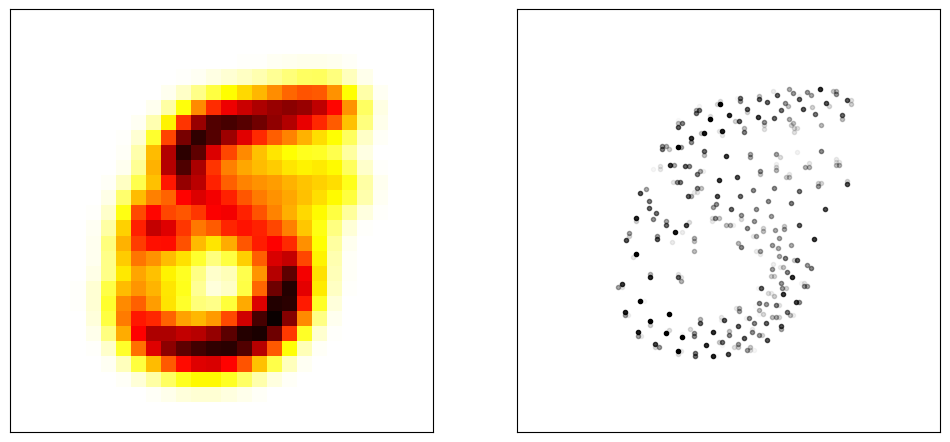

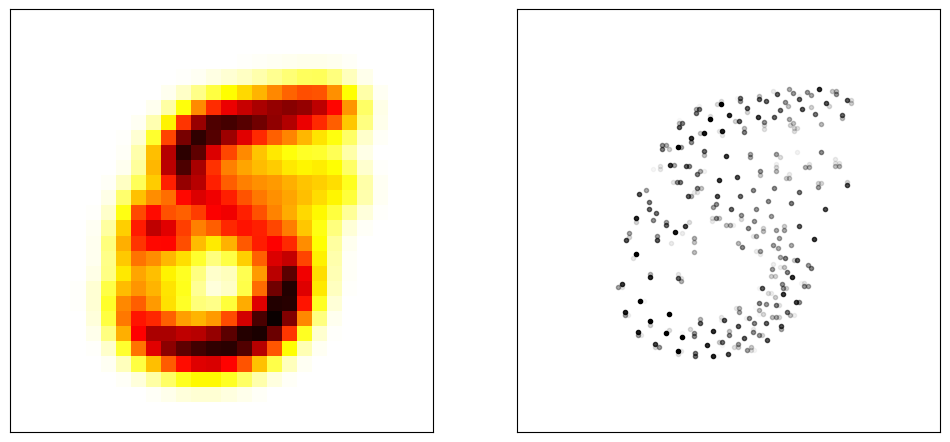

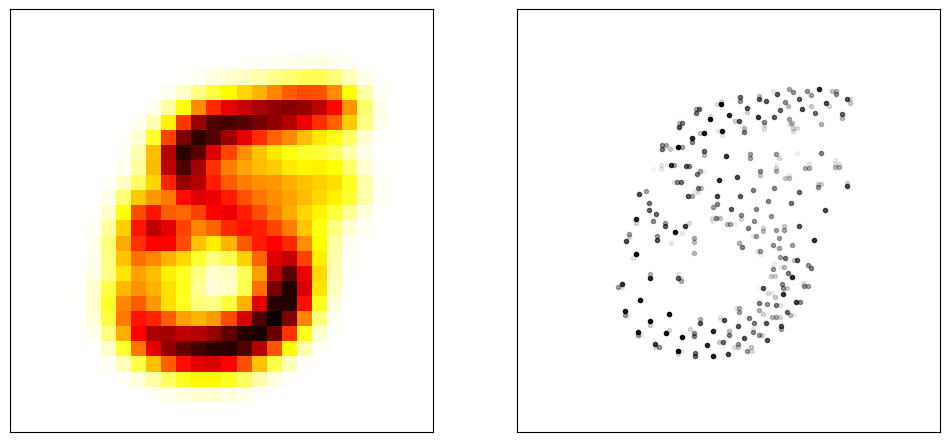

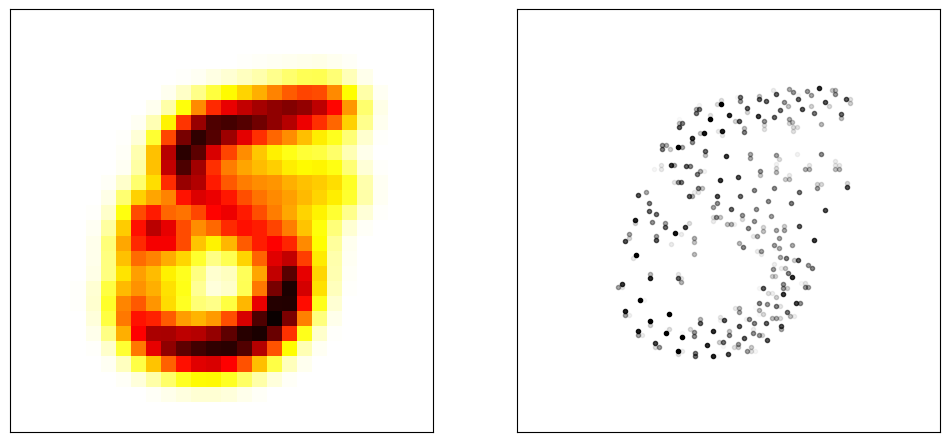

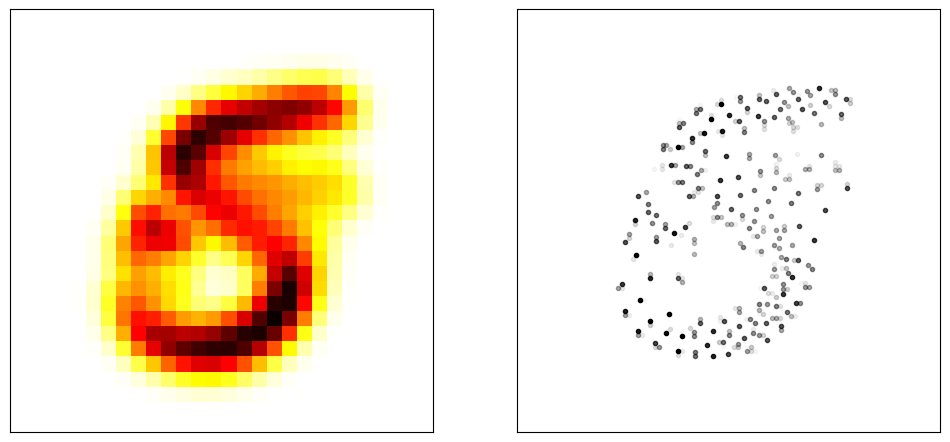

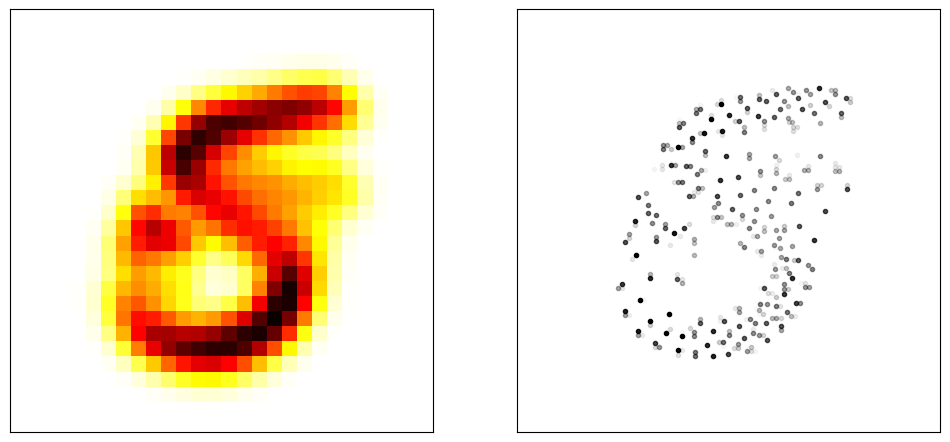

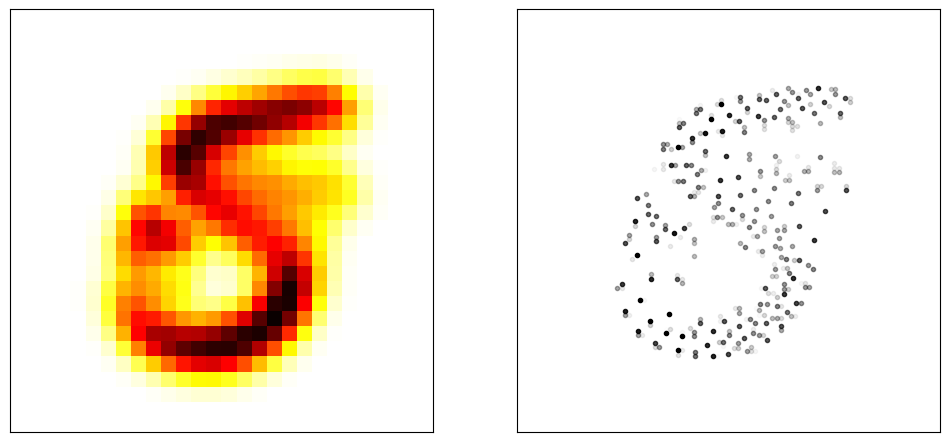

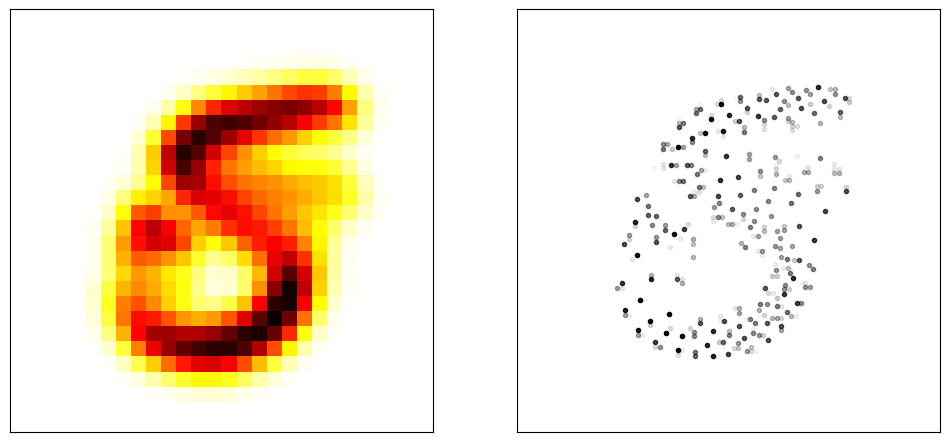

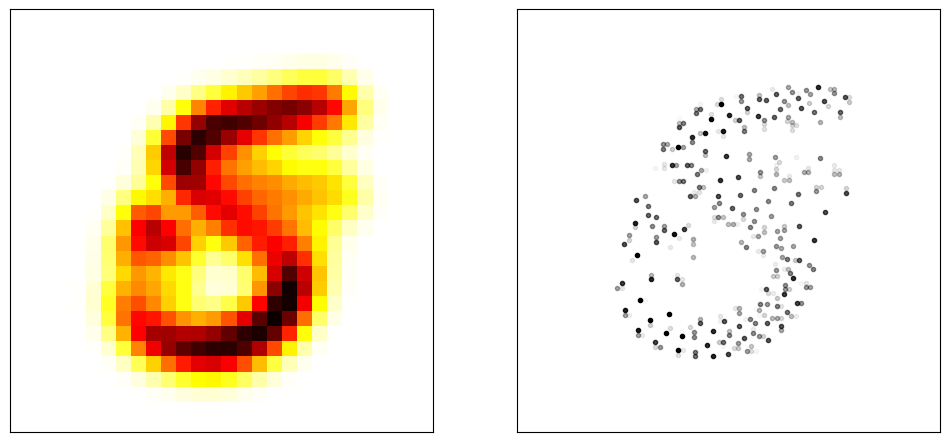

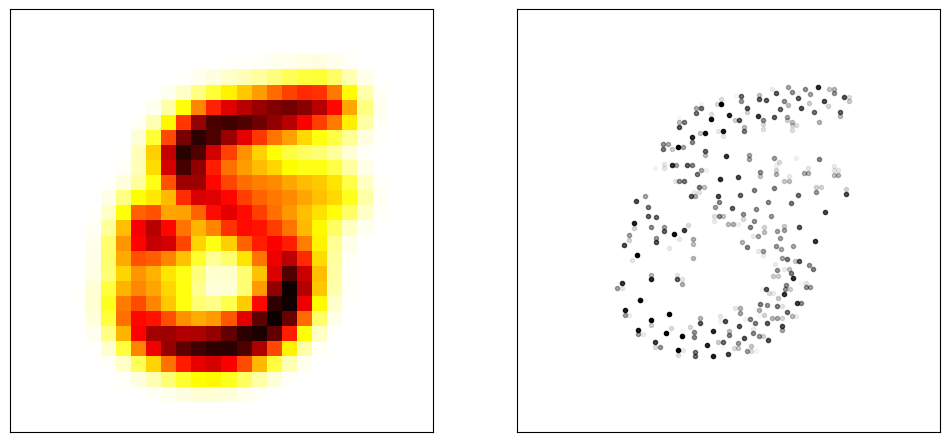

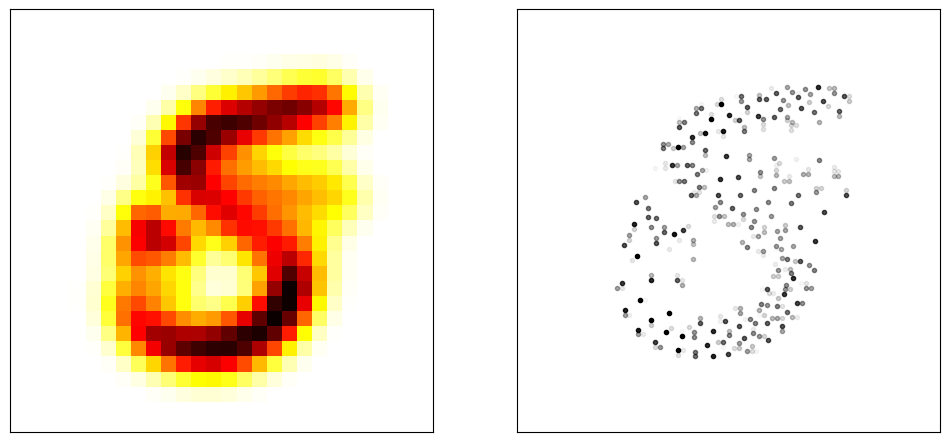

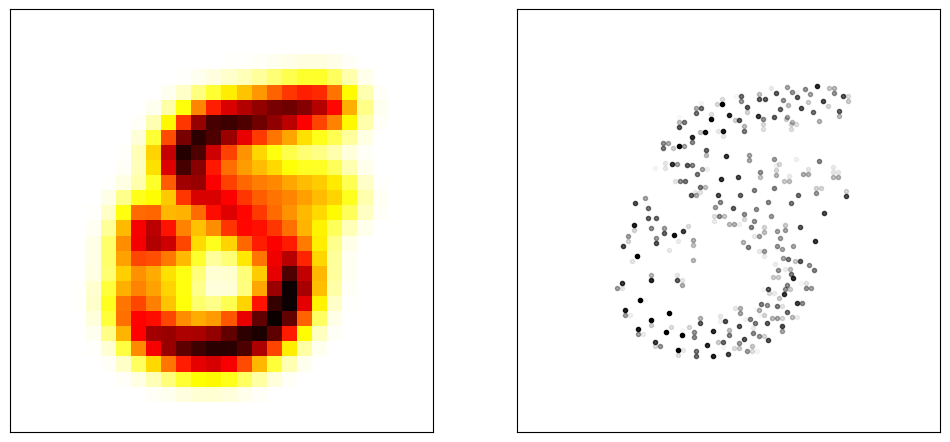

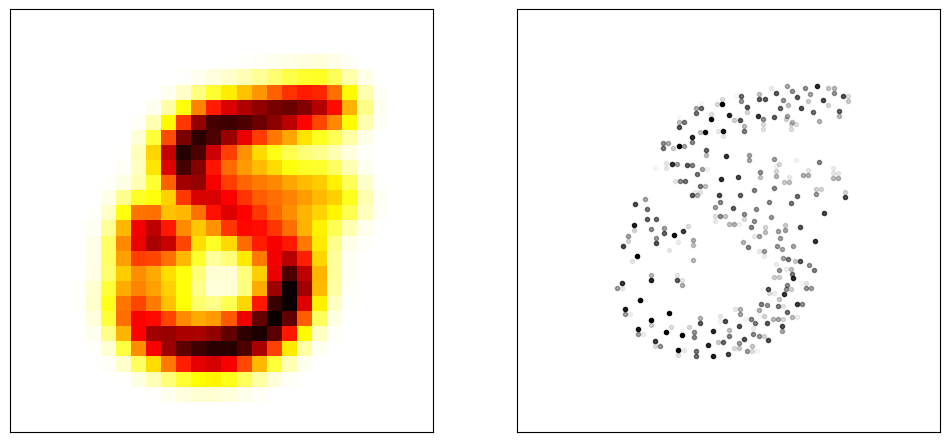

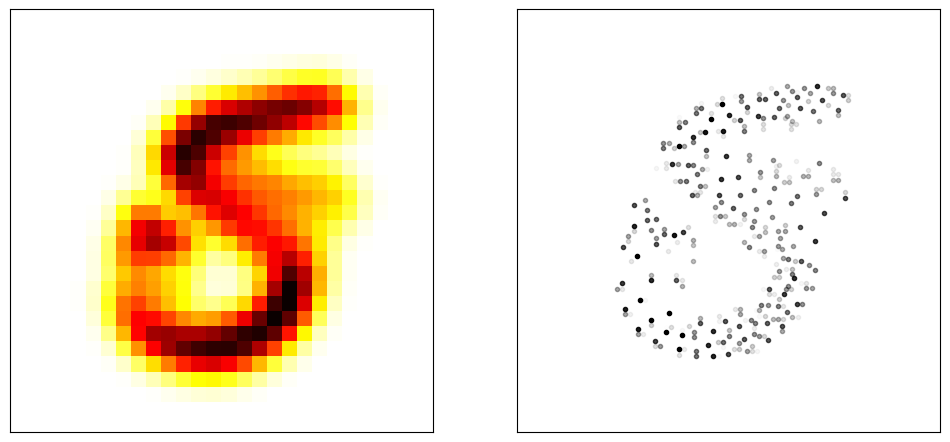

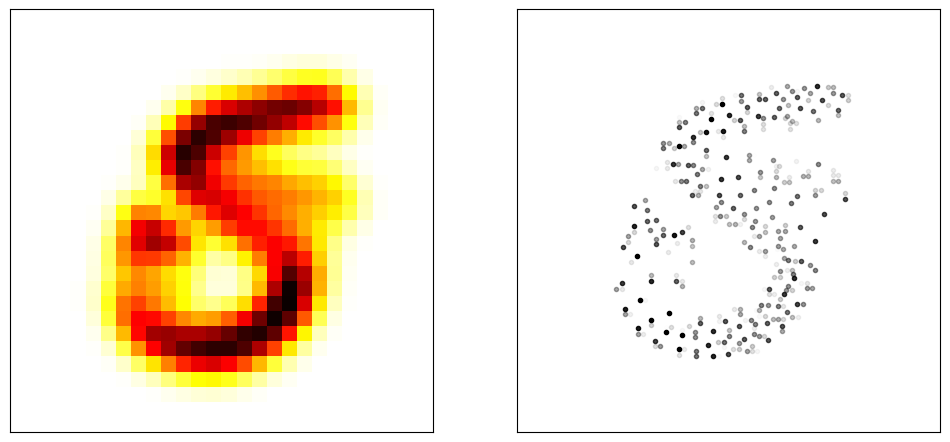

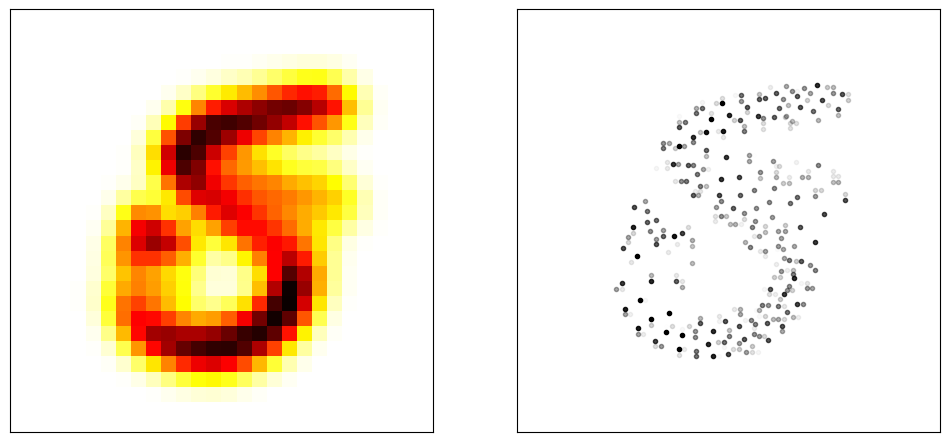

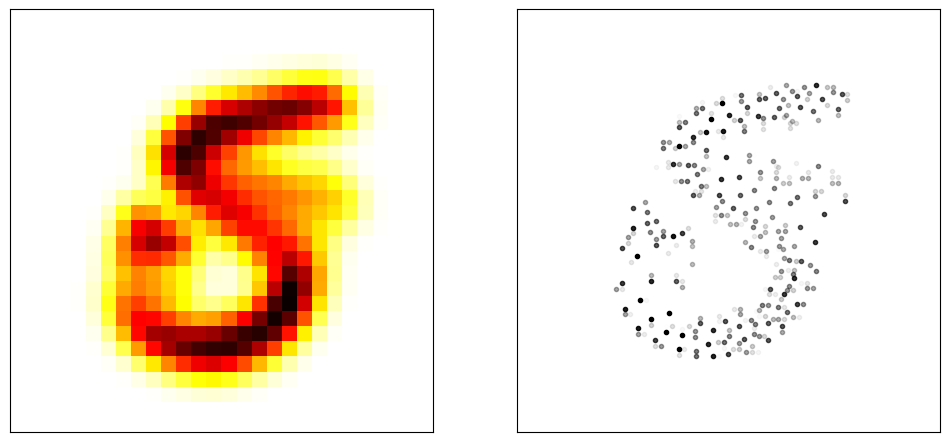

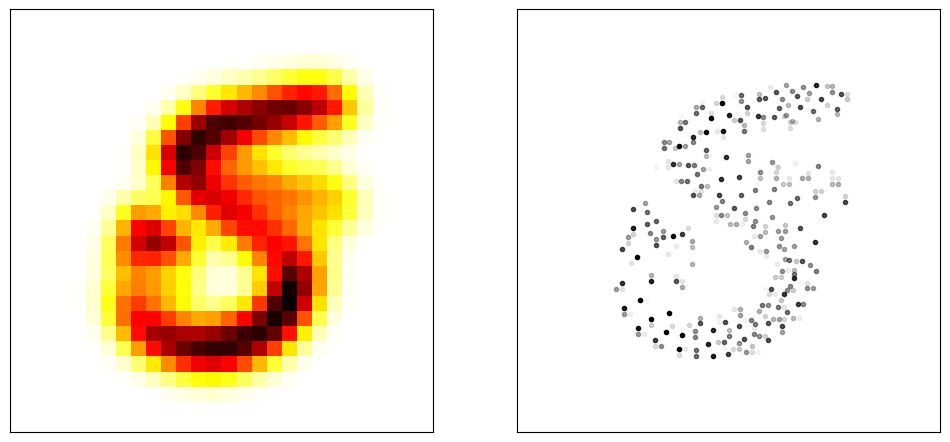

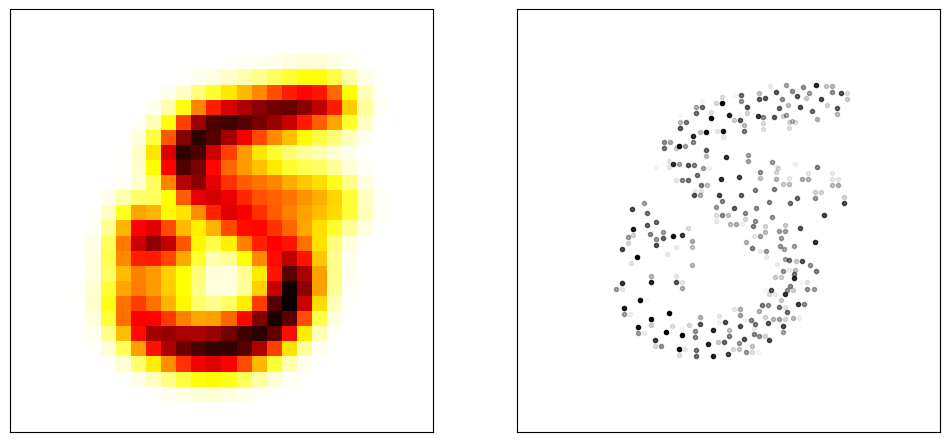

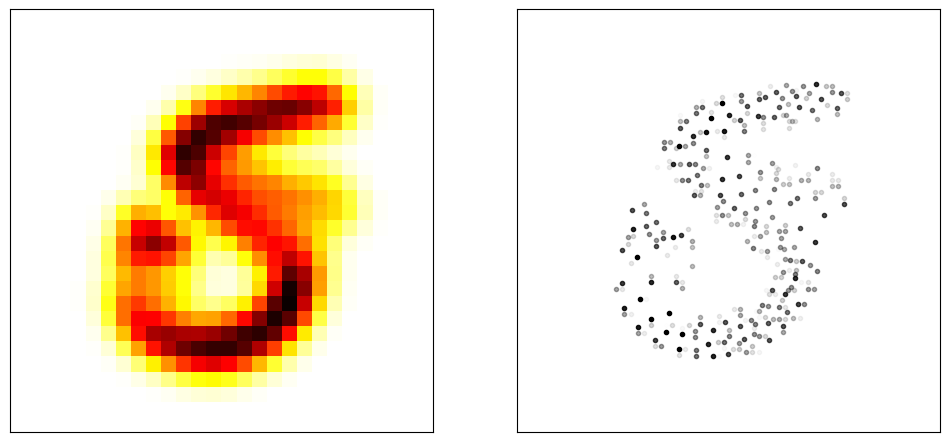

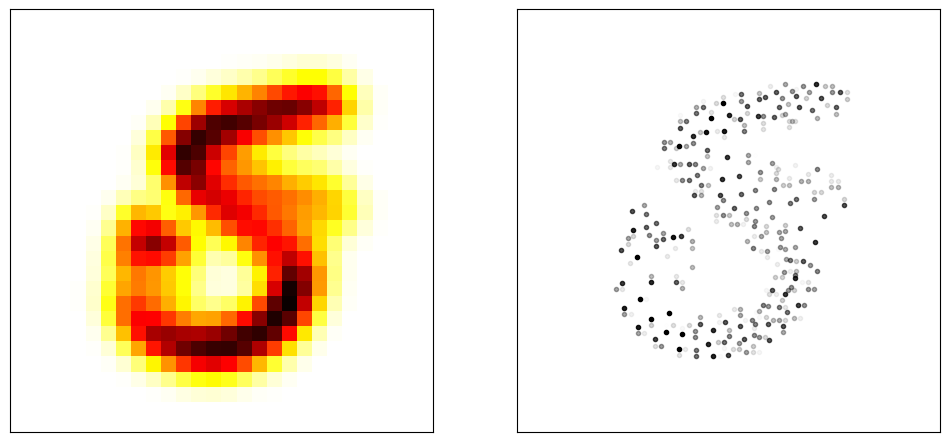

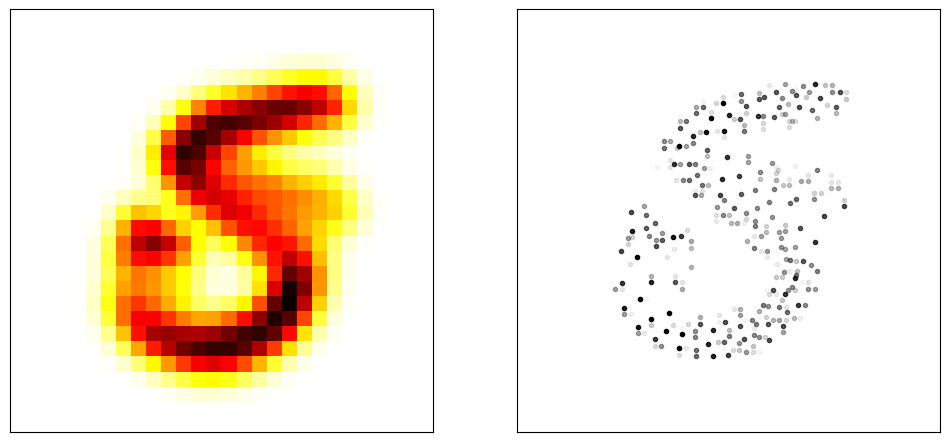

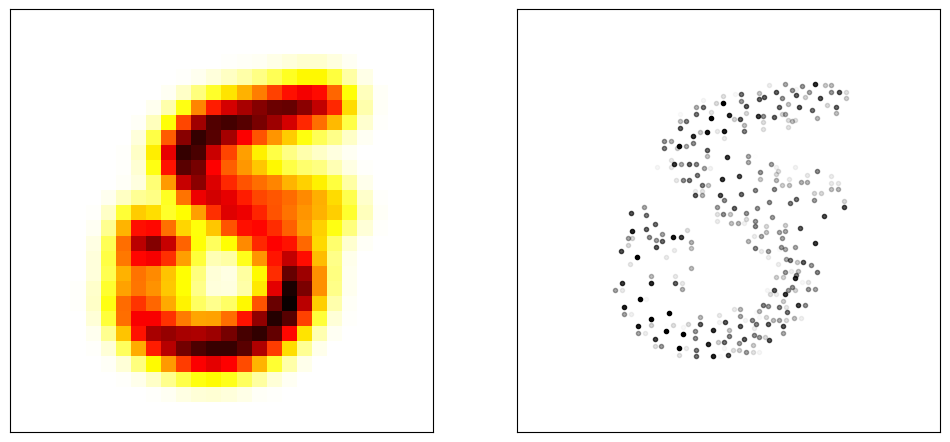

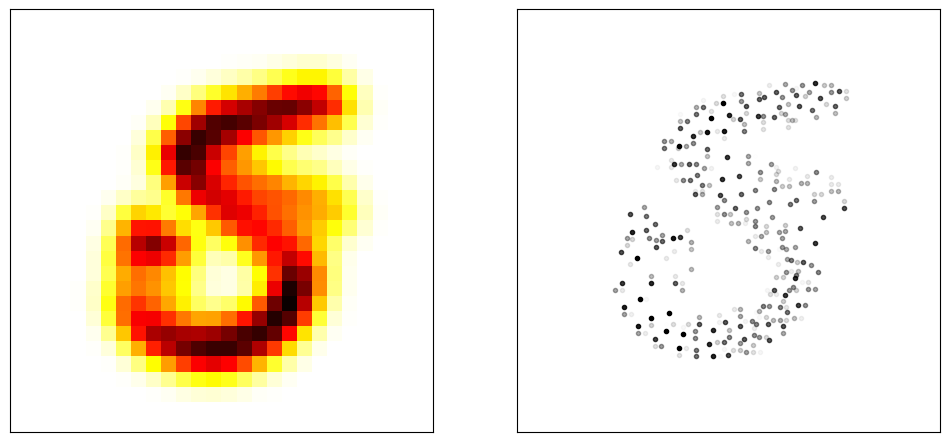

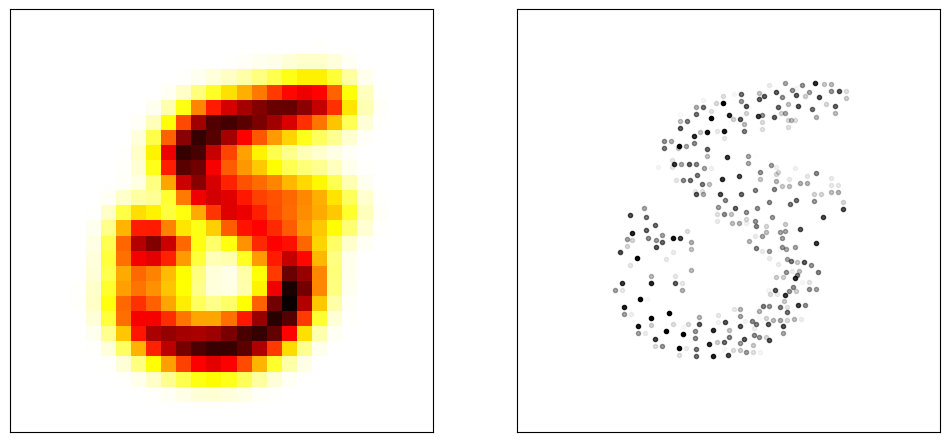

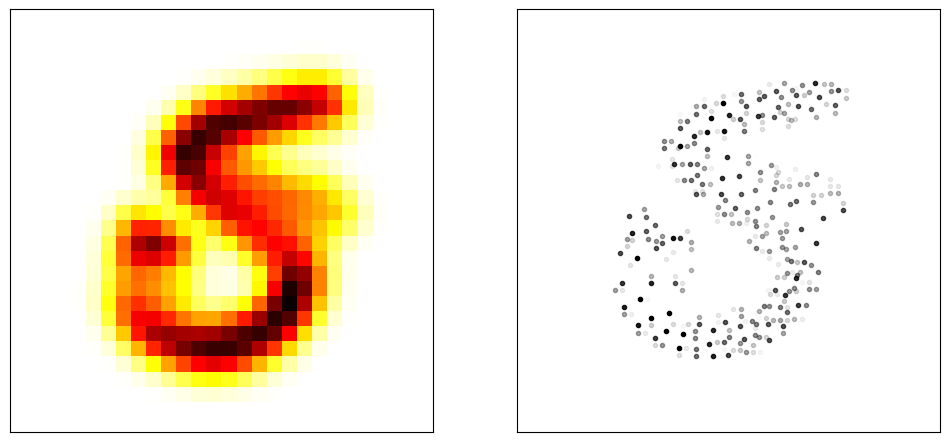

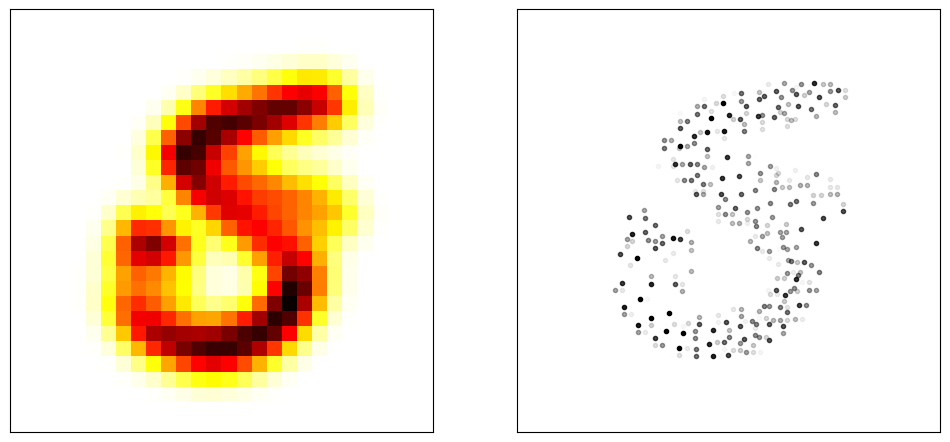

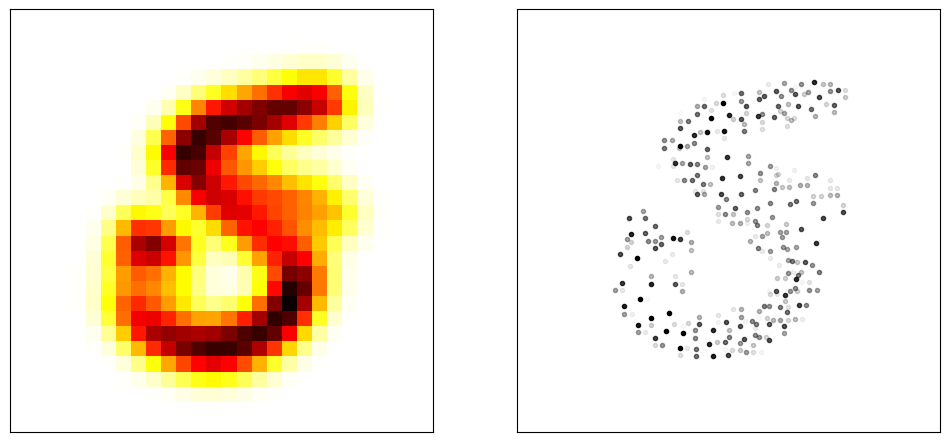

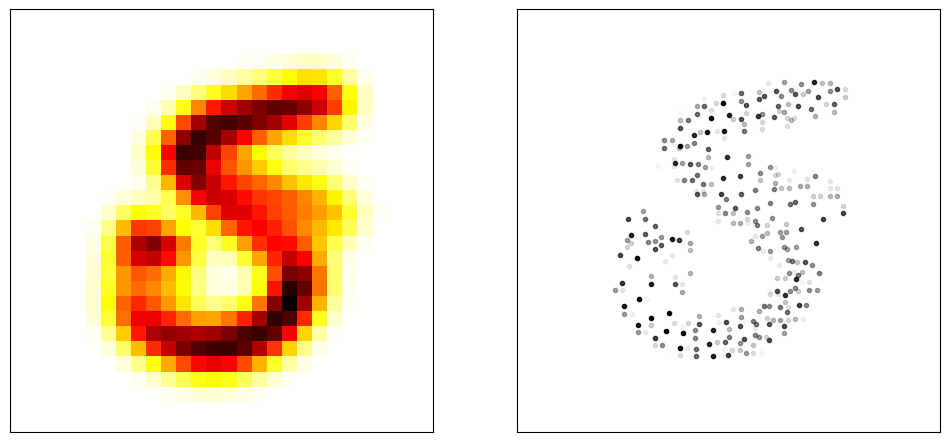

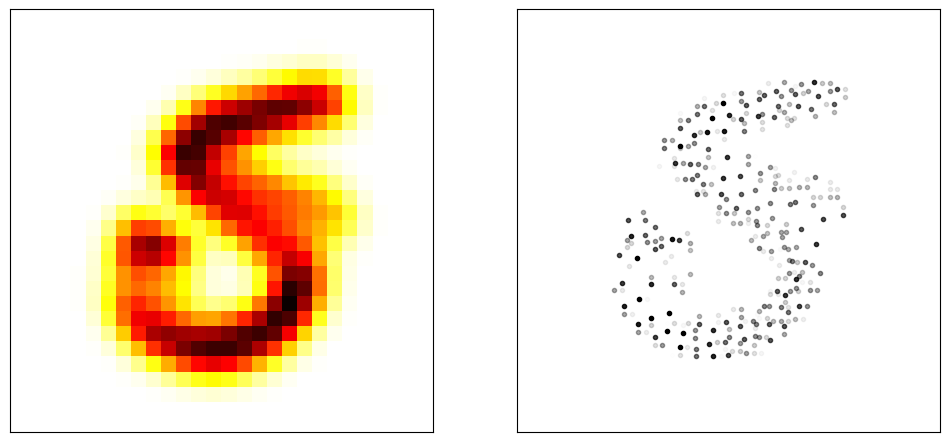

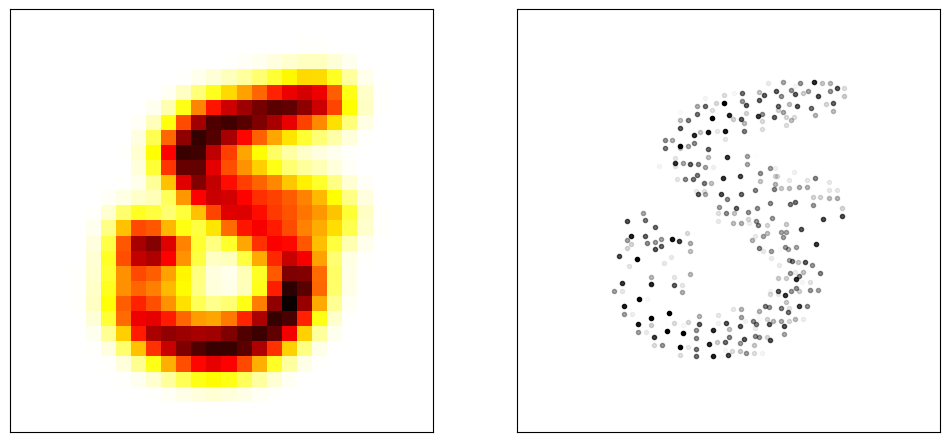

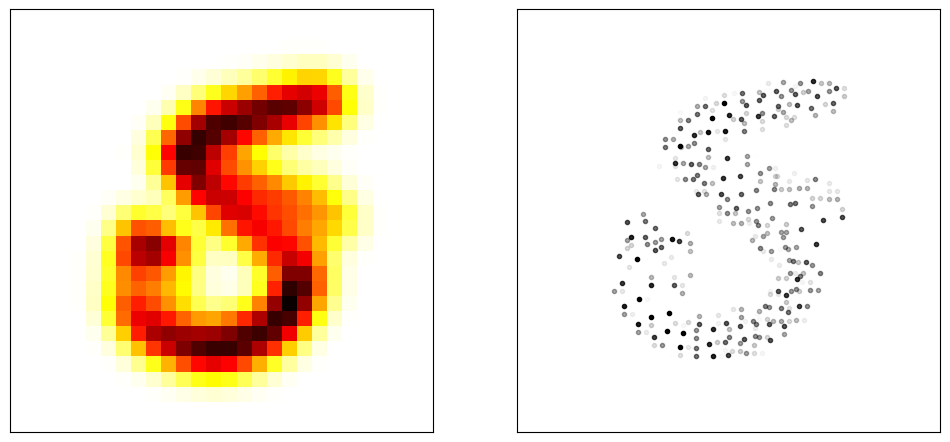

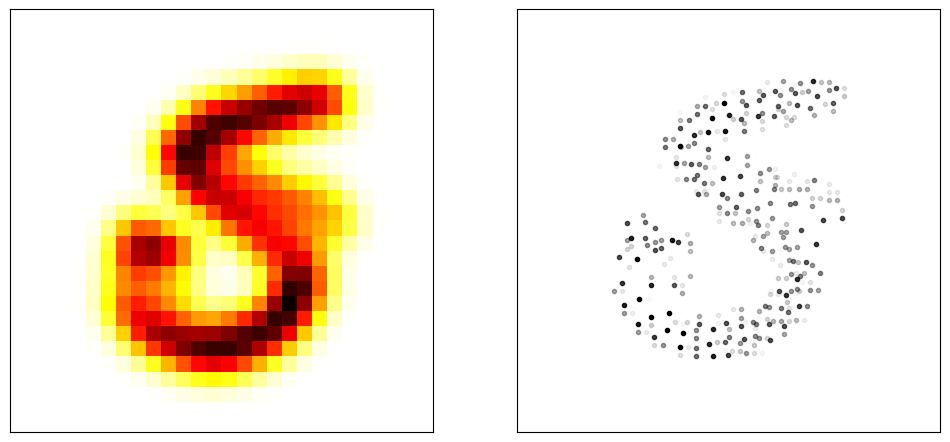

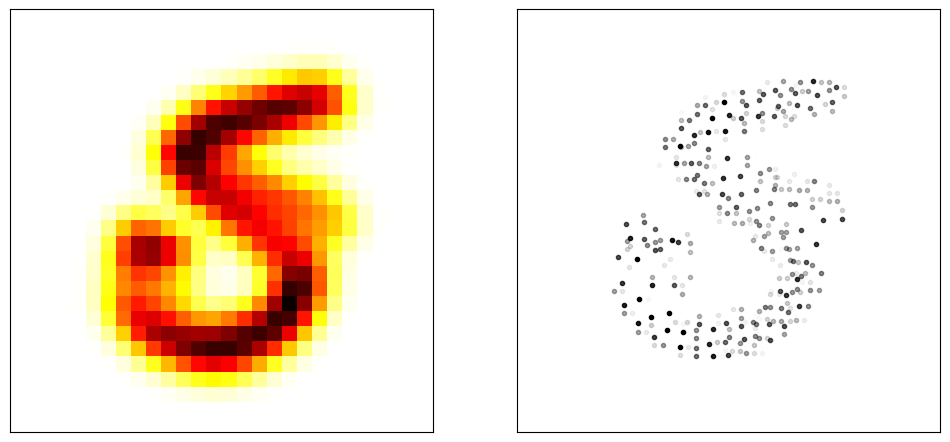

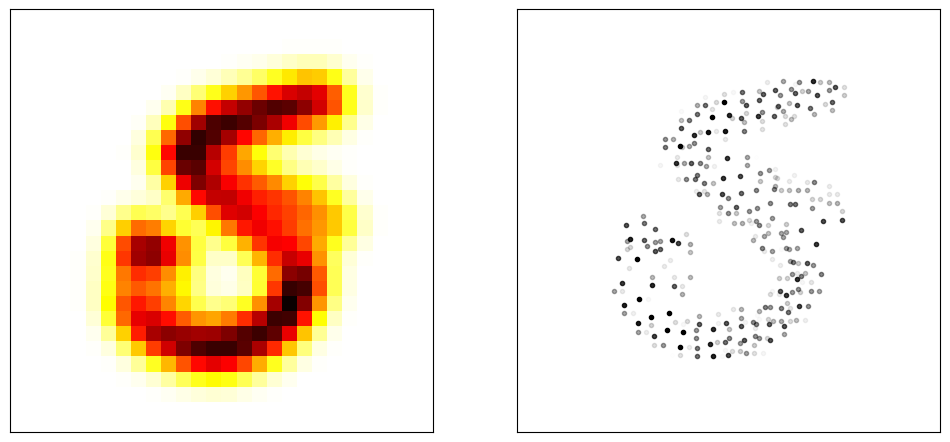

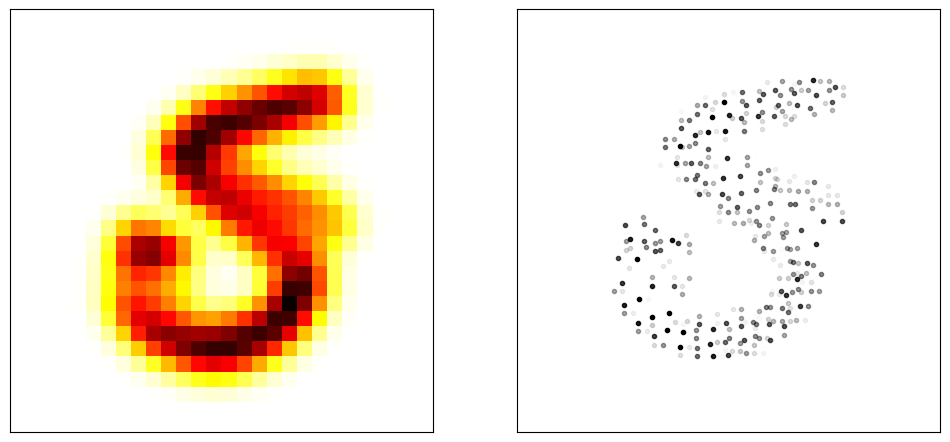

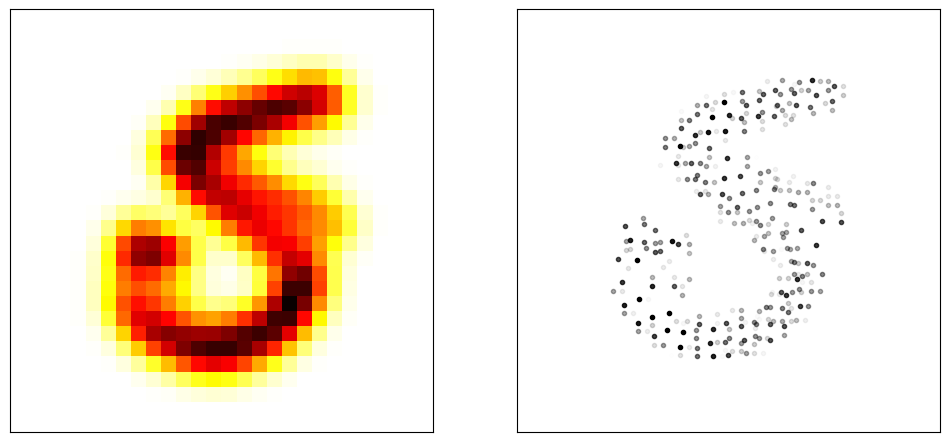

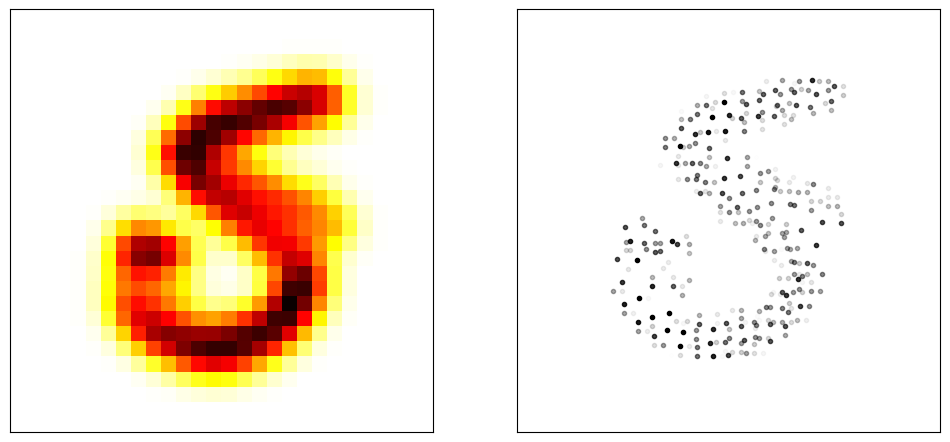

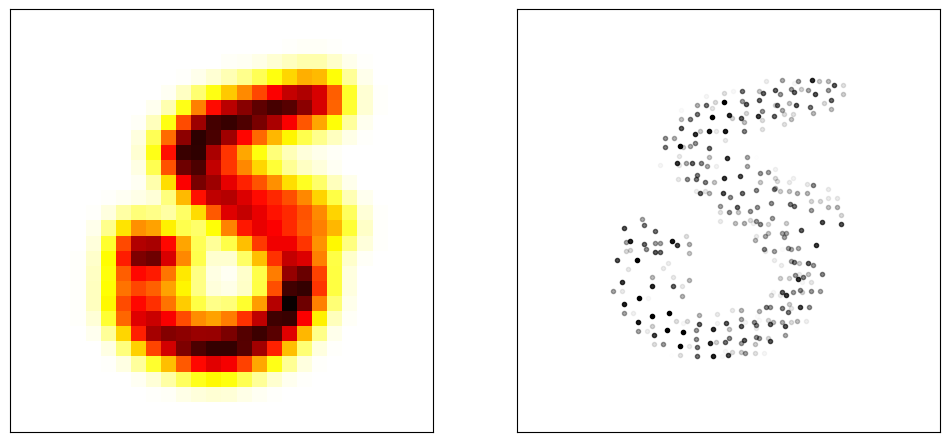

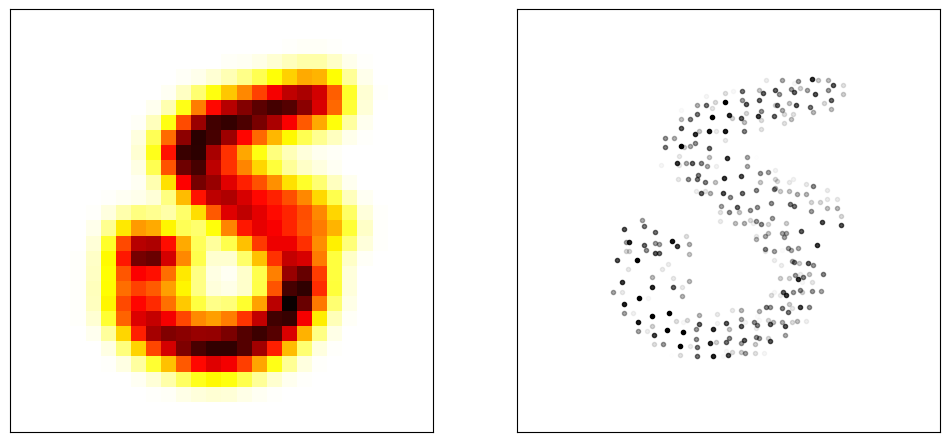

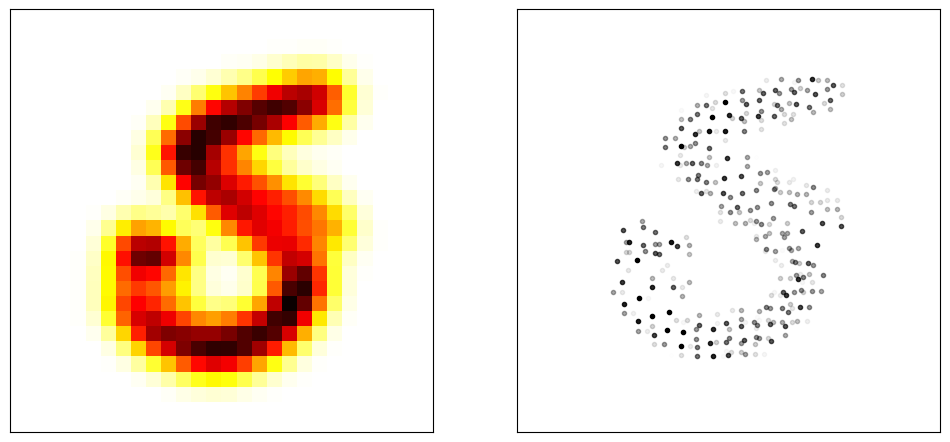

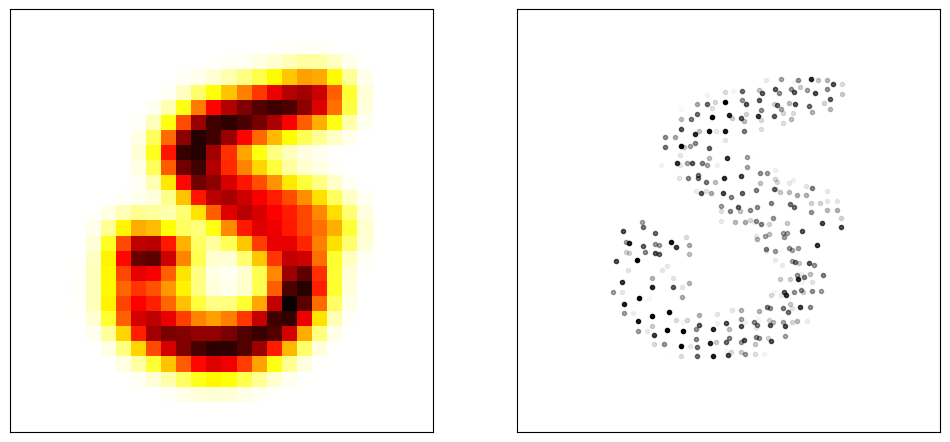

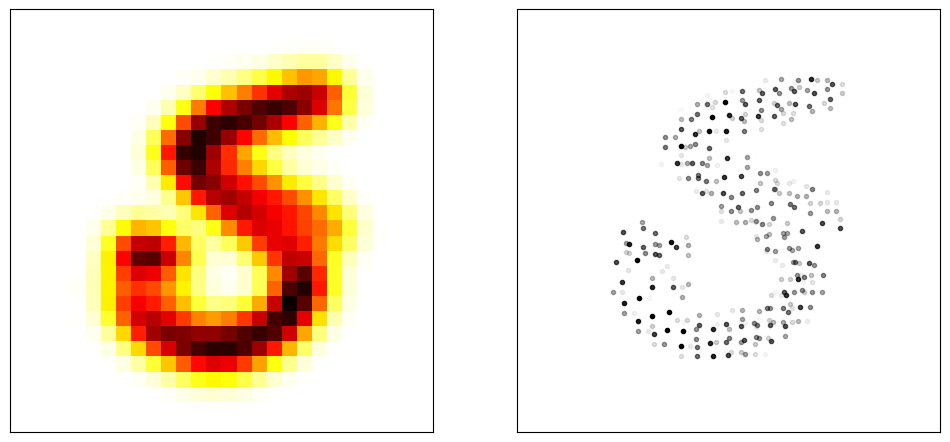

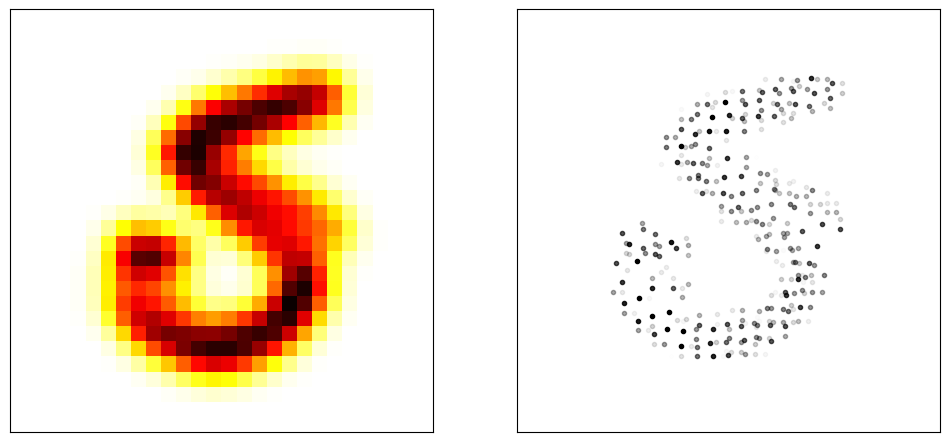

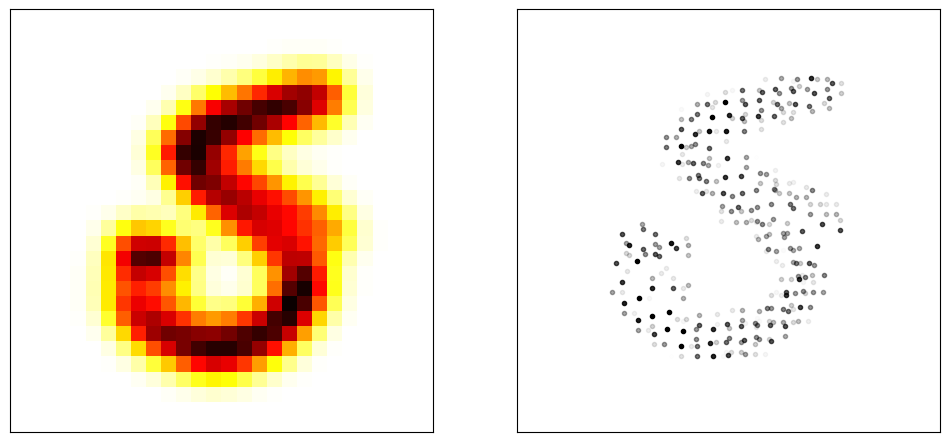

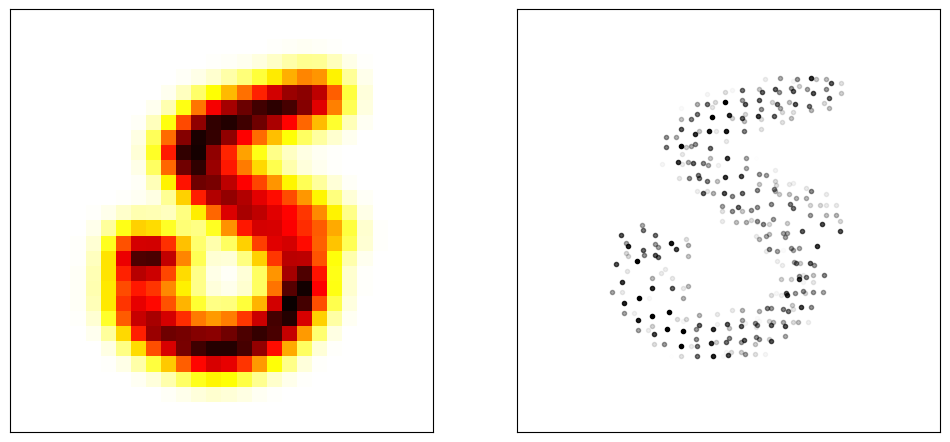

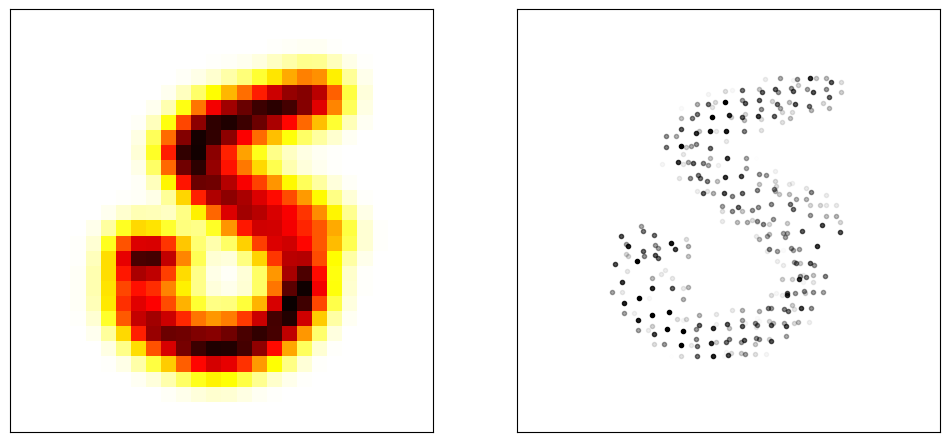

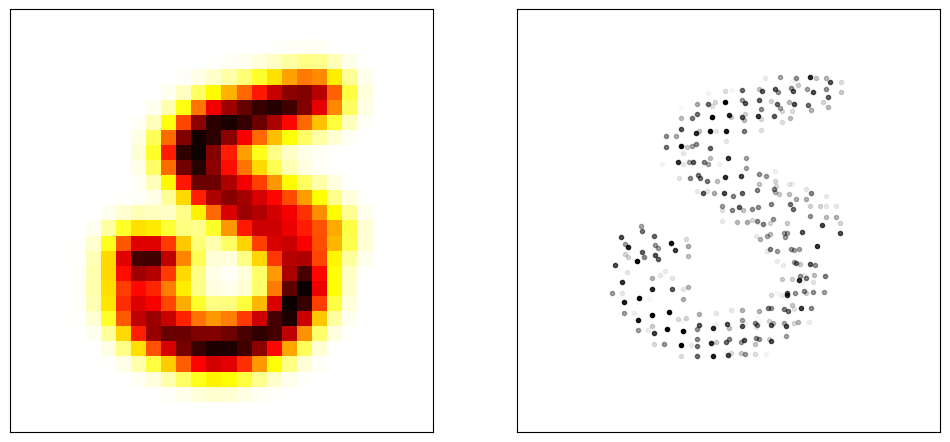

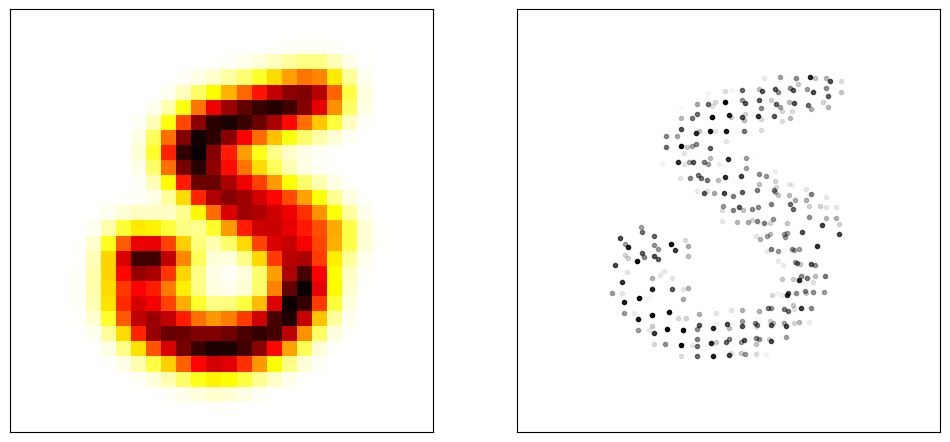

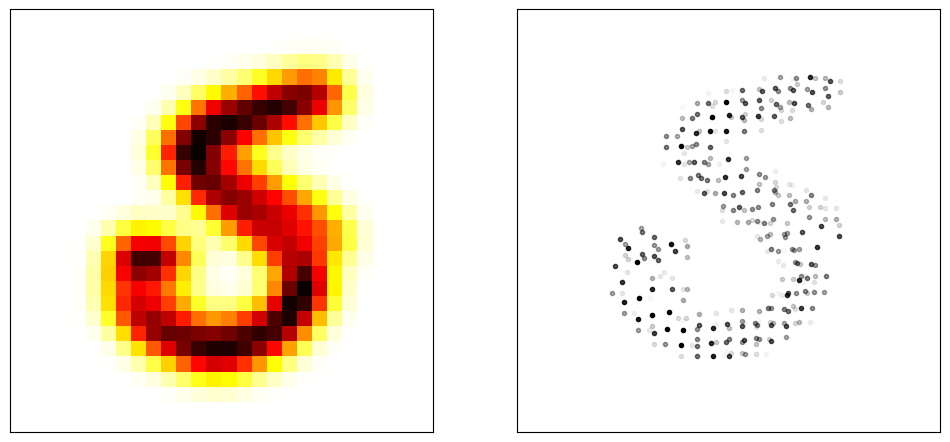

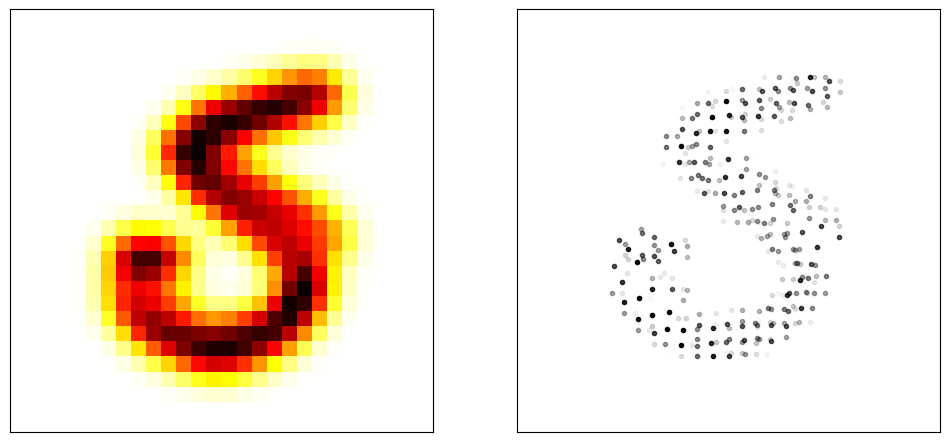

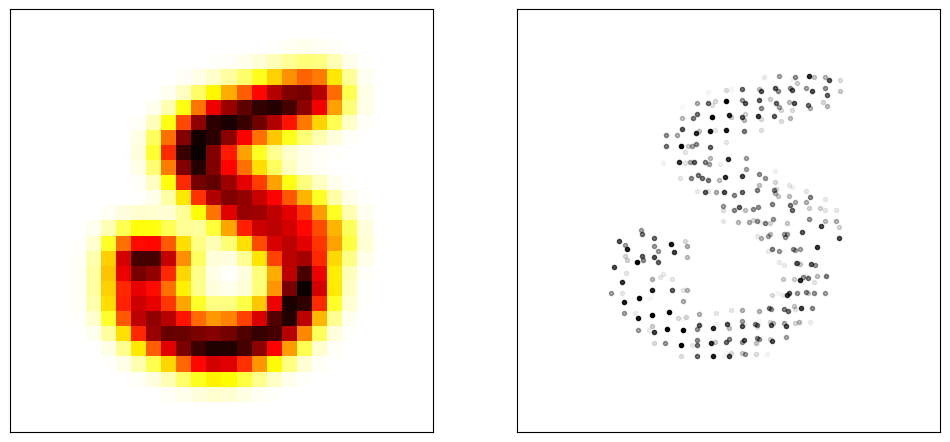

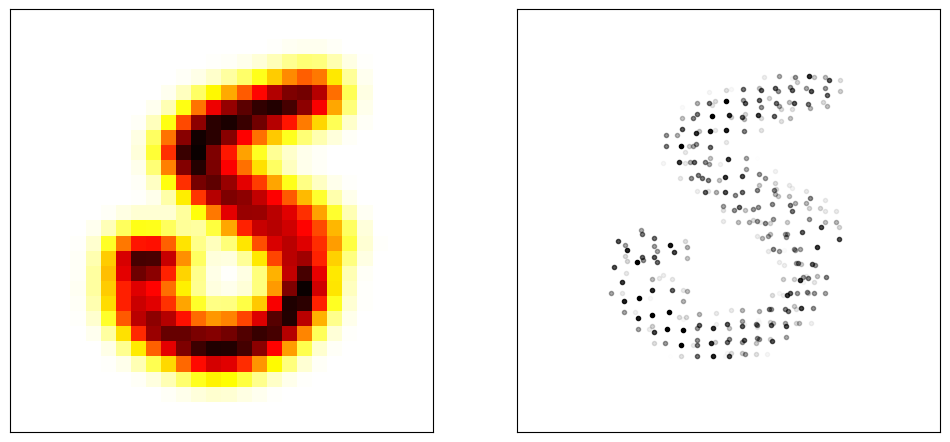

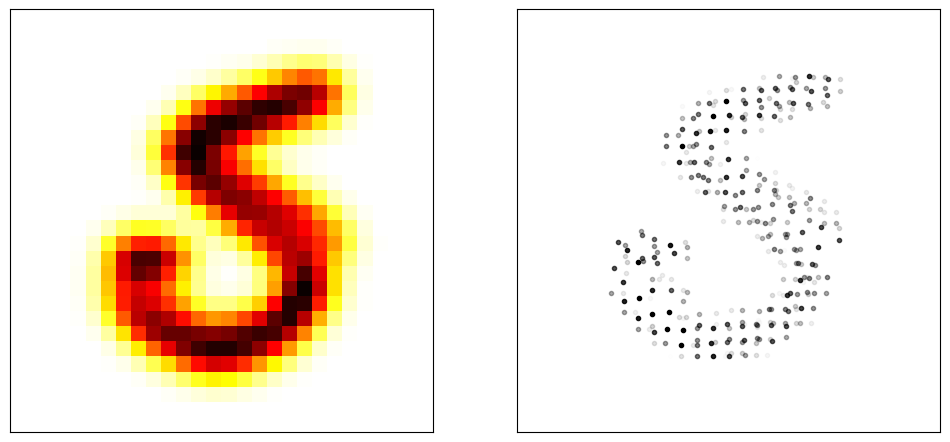

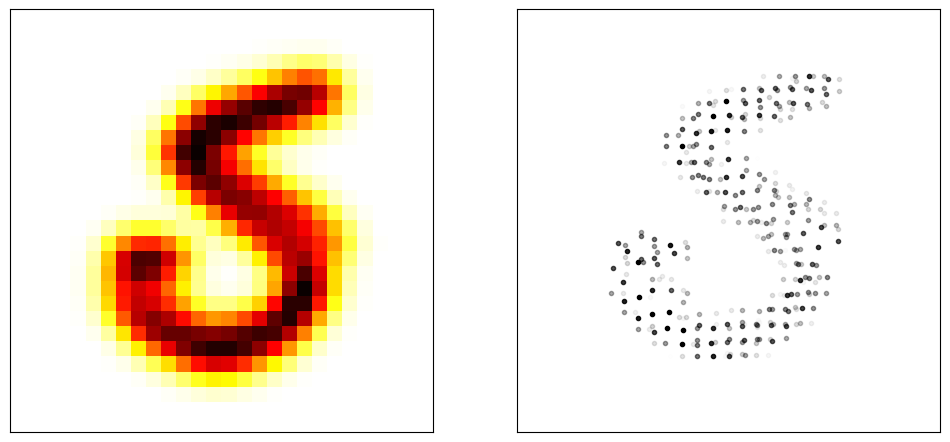

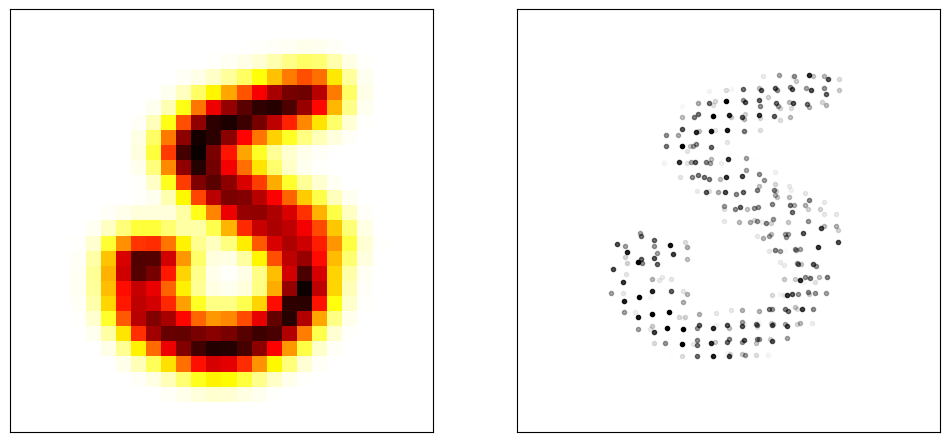

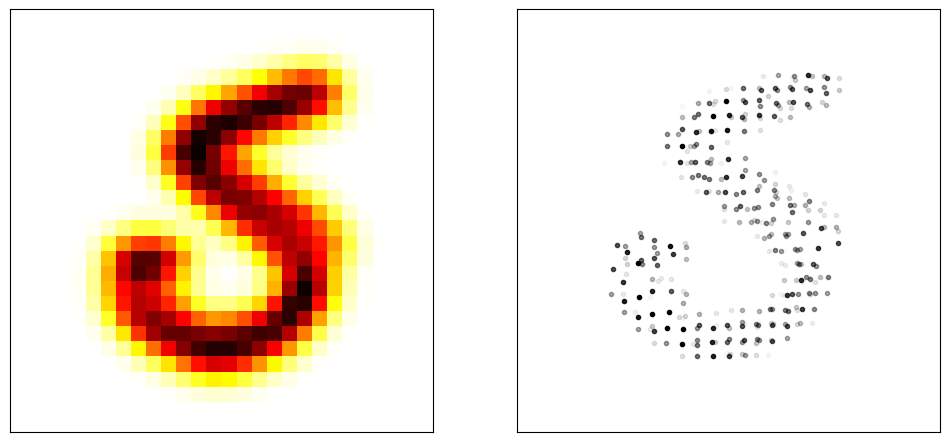

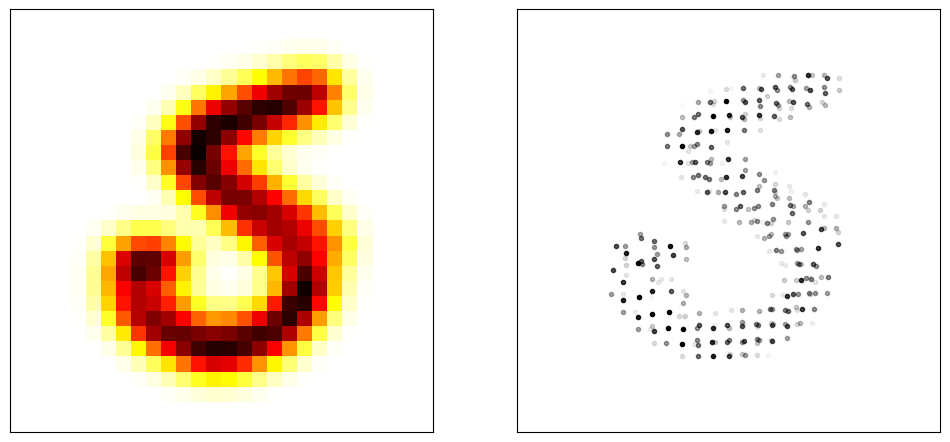

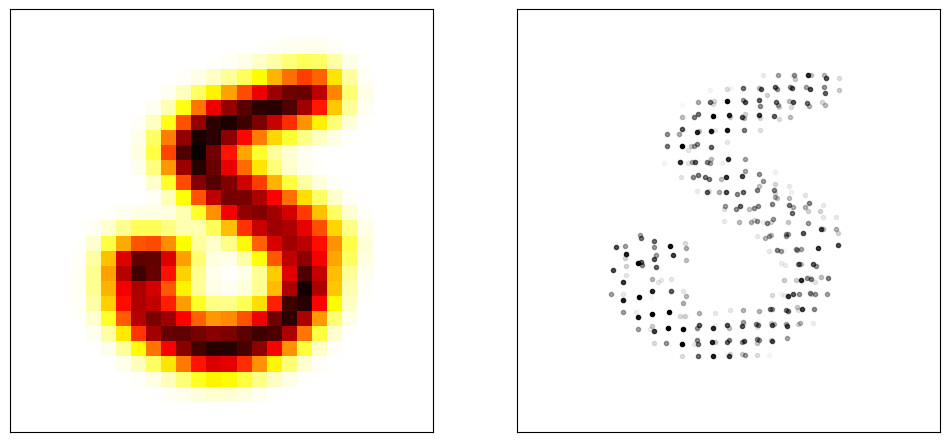

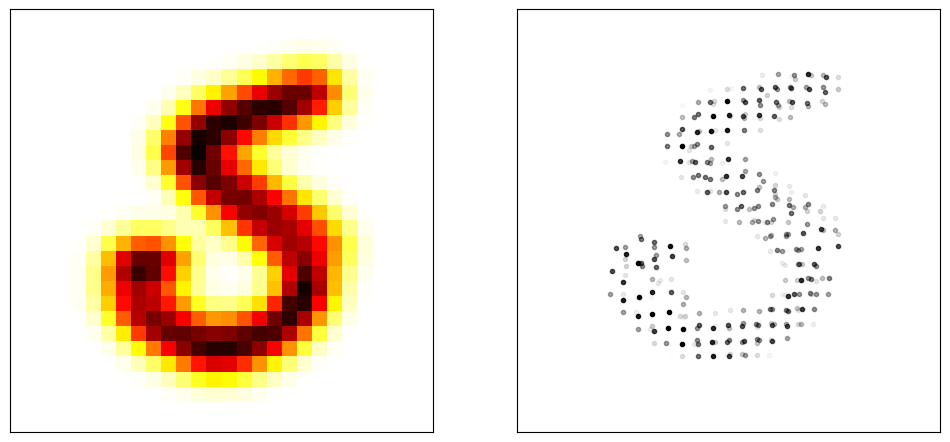

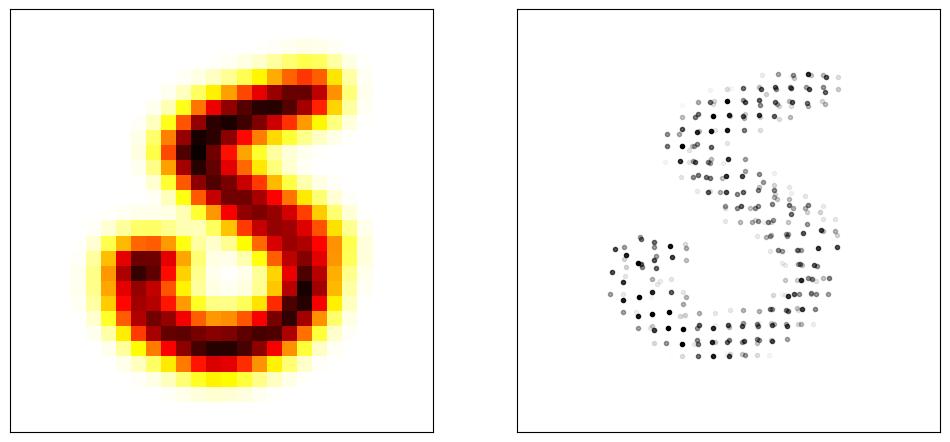

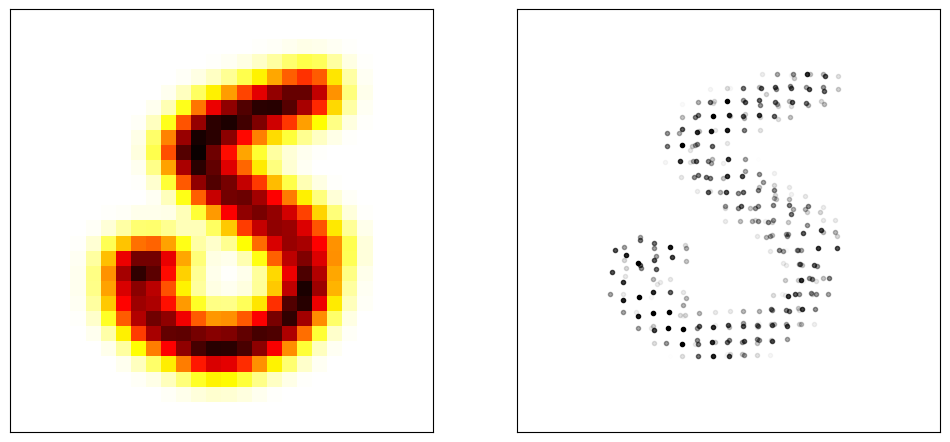

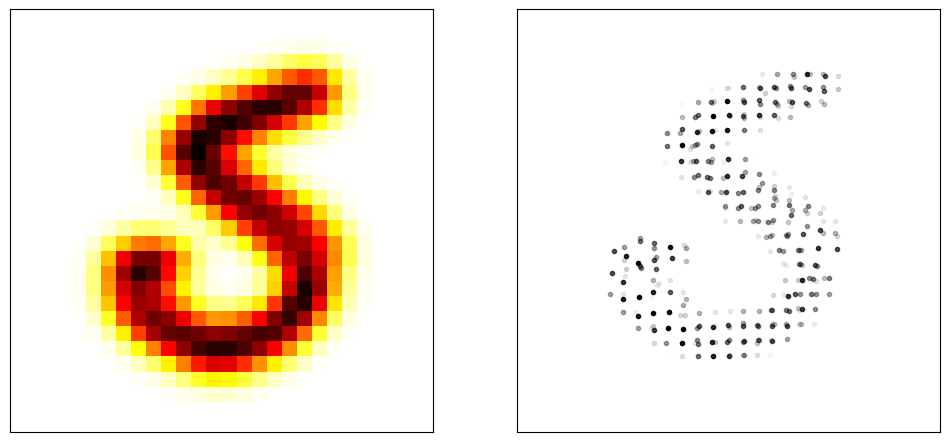

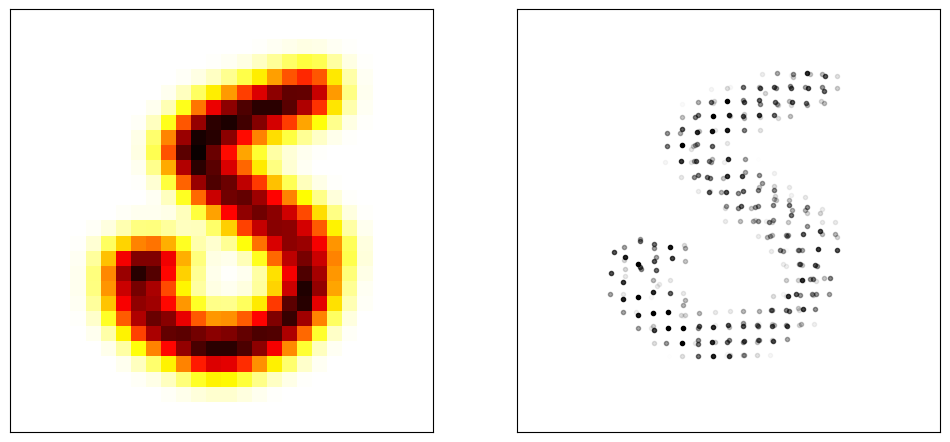

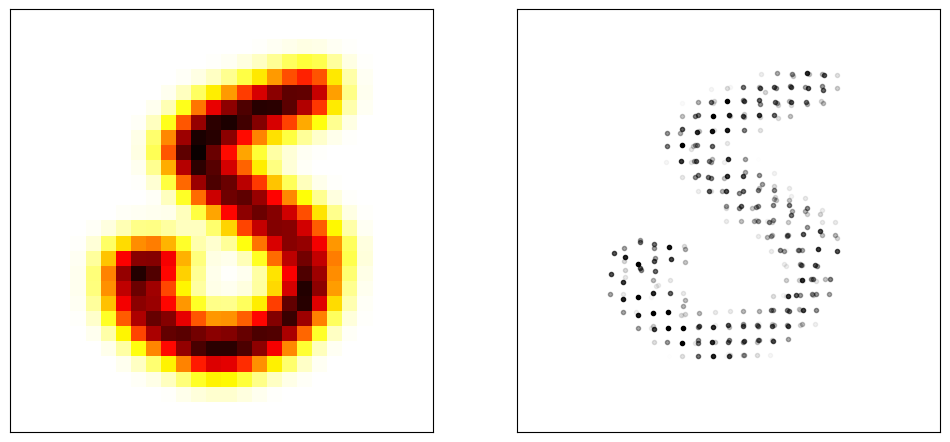

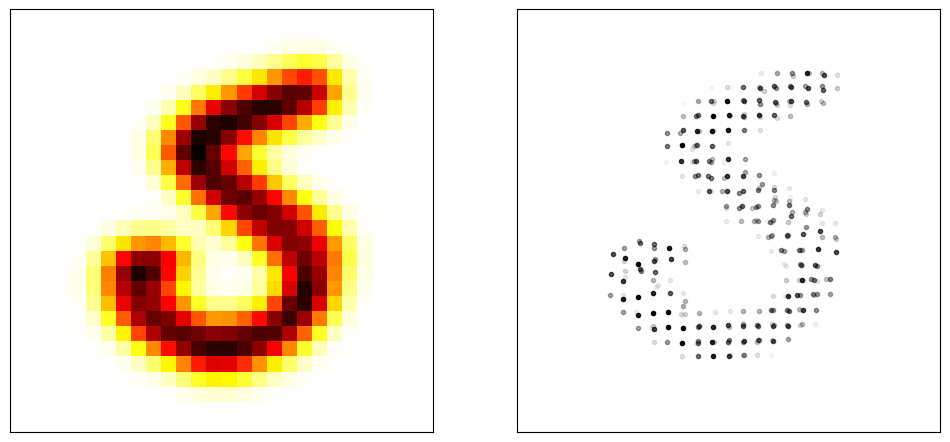

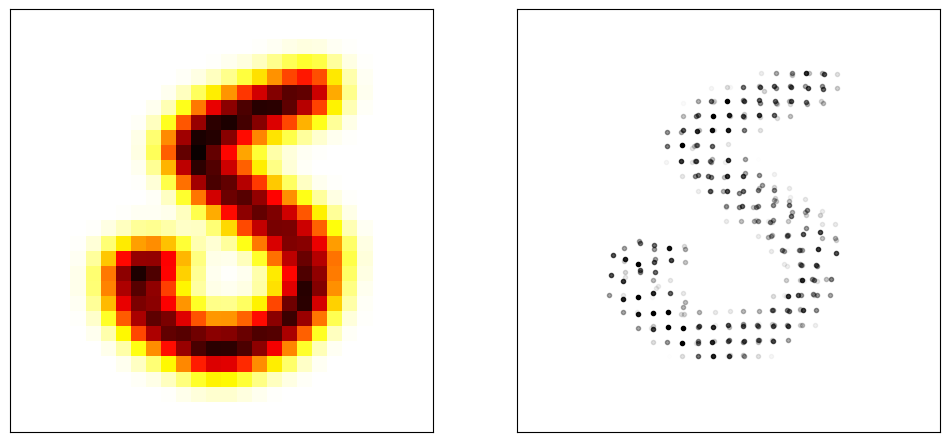

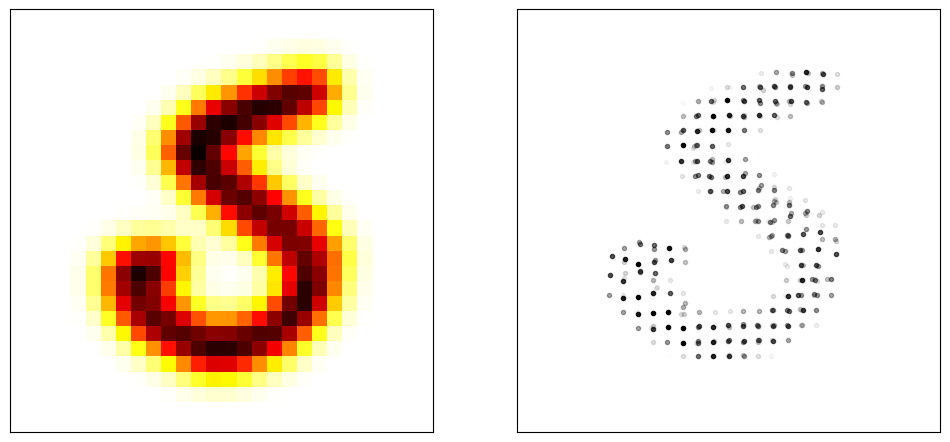

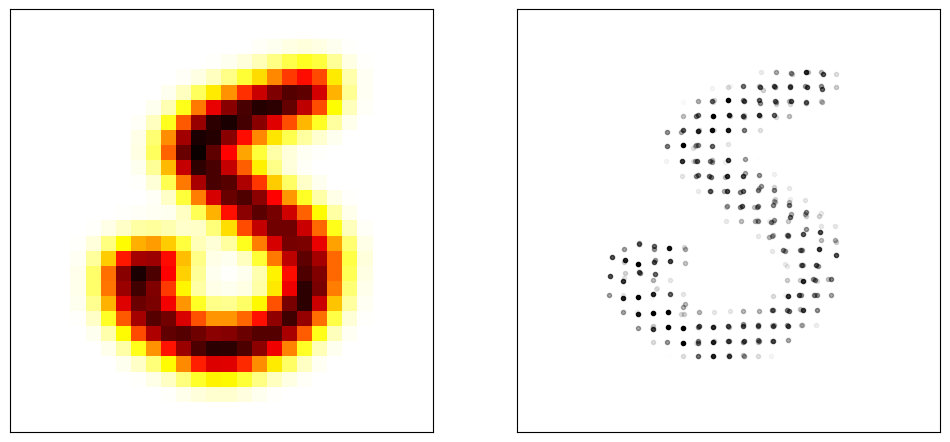

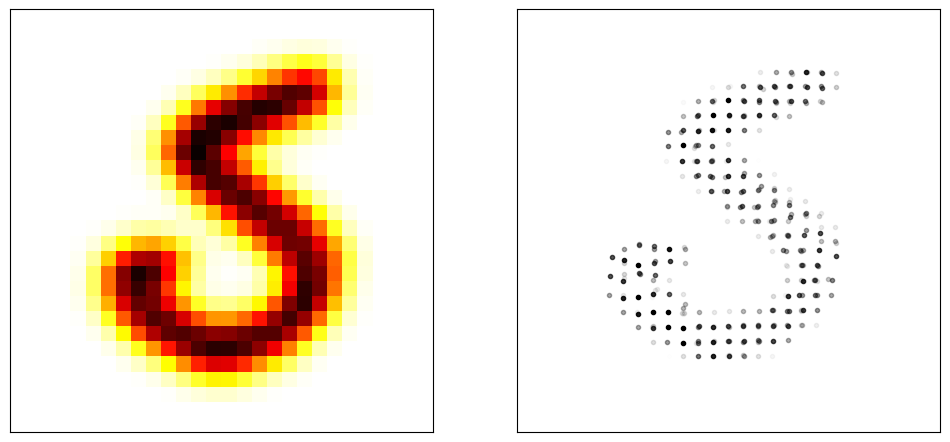

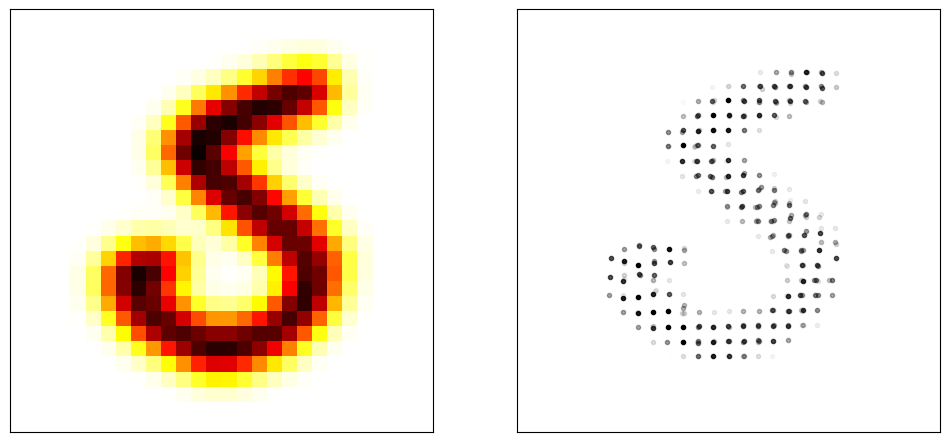

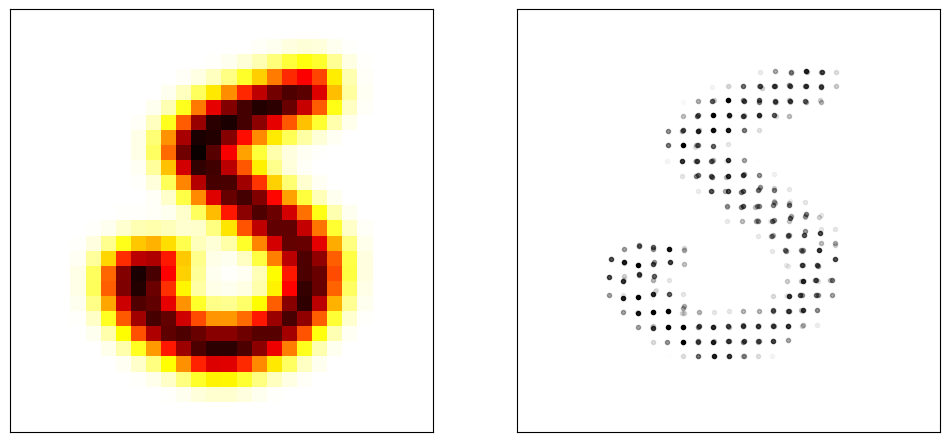

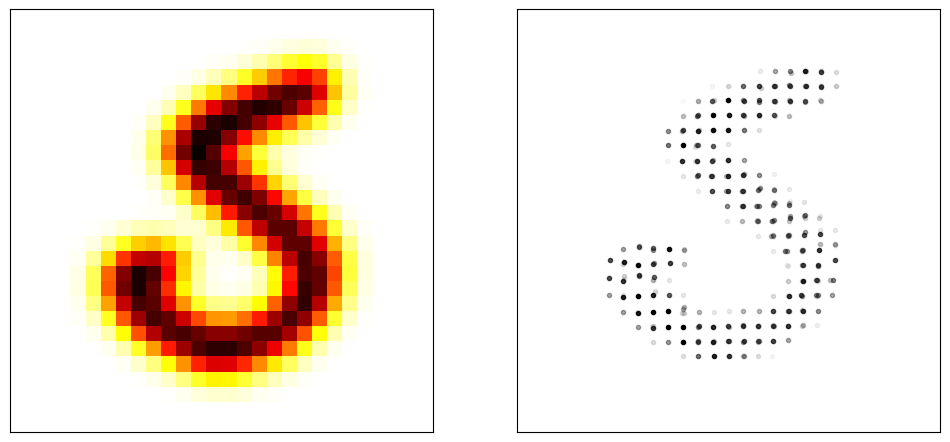

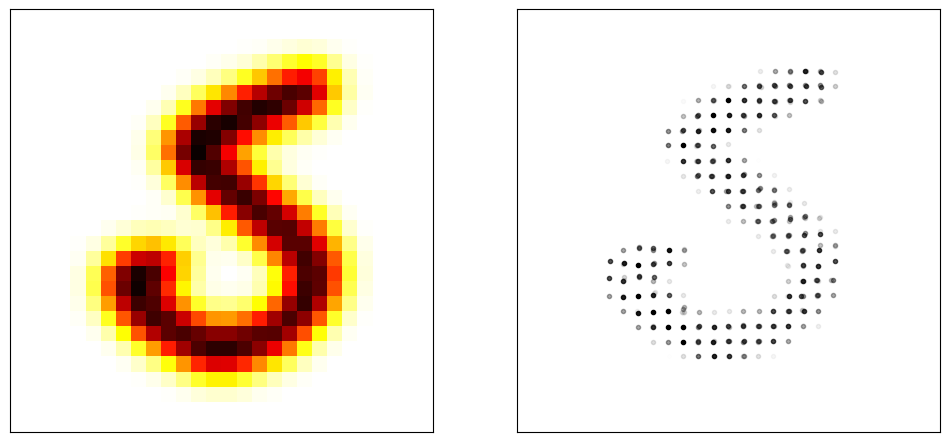

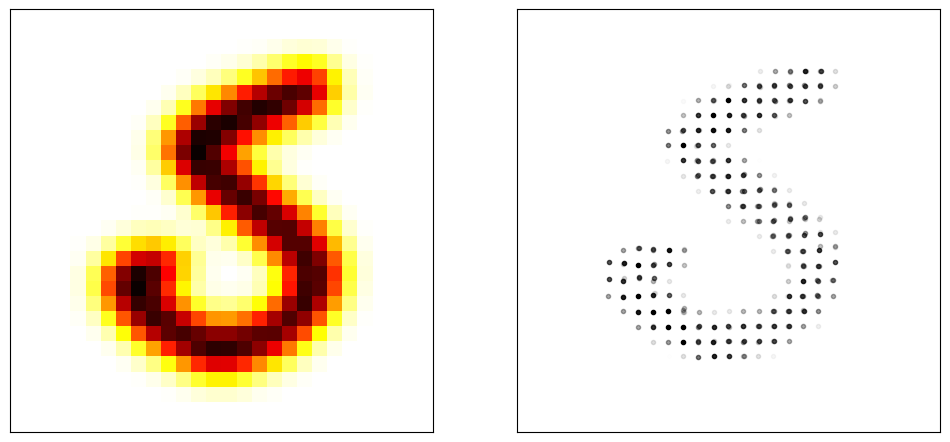

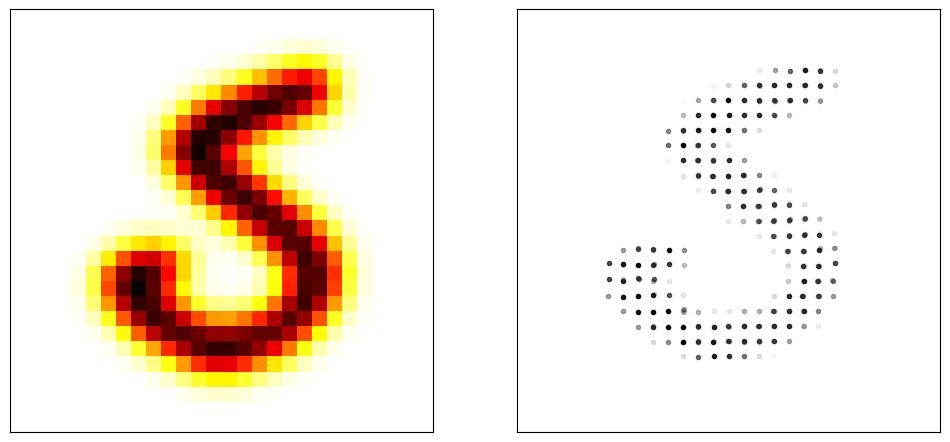

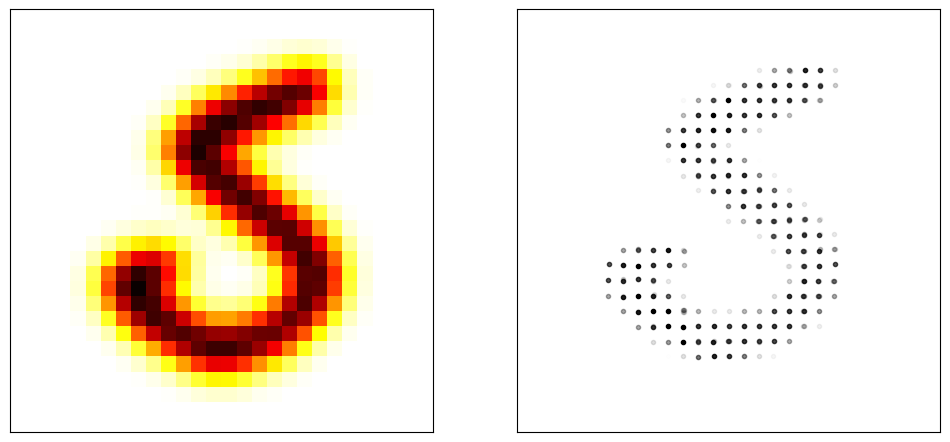

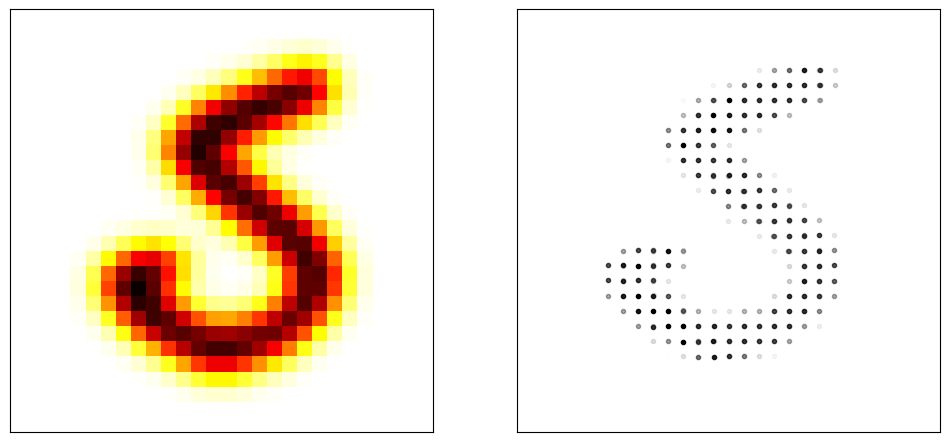

In [73]:
test0 = measure_list[7]

gamma = ot.emd(barycenter_150.weights, test0.weights, cdist(barycenter_150.locations,test0.locations))

for t in np.arange(0,1,.01):
    
    w = gamma.reshape(-1)
    Z = (((1-t)*barycenter_150.locations[:,None,:] + t*test0.locations[None, :, :]).reshape(784*150, 2))

    test = measure(w[w>0],Z[w>0])
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    test.plot_density()
    plt.subplot(1,2,2)
    test.plot_locations()
    # plt.show()
    plt.savefig("data_files//frames3//frame"+str(int(100*t))+".png")